In [1]:
pip install stepwise-regression

Note: you may need to restart the kernel to use updated packages.


# Few Remarks on the Methdology for Modelling Used

Aim: Extract important internal and external features in explaning 2022 rental prices. 

Model of choice: <code>ElasticNet()</code>, since we would expect many parameters, given the unique values of the suburbs and the highly variable rental prices across sububs. While the standard error of the coefficients are reduced, it will introduce model bias.

Now a naive way to do it would be to simply plot the full model and report the coefficients. Problems:
1. Although <code>ElasticNet()</code> implicitly performs variable selection, we still don't want our model to be too biased, or in worst case scenario, violates regression assumptions (trend of residuals increase w.r.t fitted values) because our model then wouldn't be reliable (high model variance). How to select the appropriate model then to explain 2022 rental prices?

2. To mitigate problem number 1, instead of using an inferential approach to evaluate the model fit and complexity, a ML-based approach will be used here, particularly learning curves.
    - If we generate a model based on a training data, will the coefficients be reliable to explain the rental prices in the holdout data (or at least, the trend) just like in the training data? How does this reliability change as we increase the training data?
    - Also, will any feature engineering attempts increase model variance, or perhaps overfit the training data?

Rough steps below (did construct a pdf regarding a diagram, but can't fit here)
1. Stratify sampling (by suburb) a training data, and let the rest be testing data

Next, Repeat: 

2. Choose best model with best hyperparameters in training data by using 10 fold CV

3. Plot Learning Curve on entire dataset using the model specification and hyperparameters obtained in 2.

4. Residual Plot on Training Data 

5. Do further EDA and/or feature engineering on training data 

6. Analyse learning curve and any patterns in residuals to guide for next feature engineering

7. Go back to 2. provided any feature engineering methods specified



# To read the whole notebook, can just skip to 1. and ignore all functions signified  in <font color='blue'>light blue</font> font)

In [659]:
from stepwise_regression.step_reg import backward_regression, forward_regression
import geopandas as gpd
from shapely import wkt #to find centroid of a polygon
from zipfile import ZipFile
from shapely.geometry import Point
import folium
from statsmodels.formula.api import ols, glm
from scipy.stats import entropy
import sklearn.linear_model

# Table of Contents (Still not complete yet right now)<a name='TOC' />

Preparing geospatial code, should we need it.


# <a href=#bookmark0>0. Import libaries and data respectively </a>

<a href=#extract_historical_cols><font color='blue'>Function to extract external columns that are historical (e.g. extract <code>median_rent</code> from <code>2000_median_rent 2000_median_rent, ... , etc</code>)</font> </a>


<a href=#bookmark0.1.3>0.1.3 <font color='green'>Sanity check results, packaged into a function. Skip to this if don't want to see all above </font></a>

# <a href=#bookmark1>1. *Split the data first* and use *stratified* sampling</a>

# <a href=#bookmark2>2. Begin some EDA on the stratified training data</a>

<a href=#bookmark2.0>2.0 Remark before starting EDA</a> 

<a href=#bookmark2.1>2.1 Pairwise plot for internal features</a>

<a href=#sz_internal_continuous_training_cols><font color='blue'>Functions to standardize internal columns and external columns in training data, also returns appropriate statistics. Also can standardize entire dataset</font> </a>

<a href=#bookmark2.2>2.2 Pairwise plot/correlation plot for external features</a>

Some helper functions below (in blue font, to assist in model fitting)

<a href=#filter_df_to_res_and_one_ext_var><font color='blue'> Function to filter training data containing just the response variable and historical external columns corresponding to one particular external variable </font> </a>


<a href=#OH_encoder><font color='blue'>Function to one hot encode categorical variables. </font></a>

<a href=#std_and_OH><font color='blue'>Function to preprocess vars; so far: standardize + OH encode </font></a>

<a href=#transform_test_data><font color='blue'>Function to "transform"/preprocess test data </font></a>


<a href=#ols_formula_object><font color='blue'>Function to make formula object to be passed to statsmodels' OLS model</font></a>

<a href=#elasticNetHyp><font color='blue'>Function: hyperparameter tuning for penalized regression (elastic net): which penalty method (i.e. alpha) produces the somewhat optimal model? </font> </a>

<a href=#K-fold-CV><font color='blue'> Function for K-fold CV</font> </a>


# <a href=#bookmark3>3. **FIRST MODEL**</a>

<a href=#bookmark3.1>3.1 Evaluating R2 for training and testing data </a>

<a href=#residualPlotFunc><font color='blue'>Function for residual plot.</font> </a>

<a href=#bookmark3.2>3.2 Learning Curve</a>

<a href=#bookmark3.3>3.3 Residual Plot for Training</a>

<a href=#first_model_remark>3.4 What can we say about the first model?</a>



# <a href=#bookmark4>4. Further Feature Engineering (preparing for 2nd model fitting)</a>

<a href=#bookmark4.1>4.1 Visualise relationship between response and each transformed external variable (into annual increases) </a>

<a href=#bookmark4.2>4.2 Pairwise plot of internal features for any possible transformation</a>

<a href=#bookmark4.3>4.3 Current decision to feature engineer: </a>

<a href=#bookmark4.4>4.4 **Fitting Second Model** given the feature engineerings [1) time lag for historical external vars 2) transformation for distance to cbd variable 3) log response variable] + evaluating the model + diagnostics</a>

<a href=#bookmark4.5>4.5 Learning Curve for Second Model</a>

<a href=#bookmark4.6>4.6 Residuals for Training data in Second Model </a>

<a href=#bookmark4.7> 4.7 What can we say about the second model?</a>

# <a href=#bookmark5>5. **Third model**: fit the same model above as model 2, but without the historical external variables?</a>

<a href=#bookmark5.1>5.1 Learning Curve for 3rd model </a>

<a href=#bookmark5.2>5.2 Training Residuals for 3rd model </a>

<a href=#bookmark5.3>5.3 What can we say about this model (third model)</a>

# <a href=#bookmark6>6. Feature Inspection + Engineering (preparing for fourth model)</a>

<a href=#bookmark6.1>6.1 Fit **fourth model** to training data</a>

<a href=#bookmark6.2>6.2 Learning Curve for Fourth Model</a>

<a href=#bookmark6.3>6.3 Residual Plot in Training Data for Fourth Model</a>

<a href=#bookmark6.4>6.4 What can we say about this model (fourth model)</a>


# <a href=#bookmark7>7. Choose Final Model and Visualise Regression Coefficients</a>

# Geospatial Code 

In [4]:
def preproc_shapefile(vic_shapefile):
    
    #casefold into lower cases 
    vic_shapefile['LOC_NAME'] = vic_shapefile['LOC_NAME'].str.lower()
        
    #remove duplicates
    vic_shapefile_no_duplicates = vic_shapefile.loc[vic_shapefile['LOC_NAME'].drop_duplicates().index,:]
    
    vic_shapefile['centroid'] = vic_shapefile['geometry'].map(
    lambda polygon: 
        wkt.loads( #after finding centroid, need to re-parse this back into a Point object
            wkt.loads(str(polygon)).centroid.wkt #need str object to find centroid
        )
    )
    
    return vic_shapefile
    
    

# <font color='red'> Self-note: Path of shapefile for geospatial has changed: CHANGE <code>vic_localities.shp</code> to <code>vic_shapefile_zipped.zip</code> </font>

In [5]:
vic_sf = gpd.read_file('../data/raw/vic_shapefile_zipped.zip')
vic_shapefile_no_duplicates = preproc_shapefile(vic_sf)

In [6]:
def geopandas_plotting(rental_df, 
                       sf=vic_shapefile_no_duplicates, 
                       legend_name='Distribution of prices across suburbs', 
                       col_to_be_plot='cost_text',
                       save=False,
                       saved_map_name='',
                       map_format='html'):
    
    """
    Helper function to plot an aggregated metric by suburb
    (e.g. taking the mean of rental prices per suburb)
    
    Arguments:
    1. rental_df: df containing suburb columns and an aggregated
    metric corresponding to each suburb 
    
    E.g. columns may look like SUBURB || MEAN OF RENTAL PRICES
    
    2. sf: preprocessed victoria shapefile using the function above
     - Already provided with the preprocessed shapefile as default argument, 
       no need to pass preprocessed shapefile anymore!
    
    3. legend_name: legend text to appear on bottom right of the folium map
    
    4. col_to_be_plot: which numeric col to be plotted 
    
    
    """
    
    
    #if not specifying the legend name then the default one 
    #here will be used. 
    if not legend_name:
        legend_name = f'Distribution of {col_to_be_plot} across suburbs'

    #sf: shapefile of all victorian suburbs (vic_shapefile_no_duplicates)

    #need to have shapefile and zone lookups (in this case, suburb) before plotting
    
    

    # Convert the geometry shaape to to latitude and longitude
    # Please attribute this if you are using it
    sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    #gdf = rental_df merged with sf to obtain the geometry for each subrub
    gdf = rental_df.merge(sf[['LOC_NAME', 'geometry']],
            left_on = 'suburb',
            right_on = 'LOC_NAME',
            how='inner').\
            drop(columns=['LOC_NAME'])

    #convert the merged rental_df to a GeoDataFrame 
    gdf = gpd.GeoDataFrame(gdf)

    # combine geopandas with folium to create visualistion,  
    # but still need geojson and folium map object

    #note: drop duplicates because initiallly there are multiple properties in a suburb
    #but to find the geometry we don't require all duplicates. 
    geoJSON = gdf[['suburb', 'geometry']].drop_duplicates('suburb').to_json()


    # df_toplot = rental_df.copy()
    # df_toplot = df_toplot \
    # .merge(gdf[['LocationID', 'geometry']], left_on='PULocationID', right_on='LocationID') \
    # .drop('LocationID', axis=1) #drop duplicate LocationID column

    # print(df_toplot)

    m = folium.Map(location=[-37.7829335, 144.9575056])

    # refer to the folium documentations on more information on how to plot aggregated data.
    c = folium.Choropleth(
        geo_data=geoJSON, # geoJSON 
        name='choropleth', # name of plot
        data=gdf, # data source
        columns=['suburb',col_to_be_plot], # the columns required
        key_on='properties.suburb', # this is from the geoJSON's properties
        fill_color='YlOrRd', # color scheme
        nan_fill_color='black',
        legend_name=legend_name
    )

    c.add_to(m)


    display(m)
    
    if save == True:
        m.save(f'../plots/{saved_map_name}.{map_format}')


# 0. Import libaries and data respectively<a name='bookmark0' />

<a href=#TOC>Back to ToC</a>

In [7]:
from statsmodels.formula.api import ols, glm
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from glmnet import ElasticNet
import numpy as np

In [8]:
import pandas as pd
final_data = pd.read_csv('../data/curated/Final_Merged_Dataset.csv')

In order for geospatial code to work, all suburbs in the merged dataset used for modelling have to exist in the vic shapefile.

In [9]:
set(final_data['suburb'].unique()) - set(vic_shapefile_no_duplicates['LOC_NAME'])

set()

<font color='blue'>Function to extract external columns that are historical (e.g. extract <code>median_rent</code> from <code>2000_median_rent 2000_median_rent, ... , etc</code>)</font> <a name='extract_historical_cols' />

In [14]:
def extract_col_with_historical_values(findall_raw_match):
    
    #re.findall will return matches as a list
    findall_match_tuple = findall_raw_match[0]
    
    #as mentioned above, given 2 capture groups then 
    #match will be returned as a tuple. 
    if findall_match_tuple[0] == '':
        return findall_match_tuple[1]
    return findall_match_tuple[0]

cols_with_historical_vals = pd.Series(final_data.columns)[
        pd.Series(final_data.columns).str.contains('\d')
    ].\
        str.findall('([A-Za-z_]*)[\d_]+([A-Za-z_]*)').\
        map(lambda x: extract_col_with_historical_values(x)).unique()

cols_with_historical_vals


array(['median_rent', 'annual_income', 'population_',
       'population_density_', 'immigration', 'unemployment_rate'],
      dtype=object)

In [15]:
def extract_col_with_historical_values_from_df(final_data):
    
    cols_with_historical_vals = pd.Series(final_data.columns)[
        pd.Series(final_data.columns).str.contains('\d')
    ].\
        str.findall('([A-Za-z_]*)[\d_]+([A-Za-z_]*)').\
        map(lambda x: extract_col_with_historical_values(x)).unique()
    
    return cols_with_historical_vals

Do columns that contain numbers only STRICTLY encopass the variables above?

In [16]:
def is_col_containing_nums_not_periodic(raw_col_name, cols_with_historical_vals):
    
    for col in cols_with_historical_vals:
        if col in raw_col_name:
            return False
    return True

pd.Series(final_data.columns)[
        pd.Series(final_data.columns).str.contains('\d')
    ].map(lambda x: is_col_containing_nums_not_periodic(x, cols_with_historical_vals)).sum()

0

all columns with numbers are columns whose values were recorded prior to 2022.
- So columns containing numbers <=> columns whose values are historical


While population cannot be floats theoretically their values are not bounded. <font color='green'>So we can treat them as numeric variables</font>

Yeah, only a finite number of values available. <font color='green'> So need to typecast them into ints</font>

## 0.1.3 <font color='green'>Sanity check results, packaged into a function. Skip to this if don't want to see all above </font><a name='bookmark0.1.3' />

<a href=#TOC>Back to ToC</a>

In [23]:
def additional_typecasts(final_data):
    
    #typecast population into floats. Conventionally we'd treat
    #ints for ordinal variables but # of values in population is 
    #unbounded, so maybe more suitable to be ints 
    
    final_data.loc[:, final_data.columns.str.contains('population')] =\
        final_data.loc[:, final_data.columns.str.contains('population')].astype('float64')
    
    #typecast parking spaces to int (is a ordinal variable); can only take values 1-6
    final_data.loc[:,'parking_spaces'] = final_data.loc[:,'parking_spaces'].astype('int64')
    
    return final_data

In [116]:
final_data = additional_typecasts(final_data)

Now, we're good to jump into modelling!

# 1. Since there are many variables, need to have a look at them first --> need some training data for doing EDA. So **split the data first** <a name='bookmark1' />

<a href=#TOC>Back to ToC</a>

Also, use stratified sampling to ensure that we every suburb is roughly equally represented in the training data.

In [24]:
def sample_df(df, frac=0.5):
    
    """Sampling 100*frac % of the
    dataframe df. If num rows of 
    df not enough we just return the data
    frame. 
    
    Usually used when want to stratify sampling 
    100*frac% of instances per suburb 
    """
    
    #if num rows of df is not enough to be sampled
    #based on the frac specified
    if df.shape[0] * frac < 1:
        return df
    
    else:
        return df.sample(frac=frac,
                        random_state=1)


In [25]:
def stratify_sampling_unif(final_data, frac=0.5):
    
    """Split the full data into training 
    and testing data by stratify sampling that 
    makes sure each suburb gets its 100*frac% 
    of instances sampled. """
    
    #sample 100*frac% of instances per suburb 
    train_data = final_data.groupby(
                    'suburb',group_keys=False).apply(
                            lambda x: sample_df(x, 0.5)
                        )
    #obtain the test data
    test_data = final_data[
        ~final_data.index.isin(train_data.index)
    ]

    return train_data, test_data

In [26]:
train_data_strat, test_data_strat = stratify_sampling_unif(final_data)

# 2. Begin some EDA on the stratified training data <a name='bookmark2' />

<a href=#TOC>Back to ToC</a>

## 2.0 Remark before starting EDA <a name='bookmark2.0' />

<a href=#TOC>Back to ToC</a>

A natural thing to do is to do a pairwise plot. But we have 98 columns in total.. 

But we can do several pairwise plots:

1. For columns that are historical, we'd expect to be correlated overtime. 
    - E.g. median rent in 2000 will be somewhat correlated to median rent in 2001, and up to whatever year it is recorded. Same thing for others.
    - So for each of <code>['median rent', 'annual income', 'population','population density','immigration','unemployment rate']</code> we might do a pairwise plot. 
        - Then for each of them we might feature engineer: take the annual difference (e.g. so for median rent, cols will be: <code>['annual increase from 2000', 'annual increase from 2002', .... ]</code>, hoping that this will reduce multicollinearity.
    
    
2. As for the other columns (i.e. **INTERNAL** features) we can also do a pairwise plot (only 6 columns roughly, excluding suburbs)

# 2.1 Pairwise plot for internal features <a name='bookmark2.1' />

<a href=#TOC>Back to ToC</a>

In [48]:
train_data_internal_feats = train_data_strat.loc[:,~train_data_strat.columns.str.contains('\d')]
train_data_external_feats = train_data_strat.loc[:,train_data_strat.columns.str.contains('\d') | 
                                                      train_data_strat.columns.str.contains('cost_text')]

<font color='blue'>Function to standardize internal columns in training data, also returns appropriate statistics</font> <a name='sz_internal_continuous_training_cols' />

In [129]:
def standardize_continuous_cols_internal_feats(train_data_internal_feats):
    """
    Standardizes continuous INTERNAL columns in the 
    TRAINING set that only contains the INTERNAL columns.
    
    Returns a tuple, containing: 
    1. the standardized training data with internal columns
    
    2. means and standard deviations of each such column 
    to be transformed to the holdout set. 
    
    """
    #sanity check to not mutate the original data
    train_data_internal_feats_output = train_data_internal_feats.copy()
    
    
    continuous_internal_cols = train_data_internal_feats.dtypes[
        train_data_internal_feats.dtypes == 'float64' 
    ].index
    
    #exclude the response from being standardized
    continuous_internal_cols = list(set(continuous_internal_cols) - set(['cost_text']))
    
    #means and std of all internal continuous columns
    continuous_cols_statistics = train_data_internal_feats.loc[:,continuous_internal_cols].agg(['mean','std'])
    
    train_data_internal_feats_output.loc[:,continuous_internal_cols] =\
            stats.zscore(
                    train_data_internal_feats_output.loc[:,continuous_internal_cols]
            )
    
    return train_data_internal_feats_output, continuous_cols_statistics


In [128]:
def standardize_continuous_cols_external_feats(train_data_external_feats):
    """
    Standardizes continuous EXTERNAL columns in the 
    TRAINING set that only contains the EXTERNAL columns.
    
    Returns a tuple, containing: 
    1. the standardized training data with external columns
    
    2. means and standard deviations of each such column 
    to be transformed to the holdout set. 
    
    """
    #sanity check to not mutate the original data
    train_data_external_feats_output = train_data_external_feats.copy()
    
    
    continuous_external_cols = train_data_external_feats.dtypes[
        train_data_external_feats.dtypes == 'float64' 
    ].index
    
    #exclude the response from being standardized
    continuous_external_cols = list(set(continuous_external_cols) - set(['cost_text']))
    
    #means and std of all internal continuous columns
    continuous_cols_statistics = train_data_external_feats.loc[:,continuous_external_cols].agg(['mean','std'])
    
    train_data_external_feats_output.loc[:,continuous_external_cols] =\
            stats.zscore(
                    train_data_external_feats_output.loc[:,continuous_external_cols]
            )
    
    return train_data_external_feats_output, continuous_cols_statistics


In [127]:
def standardize_all_continuous_numeric_vars(train_data):
    """
    Standardizes ALL numeric columns
    
    Returns a tuple, containing: 
    1. the standardized continuous cols in the training data 
    
    2. means and standard deviations of each such column 
    to be transformed to the holdout set. 
    
    """
    
    train_standardized_output = train_data.copy()
    
    continuous_cols = train_standardized_output.dtypes[
        train_standardized_output.dtypes == 'float64'
    ].index
    
    #exclude the response from being standardized
    continuous_cols = list(set(continuous_cols) - set(['cost_text']))
    
    #means and std of all internal continuous columns
    continuous_cols_statistics = train_standardized_output.loc[:,continuous_cols].agg(['mean','std'])
    
    #standardize each numeric column
    train_standardized_output.loc[:,continuous_cols] =\
            stats.zscore(
                    train_standardized_output.loc[:,continuous_cols]
            )
    return train_standardized_output, continuous_cols_statistics
    

In [125]:
standardize_training_internal_feats_data = standardize_continuous_cols_internal_feats(train_data_internal_feats)
train_internal_standardized = standardize_training_internal_feats_data[0]

Pairwise plot between response and all internal features

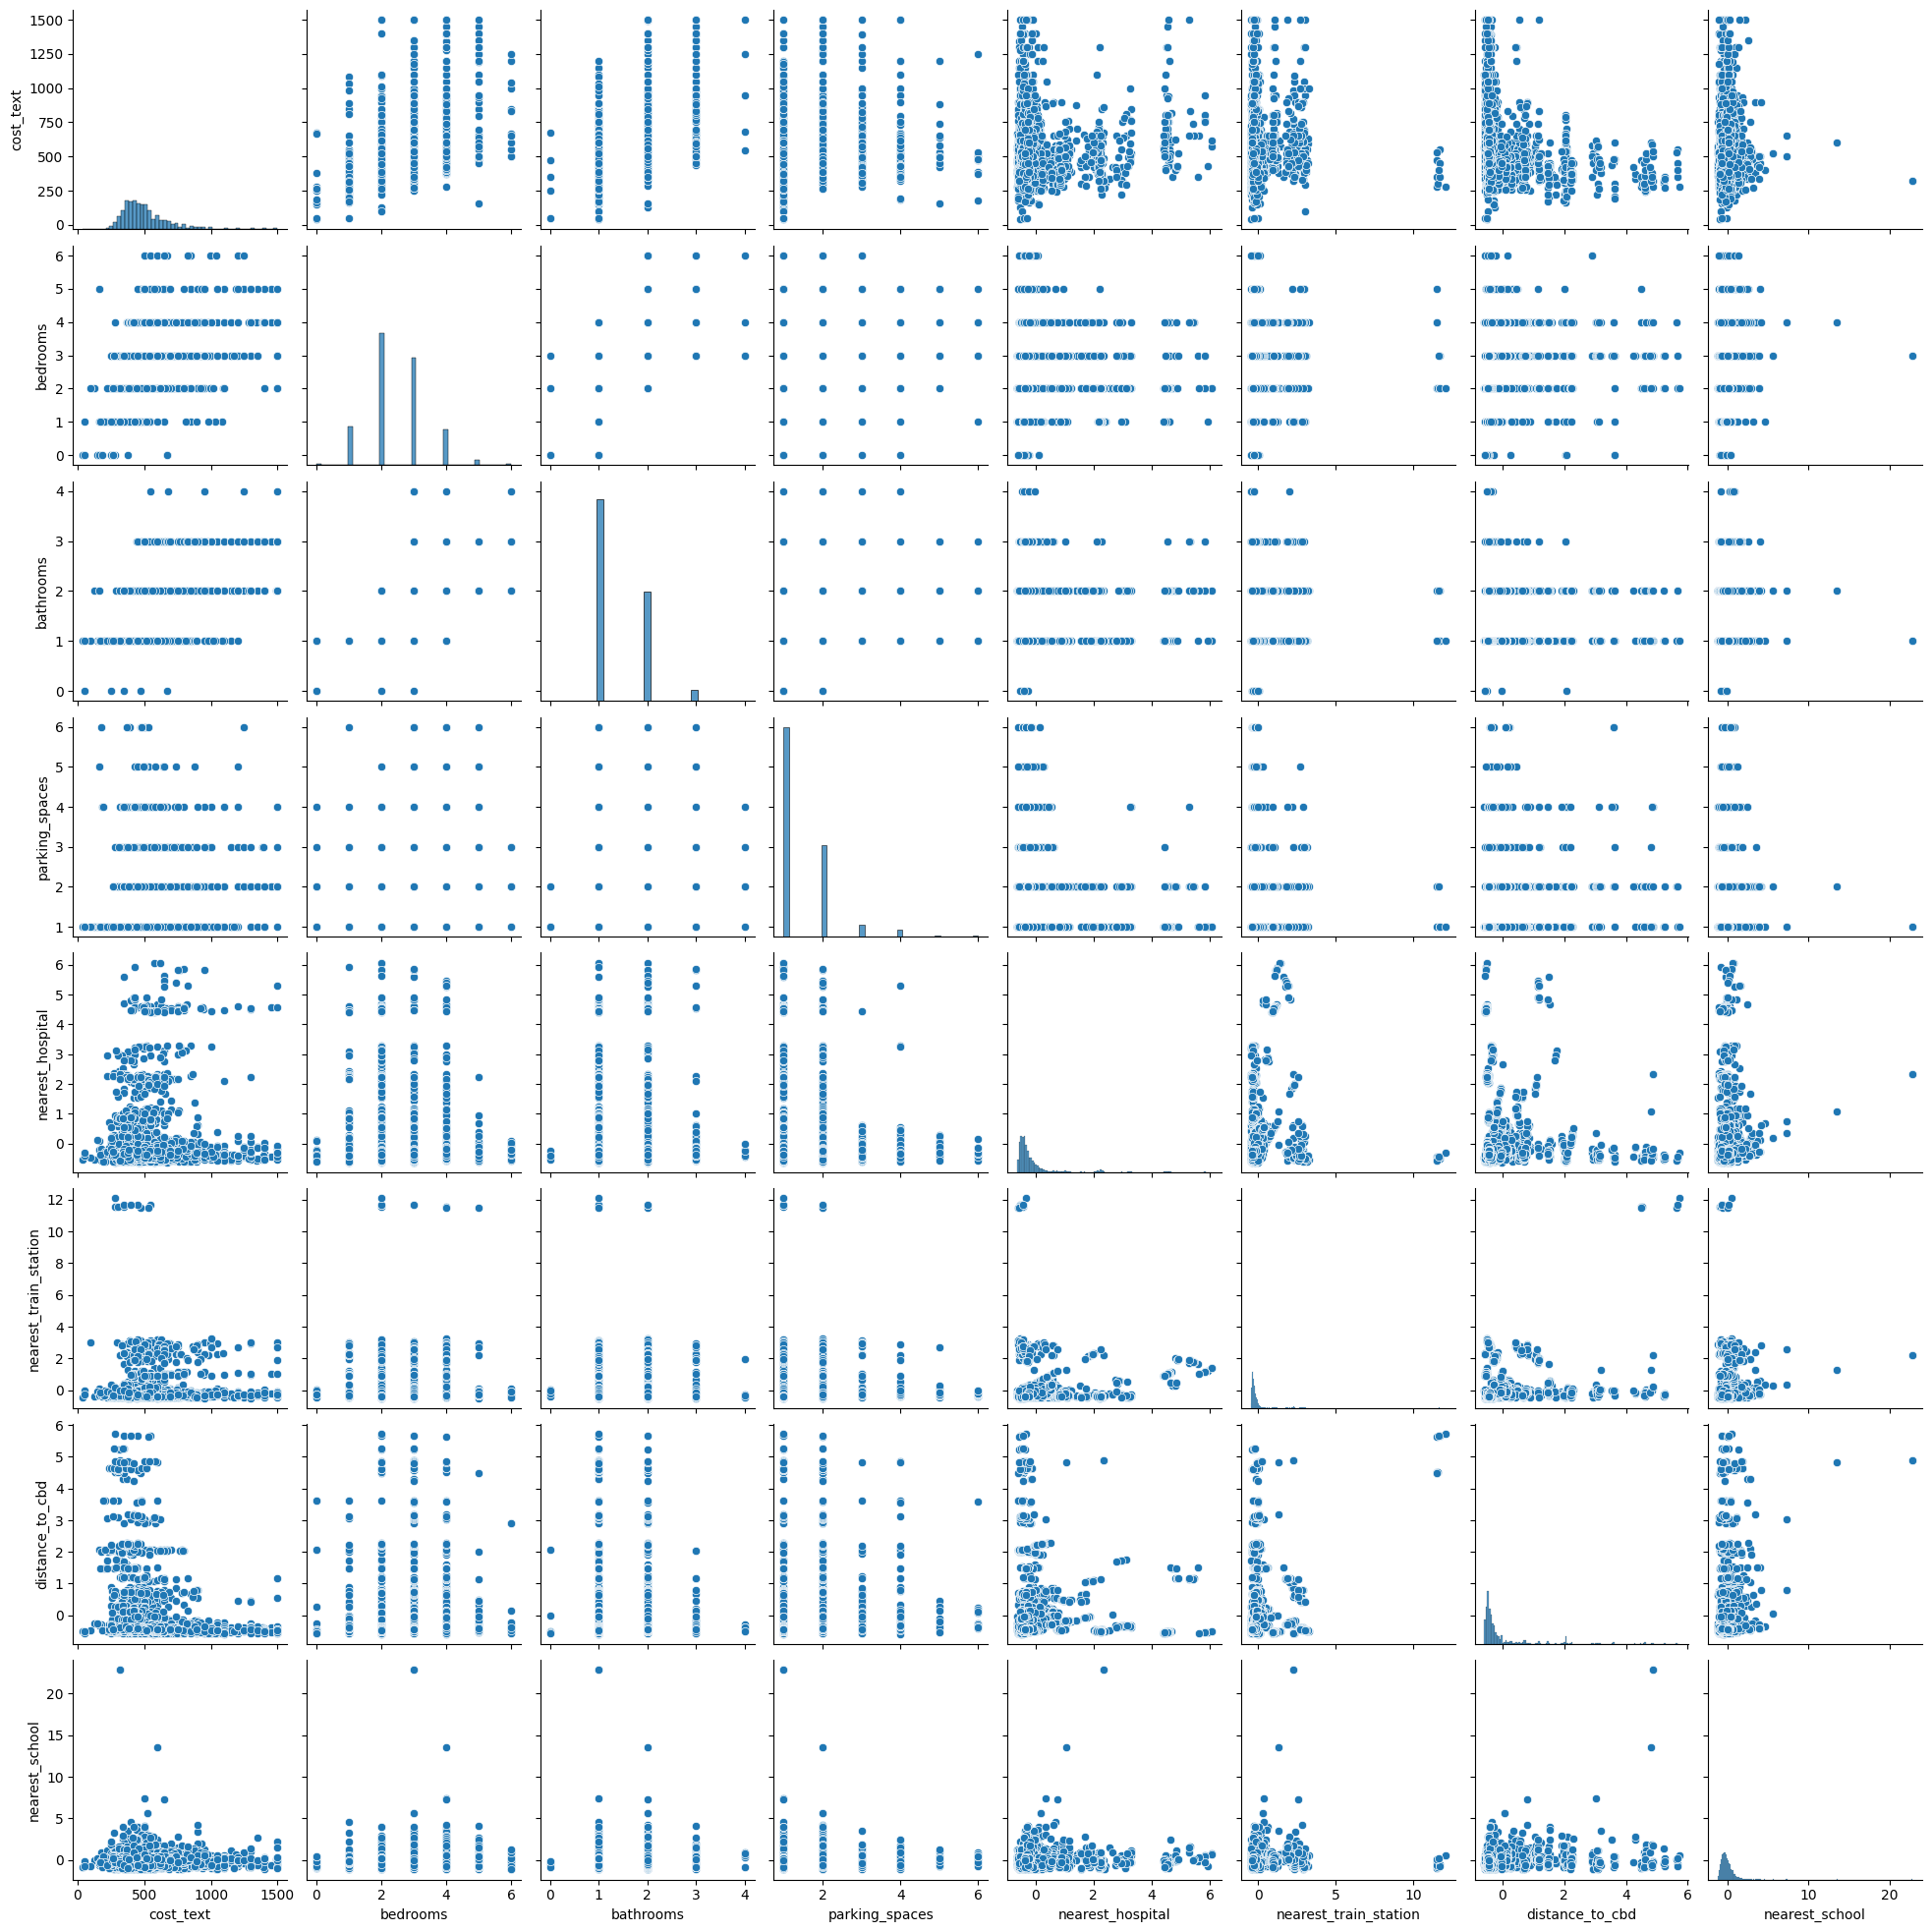

In [119]:
sns.pairplot(
    train_internal_standardized.drop(columns='suburb')
)

## <font color='red'>It seems that there's a somewhat evident inverse relationship between distance to cbd and cost_text</font> However, I will fit the full model first as a "baseline" and then attempt some feature engineering to see if there's any difference or not.

<AxesSubplot:>

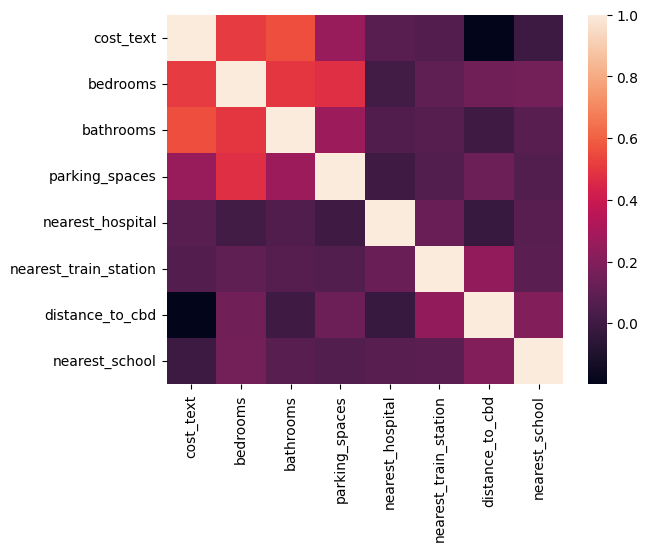

In [118]:
sns.heatmap(train_internal_standardized.drop(columns='suburb').corr())

# 2.2 Pairwise plot for external features <a name='bookmark2.2' />

<a href=#TOC>Back to ToC</a>

Extract *unique* variable names, excluding the year, that were taken in the past.

In [58]:
def extract_external_col_with_historical_values(data_external_feats):
    
    """Extract all external columns that were taken in
    the past and have numbers (years, in particular) in the 
    column names. 
    
    E.g. columns such as '2000_median_rent' will have 'median_rent'
    extracted, and the same for 'unemployment_rate' in 
    '2021_unemployment_rate'
    
    """
    
    def extract_match_with_historical_values(findall_raw_match):
    
        #re.findall will return matches as a list
        findall_match_tuple = findall_raw_match[0]

        #given 2 capture groups then 
        #match will be returned as a tuple. 
        if findall_match_tuple[0] == '':
            return findall_match_tuple[1]
        return findall_match_tuple[0]
    
    external_cols_with_historical_vals = pd.Series(data_external_feats.columns)[
        pd.Series(data_external_feats.columns).str.contains('\d')
    ].\
        str.findall('([A-Za-z_]*)[\d_]+([A-Za-z_]*)').\
        map(lambda x: extract_match_with_historical_values(x)).unique()
    
    return external_cols_with_historical_vals
    

In [59]:
unique_external_vals_historical = extract_external_col_with_historical_values(train_data_external_feats)

In [60]:
unique_external_vals_historical

array(['median_rent', 'annual_income', 'population_',
       'population_density_', 'immigration', 'unemployment_rate'],
      dtype=object)

<font color='blue'> Function to filter training data containing just the response variable and historical external columns corresponding to one particular external variable </font> <a name='filter_df_to_res_and_one_ext_var' />

<a href=#TOC>Back to ToC</a>

In [61]:
def extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, col_name):
    
    """Given:
    
    1. a training data containing only 
    the response and the external columns, 
    
    2. col_name representing the external variable
    that was recorded throughout time,
    
    extract input in 1. but only containing response and 
    the col_name represented (and its historical values)
    
    E.g. col_name = 'median_rent', so this function will return
    a subset of train_data_external_feats only containing columns: 
    
    cost_text || 2000_median_rent || 2001_median_rent .. || 
    
    """
    
    condition1 = train_data_external_feats.columns.str.contains(col_name)
                            
    condition2 = train_data_external_feats.columns.str.contains('cost_text')
    
    return train_data_external_feats.loc[:, (condition1 | condition2)].copy()

Plot correlations between response and annual median rents

<AxesSubplot:>

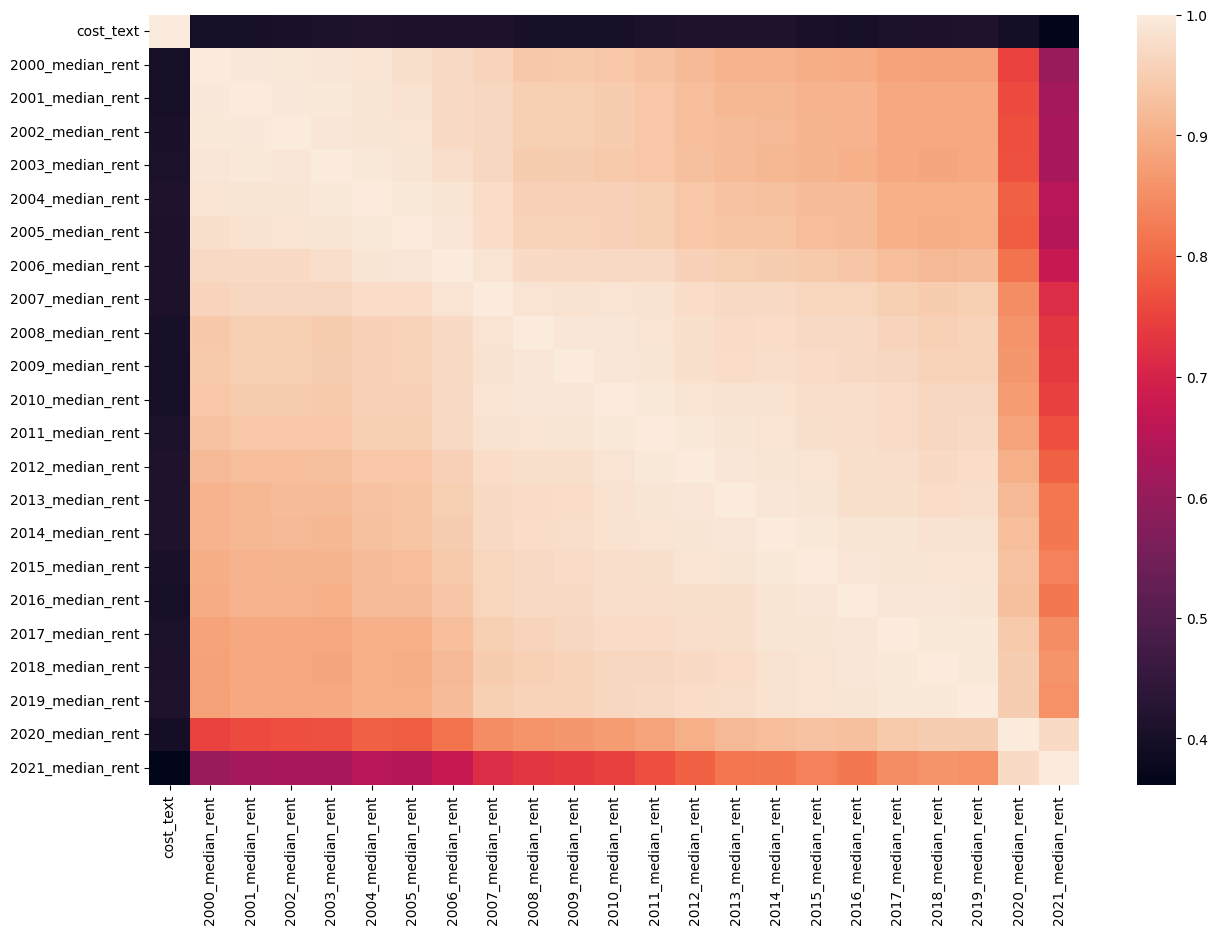

In [63]:
plt.figure(figsize=(15,10))
sns.heatmap(standardize_continuous_cols_external_feats(
    extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'median_rent')
)[0].corr())

## <font color='red'>A bit of autocorrelation evident here: the median rents are more correlated to each other as they get closer in time, but not so much (slightly) when they are far apart in time</font>

<AxesSubplot:>

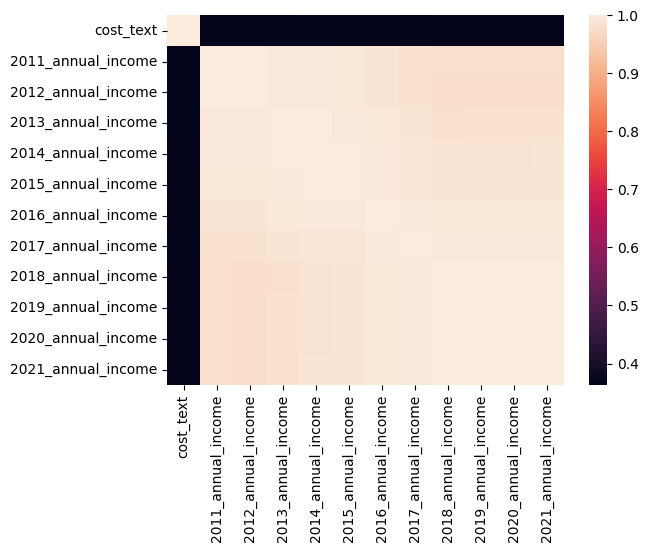

In [66]:
sns.heatmap(standardize_continuous_cols_external_feats(
    extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'income')
)[0].corr())

<AxesSubplot:>

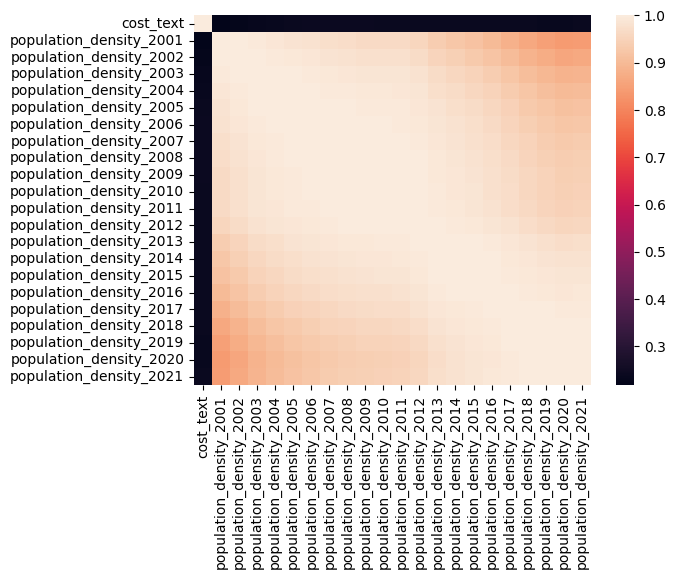

In [67]:
sns.heatmap(standardize_continuous_cols_external_feats(
    extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'population_density')
)[0].corr())

<AxesSubplot:>

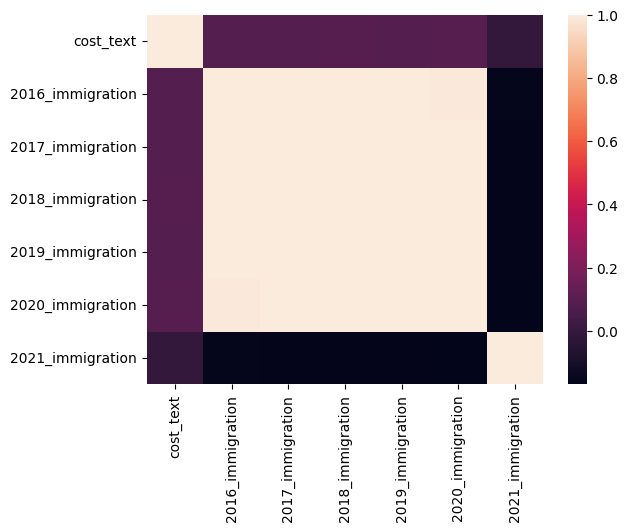

In [68]:
sns.heatmap(standardize_continuous_cols_external_feats(
    extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'immigration')
)[0].corr())

<AxesSubplot:>

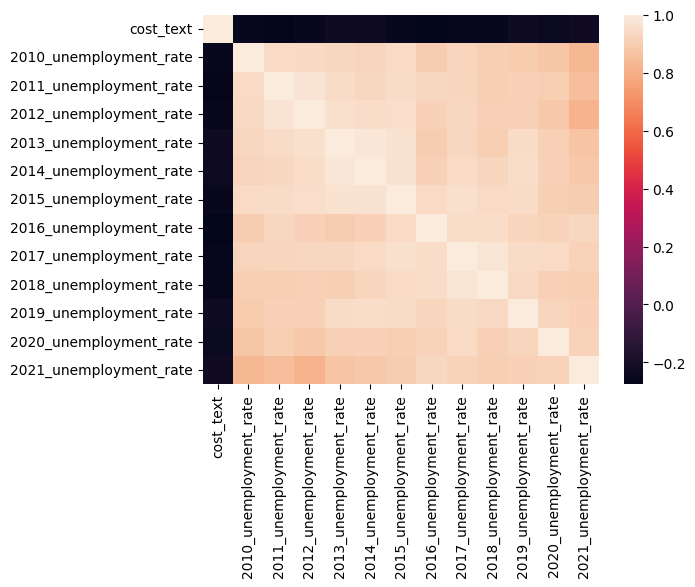

In [69]:
sns.heatmap(standardize_continuous_cols_external_feats(
    extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'unemployment')
)[0].corr())

## <font color='red'> This is bad: each of the external features are correlated to each other throughout the years. However, For now, we'll fit the full model first with *all* variables then do a comparison to the same model but I will do some feature engineering to reduce the colinearity from such external variables that are correlated to each other throughout the years.</font>

# Some Helper Functions for model fitting below.

<font color='blue'>Function to one hot encode categorical variables. </font><a name='OH_encoder' />

In [70]:
def one_hot_encoder(data, encode_ordinal=True):
    vars_to_encode = list(data.dtypes[data.dtypes.isin(['object','O'])].index)
    
    if encode_ordinal == True:
        vars_to_encode += list(data.dtypes[~data.dtypes.isin(['object','O','float64'])].index)
        
    encoded_output = pd.get_dummies(data=data.copy(),
                   columns=vars_to_encode)
    
    encoded_output = encoded_output.astype('float64')
        
    return encoded_output


<font color='blue'>Function to preprocess vars; so far: standardize + OH encode </font><a name='std_and_OH' />

In [71]:
def preprocess_vars_for_train(train_data, encode_ordinal=True):
    
    """
    Preprocessed columns before hyperparameter tuning
    and/or model fitting. So far, we have to: 
    1. Standardize numeric attributes
    2. One hot encode nominal attributes. 
    
    There is a choice to whether encode ordinal attributes
    or not. But normally we wouldn't, so encode_ordinal 
    would stay as True.
    """
    
    
    train_data_out = train_data.copy()
    
    #if, somehow, we have a compelling justification
    #to treat ordinal attributes as continuous/numeric
    if encode_ordinal == False:
        ordinal_cols = train_data_out.dtypes[
            ~train_data_out.dtypes.isin(['O','float64','object'])
        ].index
        
        train_data_out.loc[:,ordinal_cols] =\
            train_data_out.loc[:,ordinal_cols].astype('float64')
    
    #standardize numeric attributes. NOTE that the function has 
    #already excluded the response from being standardized!
    train_data_out = standardize_all_continuous_numeric_vars(train_data_out)[0]
    
    
    #OH encoder (if encode_ordinal = False then we only have 
    #to encode categorical cols)
    train_data_out = one_hot_encoder(train_data_out,
                                    encode_ordinal=encode_ordinal)
    
    return train_data_out
    
    

<font color='blue'>Function to "transform"/preprocess test data </font><a name='transform_test_data' />

In [72]:
def preproc_transform_test_data(test_data, train_data):
    """
    In order to obtain predictions for the test data given fitted model to 
    train data, preprocessing steps for test data should be exactly the same 
    with train data and in a way that prevents data leakage.
    - E.g. standardization in test data should be performed 
      with empirical statistics from the TRAINING data. 
    train_data HAS TO BE RAW. 
    """
    
    test_data_output = test_data.copy()
    #1. standardize numeric attributes based on statistics
    #on the TRAINING data
    
    #note we need training data to obtain
    #statistics needed for standardization.
    
    numeric_cols_in_train = list(train_data.dtypes[
        train_data.dtypes == 'float64'
    ].index)
    
    #make sure to remove the response variable. 
    numeric_cols_in_train = list(set(numeric_cols_in_train) -\
                                 set(['cost_text']))
    
    #obtain relevant statistics for standardization
    stats_for_standard = train_data.loc[:,numeric_cols_in_train].\
                                            agg(['mean','std'])
    
    #numeric cols in test should be the same to numeric cols in train.
    
    #standardize test data based on statistics from TRAINING data
    
    test_data_output.loc[:,numeric_cols_in_train] =\
    (test_data_output.loc[:,numeric_cols_in_train] - stats_for_standard.loc['mean',numeric_cols_in_train]) /\
                     stats_for_standard.loc['std',numeric_cols_in_train]
    
    #2. one-hot encode categorical and ordinal variables in the test data
    test_data_output = one_hot_encoder(test_data_output, 
                                       encode_ordinal=True)
    
    
    #NOTE: 1. some nominal values in the test data may NOT in
    #the training data, or
    #2. some nominal values in training data may NOT be in 
    #the test data. Soln: preprocess training data to see the actual columns
    #of the training data first (incl. after OH encoding)
    train_data_preproc = preprocess_vars_for_train(train_data, encode_ordinal=True)
    
    #by resetting columns in test data with training data, columns that are in 
    #the test data but not in training data will disappear.
    #if col in training data not in testing data then it will appear as NaNs
    #in the testing data. Solution is to just fill them with 0s, it won't
    #artificially affect the predictions. 
    test_data_output = pd.DataFrame(test_data_output, columns=train_data_preproc.columns).fillna(0)
    
    return test_data_output
    

<font color='blue'>Function to make formula object to be passed to statsmodels' OLS model</font> <a name='ols_formula_object' />

In [73]:
def make_formula_object(data, variables='all', response='cost_text'):
    
    """
    Makes a formula object consists of
    the concatenated variable names in strings
    with a '+' separator in between them, like
    lm formula object in R.
    
    Unless variables = 'all' (fit model using ALL variables)
    they MUST be passed as a list of strings. 
    
    """
    
    if variables == 'all':
        variables = data.columns
    
    lm_formula_str = f'{response} ~ '
    
    for variable in variables:
        
        if variable != response:
            
            if data.dtypes[variable] == 'float64':
                
                #if variable starts with a number or whitespace, 
                #statsmodels will throw a vague error.
                #e.g. some of our variables include 
                #e.g. "2006_median_rent"
                
                if (variable[0].isalpha() == False) or (' ' in variable):
                    lm_formula_str += f'Q("{variable}") + '
                    
                else:
                    lm_formula_str += f'{variable} + '
                
            #else we need to model the categorical/ordinal 
            #variable as a treatment contrast by enclosing
            #its name with C()
            
            else:
            
                lm_formula_str += f'C({variable}) + '
    
    
    return lm_formula_str.strip(' + ')

<font color='blue'> Function for K-fold CV</font> <a name='K-fold-CV' />

<a href=#TOC>Back to ToC</a>

In [74]:
def k_fold_CV(data, k, model, shuffle_data=False, swap_train_test=False, score='MAE', 
              display_entropy_suburbs=False, retransform_log_y=False,
              lambda_best=None):
    
    """
    
    1. Performs a K-fold cross validation
    model evaluation technique on 'data'
    using the tuned model with the training data.
    
    In particular, 
    
    - model should be a ElasticNet() object with 
    alpha specified and n_splits = 0 (reasoning 
    for n_splits = 0: see below) 
    
    - lambda_best should be the lambda that was obtained
    from cross validating the training data 
        - Note that glmnet.ElasticNet(n_splits=n).fit() automatically 
            recomputes best lambda using CV when n > 0. 
            - But in this case we already 
            have a tuned model and we JUST want to EVALUATE it! 
            - So, to prevent another recomputation of lambda, set n_splits=0
    
    
    2. Returns the scores (R2 or MAE)
    In particular, return value is:
    (testing_scores, training_scores)
    
    Each is a list. 
    
    """
    
    N = data.shape[0]
    N_per_fold = N // k
    
    scores_per_test_fold = []
    training_scores_per_iteration = []
    
    entropies_in_training = []
    entropies_in_testing = []
    
    if shuffle_data == True:
        #add code for random permutation if needed.
        #but for now we dont really need it. 
        pass
    
    for fold in range(0,k):
        #obtain testing and training folds
        testing_fold = data.iloc[ (N//k) * fold: (N//k) * (fold+1) ]
        training_folds = data[~data.index.isin(testing_fold.index)]
        
        #preprocess training and testing folds
        #do we want to do the usual CV?
        
        if swap_train_test == False: #usual K-fold CV (one fold = testing)
            
            if display_entropy_suburbs == True:
                
                suburb_entropy_in_training = entropy(training_folds['suburb'].value_counts(normalize=True))
            
                suburb_entropy_in_testing = entropy(testing_fold['suburb'].value_counts(normalize=True))
                
                entropies_in_training.append(suburb_entropy_in_training)
                entropies_in_testing.append(suburb_entropy_in_testing)
            
            
            training_folds_preproc = preprocess_vars_for_train(training_folds, encode_ordinal=True)
            testing_folds_preproc = preproc_transform_test_data(testing_fold, training_folds)
            
            
        else:
            
            if display_entropy_suburbs == True:
                    
                suburb_entropy_in_training = entropy(testing_fold['suburb'].value_counts(normalize=True))
            
                suburb_entropy_in_testing = entropy(training_folds['suburb'].value_counts(normalize=True))
                
                entropies_in_training.append(suburb_entropy_in_training)
                entropies_in_testing.append(suburb_entropy_in_testing)
                
            
            testing_folds_preproc = preprocess_vars_for_train(training_folds, encode_ordinal=True)
            training_folds_preproc = preproc_transform_test_data(testing_fold, training_folds)
        
        
        #train the model on training folds
        model_fitted = model.fit(
                #have to pass 2d array. and make sure to exclude response!
                training_folds_preproc.drop(columns='cost_text').values,
                training_folds_preproc['cost_text']
        )
        
        
        if score == 'R2':
        
            #get testing score
            score_per_test_fold = model_fitted.score(
                testing_folds_preproc.drop(columns='cost_text').values,
                testing_folds_preproc['cost_text'],
                lamb=lambda_best
            )

            #get training score
            training_score_per_iteration = model_fitted.score(
                training_folds_preproc.drop(columns='cost_text').values,
                training_folds_preproc['cost_text'],
                lamb=lambda_best
            )
            
        if score == 'MAE':
            
            #note: since MAE represents the DEVIATIONS between predicted
            #and actual value one way to inverse it is to multiply by -1
            
            #1. get testing prediction, and evaluate mean absolute error
            predict_test = model_fitted.predict(
                testing_folds_preproc.drop(columns='cost_text').values,
                lamb=lambda_best
            )
            
            #we might do a log transform on response as part
            #of feature engineering. Take its inverse back.
            if retransform_log_y == True:
                score_per_test_fold = np.exp(testing_folds_preproc['cost_text']) -\
                                        np.exp(predict_test)
                score_per_test_fold = -1 * np.mean(abs(score_per_test_fold))
                
                
            else:
                score_per_test_fold = testing_folds_preproc['cost_text'] - predict_test
                score_per_test_fold = -1 * np.mean(abs(score_per_test_fold))
            
            
            
            #2. get training prediction/fitted values, and evaluate mean absolute error
            predict_train = model_fitted.predict(
                training_folds_preproc.drop(columns='cost_text').values,
                lamb=lambda_best
            )
            
            #we might do a log transform on response as part
            #of feature engineering. Take its inverse back.
            
            if retransform_log_y == True:
                training_score_per_iteration = np.exp(training_folds_preproc['cost_text']) -\
                                                np.exp(predict_train)
                training_score_per_iteration = -1 * np.mean(abs(training_score_per_iteration))
                
            else:
                training_score_per_iteration = training_folds_preproc['cost_text'] - predict_train
                training_score_per_iteration = -1 * np.mean(abs(training_score_per_iteration))

        scores_per_test_fold.append(score_per_test_fold)
        training_scores_per_iteration.append(training_score_per_iteration)
        
    scores_per_test_fold = np.array(scores_per_test_fold)
    training_scores_per_iteration = np.array(training_scores_per_iteration)
    
    print("Scores for test folds: ", scores_per_test_fold)
    if display_entropy_suburbs == True:
        print("Suburb entropies for test folds: ", entropies_in_testing)
    
    print('\n')
    
    print("Scores for training folds: ", training_scores_per_iteration)
    if display_entropy_suburbs == True:
        print("Suburb entropies for training folds: ", entropies_in_training)
    
    return scores_per_test_fold, training_scores_per_iteration


<font color='blue'>Function: hyperparameter tuning for penalized regression (elastic net): which penalty method (i.e. alpha) produces the somewhat optimal model? </font> <a name='elasticNetHyp' />

<a href=#TOC>Back to ToC</a>

In [75]:
def best_penalty_method_elastic_net(preproc_train_data,
                                      n_splits=10,
                                      scoring='mean_absolute_error',
                                      random_state=1):
    
    alphas_to_iterate = np.linspace(0,1,20)
    best_lambdas_per_alpha = []
    best_scores_per_alpha = []
    
    #for a specified scoring method, test the penalty method: 
    #more leaning towards LASSO or ridge regression? 
    for alpha in np.linspace(0,1,20):
        
        #specify the model 
        elastic_net_model = ElasticNet(
                               alpha=alpha, 
                               n_splits=n_splits, 
                               scoring=scoring,
                               random_state=random_state
                              ) 
        
        #fit the model with our data
        elastic_net_model_fit = elastic_net_model.fit(
            #have to pass 2d array. and make sure to exclude response!
            preproc_train_data.drop(columns='cost_text').values,
            preproc_train_data['cost_text']
        )
        
        #best penalty weight 
        best_lambdas_per_alpha.append(elastic_net_model_fit.lambda_best_[0])
        
        #the best score according to the best penalty weight
        best_scores_per_alpha.append(
            elastic_net_model_fit.cv_mean_score_[-1]
        )
    
    best_alpha = alphas_to_iterate[np.argmax(best_scores_per_alpha)]
    
    #distinguish between the model as is and the FITTED model with the 
    #training data. 
    
    potentially_best_model_fit = ElasticNet(
                               alpha=best_alpha, 
                               n_splits=0, 
                               scoring=scoring,
                               random_state=random_state
                              )
    
    potentially_best_model_fitted = ElasticNet(
                               alpha=best_alpha, 
                               n_splits=n_splits, 
                               scoring=scoring,
                               random_state=random_state
                              ).fit(
            #have to pass 2d array. and make sure to exclude response!
            preproc_train_data.drop(columns='cost_text').values,
            preproc_train_data['cost_text']
        )
    
        
    return {'alpha': alphas_to_iterate,
            'best_lambdas_per_alpha': best_lambdas_per_alpha,
            'best_scores_per_alpha': best_scores_per_alpha,
            'best_alpha': best_alpha,
            'potentially_best_model': potentially_best_model_fit,
            'potentially_best_model_fitted': potentially_best_model_fitted
            
            }
        
    
    

# 3. First Model: fit ElasticNet with *all* variables <a name='bookmark3' />

- Just standardizing numerical columns and OH encoding nominal & ordinal variables 

<a href=#TOC>Back to ToC</a>

Each function call: for a specific value of $\alpha$, use 10-fold cross validation to find out optimal value of $\lambda$.
- Optimal here depends on which scoring metric one wants to use

In [76]:
#preprocess training data (standardize numerical variables)
train_data_strat_preproc = preprocess_vars_for_train(train_data_strat, encode_ordinal=True)

In [77]:
#do model fitting and hyperparameter tuning for training data 
best_model_choice_in_train_with_MAE = best_penalty_method_elastic_net(train_data_strat_preproc,
                                      n_splits=10,
                                      scoring='mean_absolute_error',
                                      random_state=1)


## 3.1 Evaluating R2 for training and testing data <a name='bookmark3.1' />

<a href=#TOC>Back to ToC</a>

In [131]:
#score training data (R2)
best_model_choice_in_train_with_MAE['potentially_best_model_fitted'].score(
    train_data_strat_preproc.drop(columns='cost_text').values,
    train_data_strat_preproc['cost_text']
)

array(0.6266347)

In [132]:
#score testing data (R2)
test_data_strat_preproc = preproc_transform_test_data(test_data_strat, train_data_strat)

best_model_choice_in_train_with_MAE['potentially_best_model_fitted'].score(
    test_data_strat_preproc.drop(columns='cost_text').values,
    test_data_strat_preproc['cost_text']
)

array(0.6019497)

## Not really relevant to the model, just some self-note. If want to read high-level approach for modelling, can skiip this section
Another way to obtain predictions for training and testing data WITHOUT passing the fitted training model is shown in the cells below. 
- This is extremely important because when we want to evaluate using either K-fold CV or learning curve we have to make sure that we are evaluating the SAME model (that is, the model with the *SPECIFIC* HYPERPARAMETERS we've obtained in the *training* data) throughout the iterations
    - That's because <code>ElasticNet(n_splits=n).fit(X_train, y_train)</code> **AUTOMATICALLY** recomputes best lambda for the model fitted with X_train and y_train **if n > 1**.

In [133]:
#obtain best lambda from CV in training data
lambda_best_model_1 = best_model_choice_in_train_with_MAE['potentially_best_model_fitted'].lambda_best_[0]

In [134]:
#here n_splits = 0. It's not the actual fitted model. We specify the best lambda later in the score() function
best_model_choice_in_train_with_MAE['potentially_best_model']

ElasticNet(alpha=0.0, n_splits=0, random_state=1, scoring='mean_absolute_error')

In [135]:
X_train = train_data_strat_preproc.drop(columns='cost_text').values
y_train = train_data_strat_preproc['cost_text']
X_test = test_data_strat_preproc.drop(columns='cost_text').values
y_test = test_data_strat_preproc['cost_text']

print(best_model_choice_in_train_with_MAE['potentially_best_model'].\
        fit(X_train,
            y_train).\
        score(X_test,
              y_test,
              lamb=lambda_best_model_1),
      
      best_model_choice_in_train_with_MAE['potentially_best_model'].\
        fit(X_train,
            y_train).\
        score(X_train,
              y_train,
              lamb=lambda_best_model_1)
     )

0.601949696686438 0.6266347031928858


As expected the R2 are the same as the above.

<font color='blue'>Function for residual plot.  </font> <a name='residualPlotFunc' />

<a href=#TOC>Back to ToC</a>

In [422]:
def residual_plot(model_fitted, X, y, lambda_best=None, retransform_log_to_exp=False):
    
    """
    Residual plot of a regression model
    'model'. 
    
    model_fitted, as the name suggests, should 
    be a model object THAT HAS BEEN FITTED to 
    X using .fit().
    
    X is the preprocessed train data,
    response MUST BE excluded. X has to be a 
    2-D array representation of a DF. 
    
    y is the response corresponding to data
    in X. 
    
    If the model passed is not the fitted model on  
    training data, then model_fitted can be just a 
    regular ElasticNet() object with alpha specfied,
    BUT lambda_best has to be specified.
    
    """
    
    if lambda_best == None:
        fitted_vals = model_fitted.predict(X)
    else:
        fitted_vals = model_fitted.predict(X, lamb=lambda_best)
    
    if retransform_log_to_exp == True: 
        residuals = np.exp(fitted_vals) - np.exp(y)
    else:
        residuals = fitted_vals - y
    
    plt.figure(figsize=(14,6))
    
    plt.subplot(1,2,1)
    plt.scatter(fitted_vals, residuals)
    plt.title('Regression Fitted Values VS Residuals')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    
    plt.subplot(1,2,2)
    plt.title('Distribution of overall residuals')
    residuals.hist(bins=200)
    display(round(residuals,3).describe())
    
    return {'fitted_vals': fitted_vals,
            'residuals':residuals}
    

## 3.2 Learning curve for our full model  <a name='bookmark3.2' />

<a href=#TOC>Back to ToC</a>

In [90]:
def plot_learning_curve(model, data, max_k=3, output=True, scoring='MAE', 
                        display_entropy_suburbs=False, retransform_log_y=False,
                        lambda_best=None, want_100_cv=False):
    
    train_scores = []
    test_scores = []
    train_sizes = []
    
    N = data.shape[0]
    
    k_values = list(range(2, max_k+1))
    
    for k in k_values[::-1]: #k_values: max_k, decrease to 2
        
        k_fold_scores =\
            k_fold_CV(data,
            k, 
            model, 
            shuffle_data=False,
            swap_train_test=True,
            score=scoring,
            display_entropy_suburbs=display_entropy_suburbs,
            retransform_log_y=retransform_log_y,
            lambda_best=lambda_best)
        
        train_scores.append( k_fold_scores[1] )
        test_scores.append( k_fold_scores[0] )
        
        train_sizes.append( 
            int( N * (1/k) )
        )
        
        print(f'train_size for above: {int( N * (1/k) )}({round(100*1/k,2)}%)')
        print('\n')
        
    for k in k_values[1:]: #k_values: 3, increase to max_k
        
        #the number of folds k in k-fold will
        #depend on the train sizes used for the
        #training folds
        
        k_fold_scores =\
            k_fold_CV(data,
            k, 
            model, 
            shuffle_data=False,
            swap_train_test=False,
            score=scoring,
            display_entropy_suburbs=display_entropy_suburbs,
            retransform_log_y=retransform_log_y,
            lambda_best=lambda_best)
        
        train_scores.append( k_fold_scores[1] ) 
        test_scores.append( k_fold_scores[0]) 
        
        train_sizes.append( 
            int( N * ((k-1)/k) )
        )
        
        print(f'train_size for above: {int( N * ((k-1)/k) )}({round(100*((k-1)/k),2)}%)')
        print('\n')
    
#     if want_100_cv == True:
#         hundred_fold_scores_2nd_model_full_data = k_fold_CV(
#             data, 
#             100, 
#             model,
#             shuffle_data=False,
#             swap_train_test=False,
#             retransform_log_y=True,
#             lambda_best=lambda_best_model_2
#         )
    
    test_scores = np.array(test_scores)
    train_scores = np.array(train_scores)
    
    if output:
        print("train set sizes, training set scores, testing set scores below:\n")
        print(train_sizes, train_scores[0:5], '\n\n', test_scores[0:5])
    
    
    #using np.vectorise preceding
    #np.mean: cant find a way to reshape np arrays so that it won't throw errors
    #otherwise numpys a bit pedantic to not simply able to take means of rows..
    
    
    plt.figure(figsize=(10,10))
    plt.title(f'{scoring} of Training Set and Holdout Set as a Function of Training Set Size')
    plt.plot(train_sizes, np.vectorize(np.mean)(train_scores),label='line with marker',marker='o')
    plt.plot(train_sizes, np.vectorize(np.mean)(test_scores),label='line with marker',marker='o')
    plt.xlabel('Size of Training Data')
    plt.ylabel(f'{scoring}')
    plt.legend([f'training {scoring}', f'holdout {scoring}'])
    
    return [np.vectorize(np.mean)(train_scores), np.vectorize(np.mean)(test_scores)]

Scores for test folds:  [ -140.51499407  -124.90557076  -106.8696758   -185.35538795
  -130.18064955  -105.22733902  -127.17455877  -105.18362234
  -103.57575316  -104.29315309  -147.02249256  -144.70939215
  -113.07211476  -134.72214126  -100.18247479  -292.43443228
   -99.55396808  -136.05801395  -145.10378967  -119.68799274
   -95.7008533   -138.14959069  -115.12530144  -114.42216024
  -164.47435007  -108.22862291   -95.48374443 -1146.28031562
  -146.06438703   -97.04918132   -93.40769185  -123.89389625
  -104.19521694  -101.92657417  -126.71481507]


Scores for training folds:  [ -55.58193225  -65.34493856  -71.55416572  -70.36534216  -81.52941295
  -62.88560928  -65.8604149   -60.26408184  -53.00890529  -88.05031583
  -84.67198466  -84.47193261  -92.94967169  -69.62489678  -96.47465508
  -74.43358512  -92.49929783 -110.76299631  -72.20233427  -66.28223991
  -93.72409174  -81.07767952  -80.31323387  -63.55033145  -69.49752681
  -47.33240151  -80.53515347 -124.59165066  -65.43191378

Scores for test folds:  [-126.91020148 -103.55623675 -151.99049844 -105.8679756  -117.93208232
  -99.78262885 -106.3469829  -102.08686015 -132.95670809 -113.95238744
 -107.3334294  -222.75219377 -116.00774716 -109.6553038  -110.0250143
  -94.30608362 -116.74412806 -103.20517535  -97.49267652  -95.10957706
 -136.72006698 -119.57824618  -91.04412769 -106.50710592  -96.58893517
 -114.81779994]


Scores for training folds:  [ -50.96311486  -71.61255762  -72.78050667  -83.27667999  -63.76157813
  -63.25541902  -59.61848874  -74.78258247  -88.62727875  -98.73744519
  -82.72890502  -80.44213838 -104.62320111  -87.88815777  -75.83891142
  -82.19192123  -85.77963555  -64.68860179  -64.58726809  -70.67728795
 -115.01726792  -74.77852508  -76.00819463 -113.26744587  -71.59054019
  -69.32938197]
train_size for above: 218(3.85%)


Scores for test folds:  [-127.14419748 -103.15063678 -172.4785139  -100.45521399 -110.65706
 -103.32571318  -97.48478404 -142.89664794 -110.79347352 -116.26267594
  -94.3

Scores for test folds:  [-104.91214688 -100.48896816 -104.2279162   -94.61316755 -100.01130811
 -102.64550857 -100.37459488  -98.46887403 -106.44312682  -91.8648015
 -110.16903641  -91.96329498  -93.48134389]


Scores for training folds:  [-67.21591592 -80.5423463  -64.28552444 -71.06543145 -97.3053896
 -83.75955236 -98.91470748 -83.28048437 -76.11878226 -69.56389153
 -98.46814972 -94.41457373 -73.82674985]
train_size for above: 437(7.69%)


Scores for test folds:  [-103.77947075 -107.33092749  -98.40553253  -99.86612635 -101.97320823
 -105.14198284 -102.05155     -99.33339017  -94.64764175 -116.74805061
  -93.07198502  -92.70348935]


Scores for training folds:  [ -68.07952339  -82.32857793  -63.19469896  -88.09050889  -84.83236231
 -102.48361142  -88.15558646  -82.63723407  -65.72468553  -93.1935826
  -96.12979042  -73.26425676]
train_size for above: 474(8.33%)


Scores for test folds:  [-101.66062622  -98.91195041  -97.34954016  -94.92627541 -111.25748748
 -101.16998138  -97.0669347

Scores for test folds:  [ -77.28878328  -77.80848225  -83.72421556  -72.83794309  -79.65713407
 -103.10177635  -95.93937292 -111.90526536 -117.45379066  -99.02585966
 -100.63657141  -71.01552223  -75.744429    -97.68065899  -85.00937395
  -98.9717451   -78.70772514]


Scores for training folds:  [-84.91078873 -84.57997329 -84.1381689  -85.3257384  -84.72885174
 -83.54980403 -83.8798382  -83.45585257 -82.19534852 -84.24012158
 -83.52827483 -85.0447054  -84.83365217 -83.1723193  -84.15643142
 -83.31733648 -84.52586595]
train_size for above: 5355(94.12%)


Scores for test folds:  [ -73.57872305  -81.56772375  -86.41909772  -70.49692602  -75.97438322
 -103.05350427 -100.02900045  -92.32116274 -127.86481593  -85.62786063
 -102.41579075  -96.93142715  -70.4374673   -85.47025421  -96.80805768
  -86.87185109  -99.54325763  -79.91662627]


Scores for training folds:  [-84.96157004 -84.40990514 -84.07666575 -85.3339399  -84.93223331
 -83.63934763 -83.48813977 -83.74858414 -82.38234345 -84.161013

Scores for test folds:  [ -62.45261161  -91.01406161  -82.67902433  -97.00752695  -67.45884885
  -72.56613598  -69.76814896  -76.461182    -91.29030277 -104.45170746
 -122.21827265  -72.67308998 -103.83694528  -99.75359545 -118.83616964
  -84.55340793 -123.71923978  -91.71281586 -102.05527114  -67.01053527
  -74.32237419  -71.85500406 -118.89252568  -84.64973521  -86.98747315
  -95.77887942  -99.68393112  -76.5794664   -74.10773798]


Scores for training folds:  [-84.86941815 -84.25299033 -84.31093638 -83.75598645 -84.69099105
 -84.6779161  -84.80469299 -84.67614342 -84.2535448  -83.5203659
 -83.07147001 -84.78067142 -83.36315003 -83.75340852 -82.77244716
 -84.35622668 -83.72377655 -84.05896265 -83.77398075 -84.75693645
 -84.58774527 -84.61498474 -82.73332623 -84.34686187 -84.07394004
 -83.81610969 -83.56161295 -84.42397891 -84.4649187 ]
train_size for above: 5493(96.55%)


Scores for test folds:  [ -62.7348385   -90.74462871  -81.92449385  -97.65245295  -69.14547882
  -63.25432856  -7

/tmp/ipykernel_77/3184143871.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_scores = np.array(test_scores)
/tmp/ipykernel_77/3184143871.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_scores = np.array(train_scores)


[array([-77.30871463, -77.75664243, -77.41540415, -77.81313155,
        -78.83266552, -78.15106585, -78.22824788, -78.25234127,
        -78.47389727, -78.72511675, -78.93370762, -79.19295077,
        -79.18613841, -79.257579  , -79.29466412, -80.10407774,
        -80.44707188, -80.00422379, -81.29094716, -81.10426905,
        -80.98737664, -81.19047418, -81.44319223, -82.34286823,
        -82.39474088, -83.44854944, -82.82481467, -84.37340599,
        -83.96694047, -84.60904474, -86.18652137, -86.57291898,
        -86.91818294, -87.63315488, -83.95944567, -84.06699563,
        -84.0697369 , -84.06840914, -84.0611634 , -84.09208232,
        -84.038667  , -84.08571684, -84.08151162, -84.08677883,
        -84.07491727, -84.07764324, -84.0876196 , -84.08608243,
        -84.09312185, -84.07617909, -84.08783785, -84.08547892,
        -84.08959967, -84.09119849, -84.08806775, -84.09471067,
        -84.08803776, -84.09170931, -84.08303027, -84.09223828,
        -84.09818946, -84.09359608, -84.

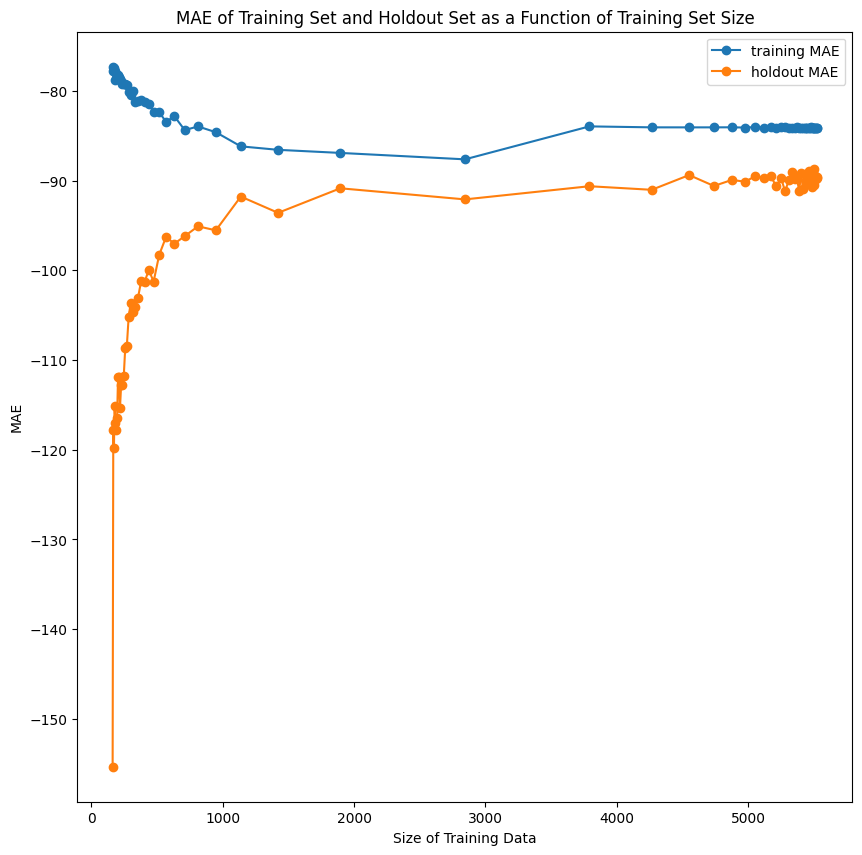

In [386]:
plot_learning_curve(full_model, 
                    final_data,
                    max_k=35,
                    output=False,
                    scoring='MAE',
                    lambda_best=lambda_best_model_1)

In [92]:
historical_external_cols = extract_col_with_historical_values_from_df(train_data_strat)

## 3.3 Residual Plot  <a name='bookmark3.3' />

<a href=#TOC>Back to ToC</a>

count    2844.000000
mean        0.000002
std       125.386311
min      -800.901000
25%       -41.531750
50%        20.890000
75%        70.336250
max       486.126000
Name: cost_text, dtype: float64

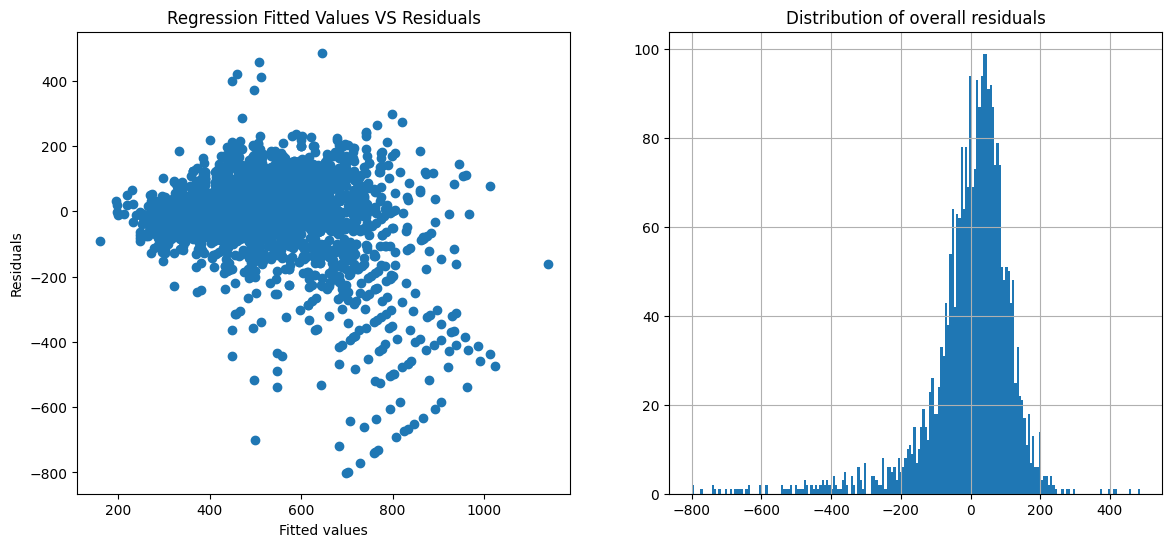

In [93]:
fitted_vals_and_residuals_first_model = residual_plot(best_model_choice_in_train_with_MAE['potentially_best_model_fitted'], 
              train_data_strat_preproc.drop(columns='cost_text').values, 
              train_data_strat_preproc['cost_text'])

In [394]:
residuals_and_suburb = pd.DataFrame(final_data['suburb']).merge(
    pd.DataFrame(fitted_vals_and_residuals_first_model['residuals']),left_index=True,right_index=True
).rename(columns={'cost_text':'residuals_first_model'})

#find the mean of residuals per suburb
residuals_and_suburb = residuals_and_suburb.groupby('suburb')['residuals_first_model'].mean().reset_index()

#standardize the residuals
residuals_and_suburb.loc[:,'residuals_first_model'] = stats.zscore(residuals_and_suburb.loc[:,'residuals_first_model'])



# geopandas_plotting(residuals_and_suburb, 
#                        sf=vic_shapefile_no_duplicates, 
#                        legend_name='Residuals of first model across suburbs', 
#                        col_to_be_plot='residuals_first_model',
#                        save=False,
#                        saved_map_name='',
#                        map_format='html')

Briefly inspect suburbs that have unusually high residuals

In [395]:
residuals_and_suburb.sort_values(by='residuals_first_model')

suburb  residuals_first_model
1      albert park              -5.801822
101    mount eliza              -2.785362
11       beaumaris              -2.574976
99      mornington              -2.568967
29   carlton north              -2.446483
..             ...                    ...
123  roxburgh park               1.571654
57      flemington               1.818729
122       rowville               1.839931
2        alfredton               1.881684
136       sydenham               2.028044

[153 rows x 2 columns]

Investigate properties in albert park since on average our model doesn't seem to explain the rental price in albert park as well as the other propreties.

One way to do this is to inspect the values of some of the features, and then compare to those in properties situated in albert park.

array([[<AxesSubplot:title={'center':'nearest_hospital'}>,
        <AxesSubplot:title={'center':'nearest_train_station'}>],
       [<AxesSubplot:title={'center':'distance_to_cbd'}>,
        <AxesSubplot:title={'center':'cost_text'}>]], dtype=object)

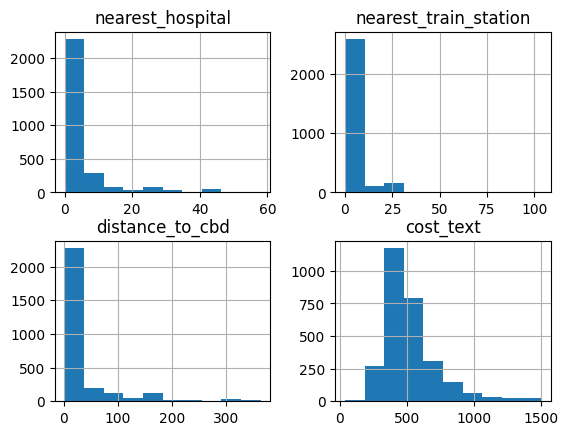

In [392]:
train_data_strat[['nearest_hospital', 'nearest_train_station', 'distance_to_cbd','cost_text']].hist()

In [393]:
train_data_strat[train_data_strat['suburb'] == 'albert park']\
        [['nearest_hospital', 'nearest_train_station', 'distance_to_cbd','cost_text']].agg('mean')

nearest_hospital           44.701475
nearest_train_station      12.375775
distance_to_cbd             5.651850
cost_text                1085.000000
dtype: float64

Since the average residuals for albert park is negative, with residuals defined as <code>actual_y - predicted_y</code>, our predictions for albert park, therefore, are on average, overestimated. 
- Also their average rental price per week is 1085, which lies somewhere on the 90-th percentile in the distribution fo the rental price. 


## What can we say about the first model <a name='first_model_remark' />
## 1. From the Learning Curve
It's probably the right choice to use <code>ElasticNet()</code> (i.e. penalized regression) since we have limited evidence on overfitting (as the training samples get larger their "accuracy"/score, defined by -1 * MAE, begin to converge). Hence, we have evidence that we don't have to deal as much with model variance. 

- As for the case of whether it is biased or not (i.e. whether deviating predictions by, on average, 90 dollars is too much or not), one can argue that since 90 lies on the left tail of the overall distribution of the rental price, it's probably not that biased. But we can always try to improve the model by feature engineering to see if we can reduce model bias, provided that we've selected the right model to reduce model variance.



## 2. From the residual plots
- There is still a small trend in that as the fitted vlues increase the predictions tend to be underestimated. 

## What's Next? 
- We further peform EDA, mainly by pairwise plots or correaltion plots, to look for which features to be combined.


# 4. Further Feature Engineering<a name='bookmark4' />

<a href=#TOC>Back to ToC</a>

## For the external columns, instead of keeping them as is, we could just transform them into annual (or even a custom specified time-lag) increases of each external variable to further reduce multicollinearity
- E.g. if we want to take 1-year increases of each external variable we would do <code>2000_median_rent and 2001_median_rent --> df[2001_median_rent] - df[2000_median-rent]</code>

Beware: <code>population_</code> and <code>population_density</code>

In [97]:
def compute_time_lag_increase_historical_external_cols(data, TIME_LAG=1):

    """
    
    PART OF FEATURE ENGINEERING.
    For each external columns that are historical, which
    I define as containing numerical years
    (e.g. 2000_median_rent), to prevent autocorrelation between
    them we compute the TIME_LAG-year increase of them. 
    
    E.g. if TIME_LAG = 1, instead of retaining 2000_median_rent 
    and 2001_median_rent, we compute the TIME_LAG-year increase 
    of median rent from 2000 instead. 
    
    
    """
    
    data_no_external = data.loc[:,~data.columns.str.contains('\d')].copy()
    
    historical_col_annual_increase = pd.DataFrame()

    for i in range(len(historical_external_cols)):
        
        conditions_for_extracting_this_historical_external_col =\
            (data.columns.str.contains('\d')) &\
            (data.columns.str.contains(historical_external_cols[i]))

        if 'population' in historical_external_cols[i]:

            if 'density' not in historical_external_cols[i]:
                is_pop_but_not_pop_density = ~data.columns.str.contains('density')
                conditions_for_extracting_this_historical_external_col =\
                    conditions_for_extracting_this_historical_external_col & is_pop_but_not_pop_density

        one_historical_cols = pd.DataFrame(

            data.loc[:,
                conditions_for_extracting_this_historical_external_col
            ].columns,

            columns=[historical_external_cols[i]]
        )

        #extract the year from a historical external column (e.g. extract '2000' from '2000_median_rent')
        one_historical_cols['years'] = one_historical_cols.iloc[:,0].str.findall('\d+').map(lambda x: x[0]).astype('int64')

        #use year as index: ultimately this will be a dictionary with the years as the keys.. 
        #this will be useful later when we want to obtain the annual increase
        one_historical_cols = one_historical_cols.set_index('years').sort_index().iloc[:,0]


        #START COMPUTING INCREASE

        years_curr_historical_col = one_historical_cols.index

        #display(years_curr_historical_col)


        for j in range(TIME_LAG, len(years_curr_historical_col)):

            year = years_curr_historical_col[j]
            prior_year = years_curr_historical_col[j-TIME_LAG]

            annual_inc_prior_year = data[one_historical_cols[year]] -\
                            data[one_historical_cols[prior_year]]

            annual_inc_col_name = f'{historical_external_cols[i]}_inc_from_{prior_year}_to_{year}'

            #add this annual increase to historical_col_annual_increase
            historical_col_annual_increase[annual_inc_col_name] = annual_inc_prior_year
    
    return pd.concat([data_no_external, historical_col_annual_increase], axis='columns')


# 4.1 Visualise relationship between response and each transformed external variable (into annual increases) <a name='bookmark4.1' />

<a href=#TOC>Back to ToC</a>

<AxesSubplot:>

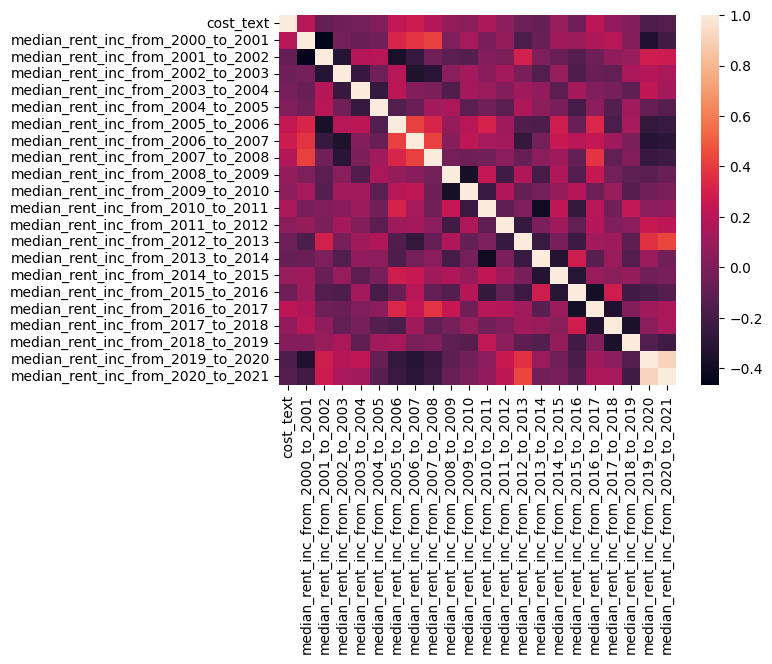

In [189]:
sns.heatmap(extract_cost_text_and_historical_var_in_external_train(
    compute_time_lag_increase_historical_external_cols(train_data_strat, TIME_LAG=1), 
    'median_rent').corr())

<AxesSubplot:>

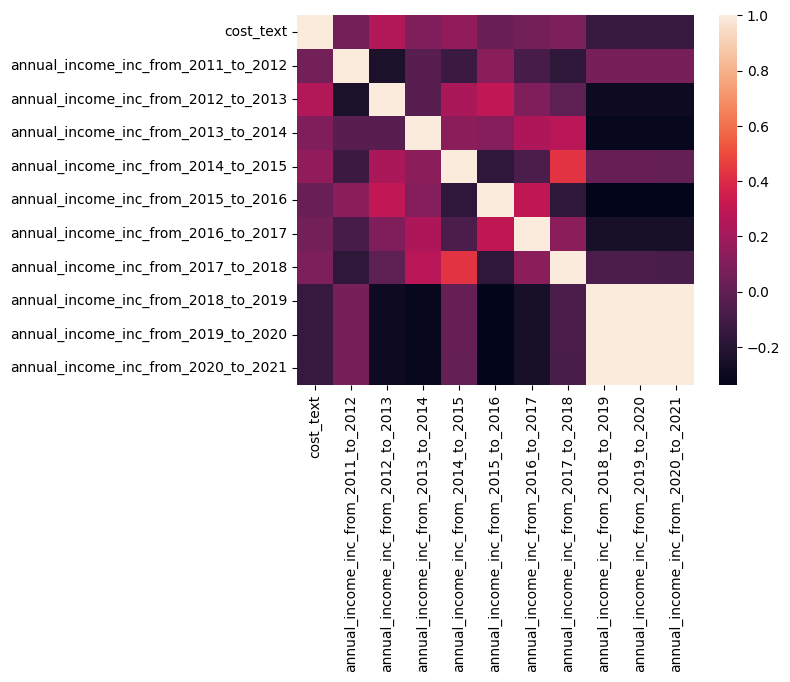

In [215]:
sns.heatmap(extract_cost_text_and_historical_var_in_external_train(
    compute_time_lag_increase_historical_external_cols(train_data_strat, TIME_LAG=1), 
    'income').corr())

<AxesSubplot:>

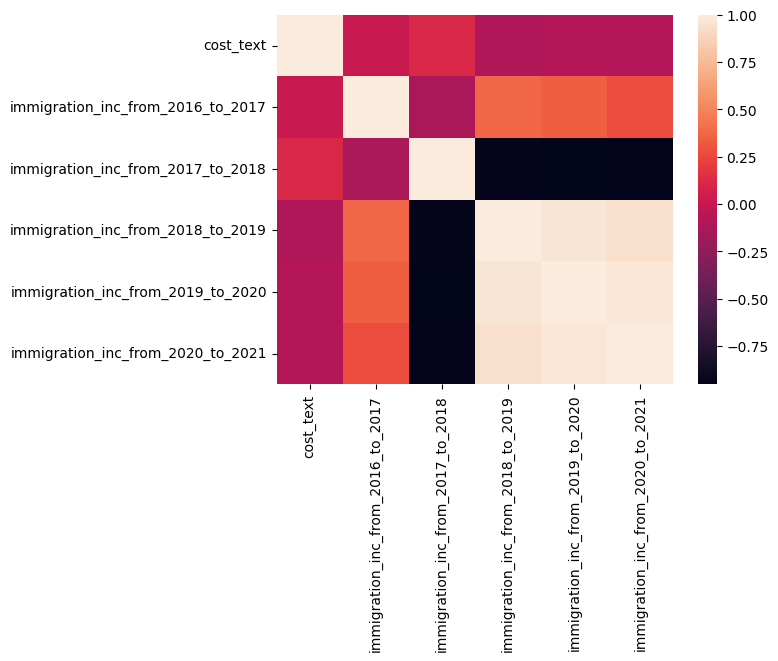

In [216]:
sns.heatmap(extract_cost_text_and_historical_var_in_external_train(
    compute_time_lag_increase_historical_external_cols(train_data_strat, TIME_LAG=1), 
    'immigration').corr())

## What do these heatmaps infer?

Compared to the "raw" external features over the years plotted against each other, taking their annual increase instead decreases multicollinearity. 

I hope that this will improve the performance of the model.

# 4.2 Pairwise plot of internal features for any possible transformation <a name='bookmark4.2' />

<a href=#TOC>Back to ToC</a>

We re-(Pairwise) plot against internal features, NO transformation applied at all <a name='raw_internal_plot' />

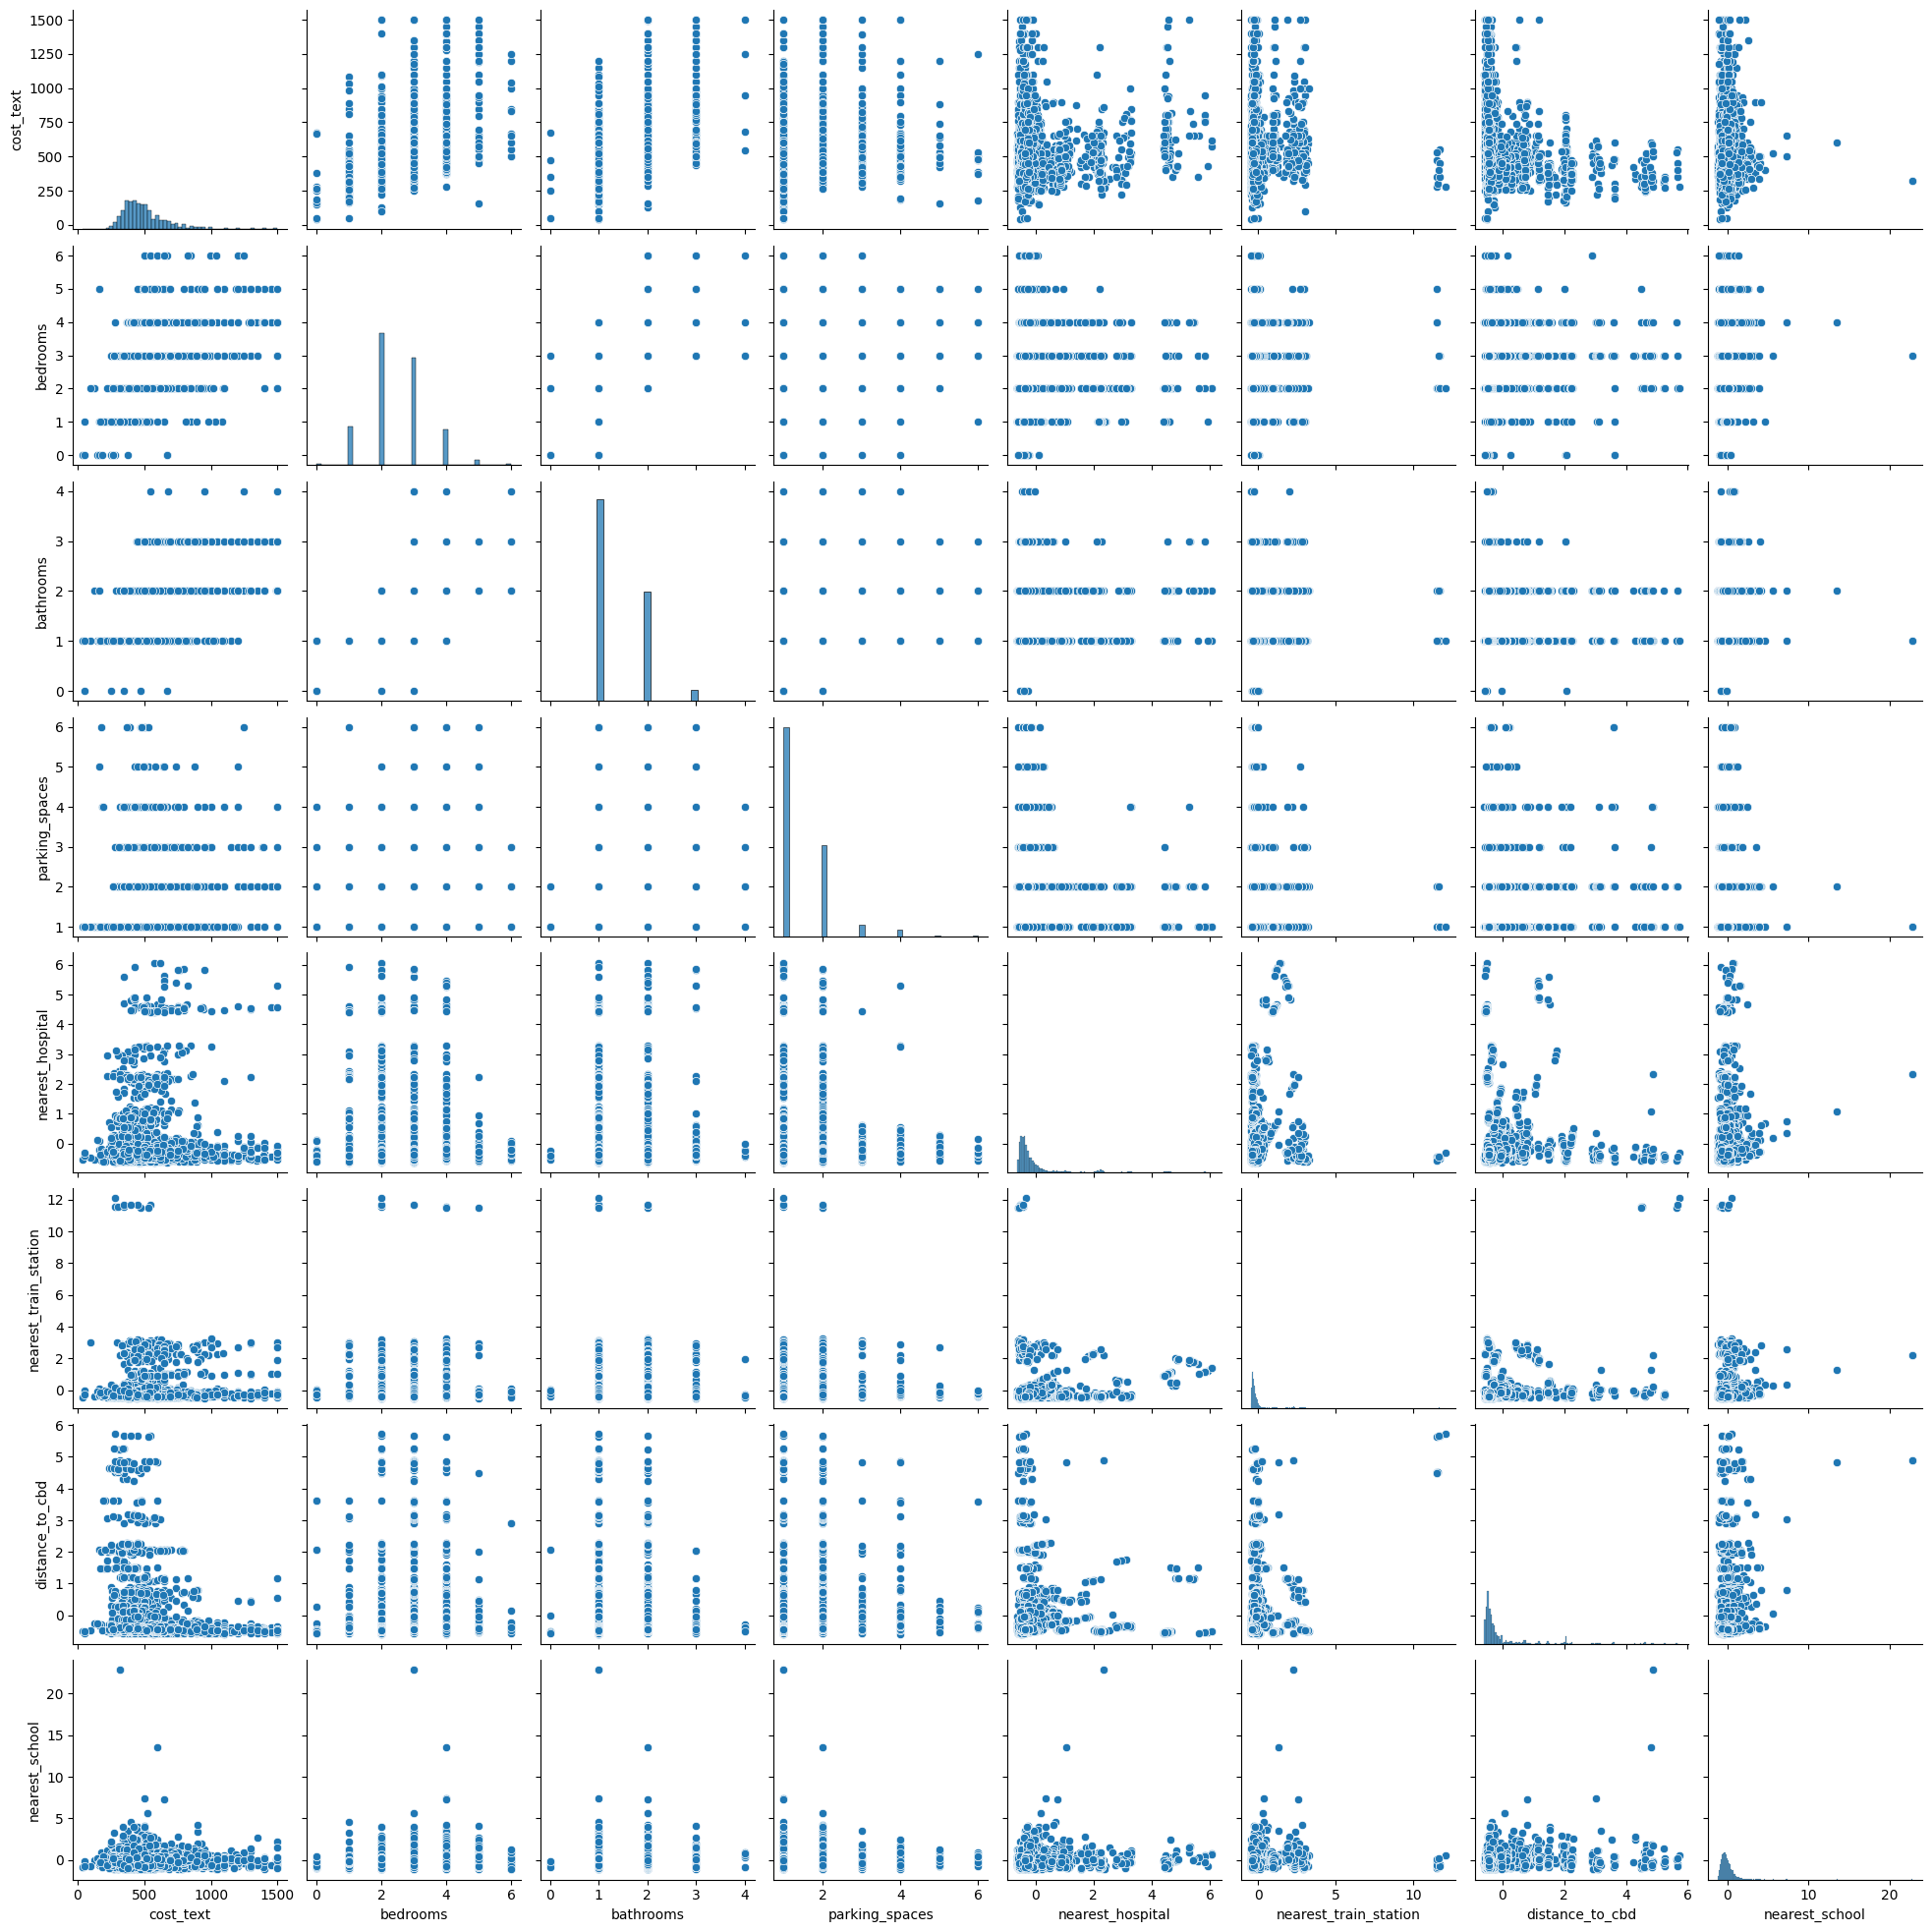

In [100]:
sns.pairplot(
        #standardize them first
        standardize_all_continuous_numeric_vars( #locate all internal + proximity features
            train_data_strat.loc[:,~train_data_strat.columns.str.contains('\d')]
        )[0].drop(columns='suburb')
)

As noted in the first EDA, It *seems* that the distances (<code>['nearest_hospital', 'nearest_train_station', 'distance_to_cbd', 'nearest_school']</code>) have some kind of inverse relatinoship with rental price, with <code>distance_to_cbd</code> the most evident.

In [231]:
def variable_transformation(row):
    
    proximity_cols = ['nearest_hospital', 'nearest_train_station', 
                       'distance_to_cbd', 'nearest_school']
    
    #1. Maybe we can log the response.
    
    #distribution of response is skewed, and 
    #probably expect the same trend given the explanatory
    #variables. So try to take log of it. 
#     row['cost_text'] = np.log(row['cost_text'])
    
    #2. prevent zero division error, in case a very small
    #proximity value is trunacted to 0 
    
    e = 0.0001 
    proximity_cols = ['nearest_hospital', 'nearest_train_station', 
                      'distance_to_cbd', 'nearest_school']
    
    row[proximity_cols] = 1 / (row[proximity_cols] + e)
    
    #3. distribution of proximity variables are skewed. Better take log 
    #as well to not have values more dense in the region closer to 0.
    
    for col in proximity_cols:
        row[col] = np.log(row[col])
    
    return row[proximity_cols + ['cost_text']].drop(columns='suburb')
    return row.drop(columns='suburb')

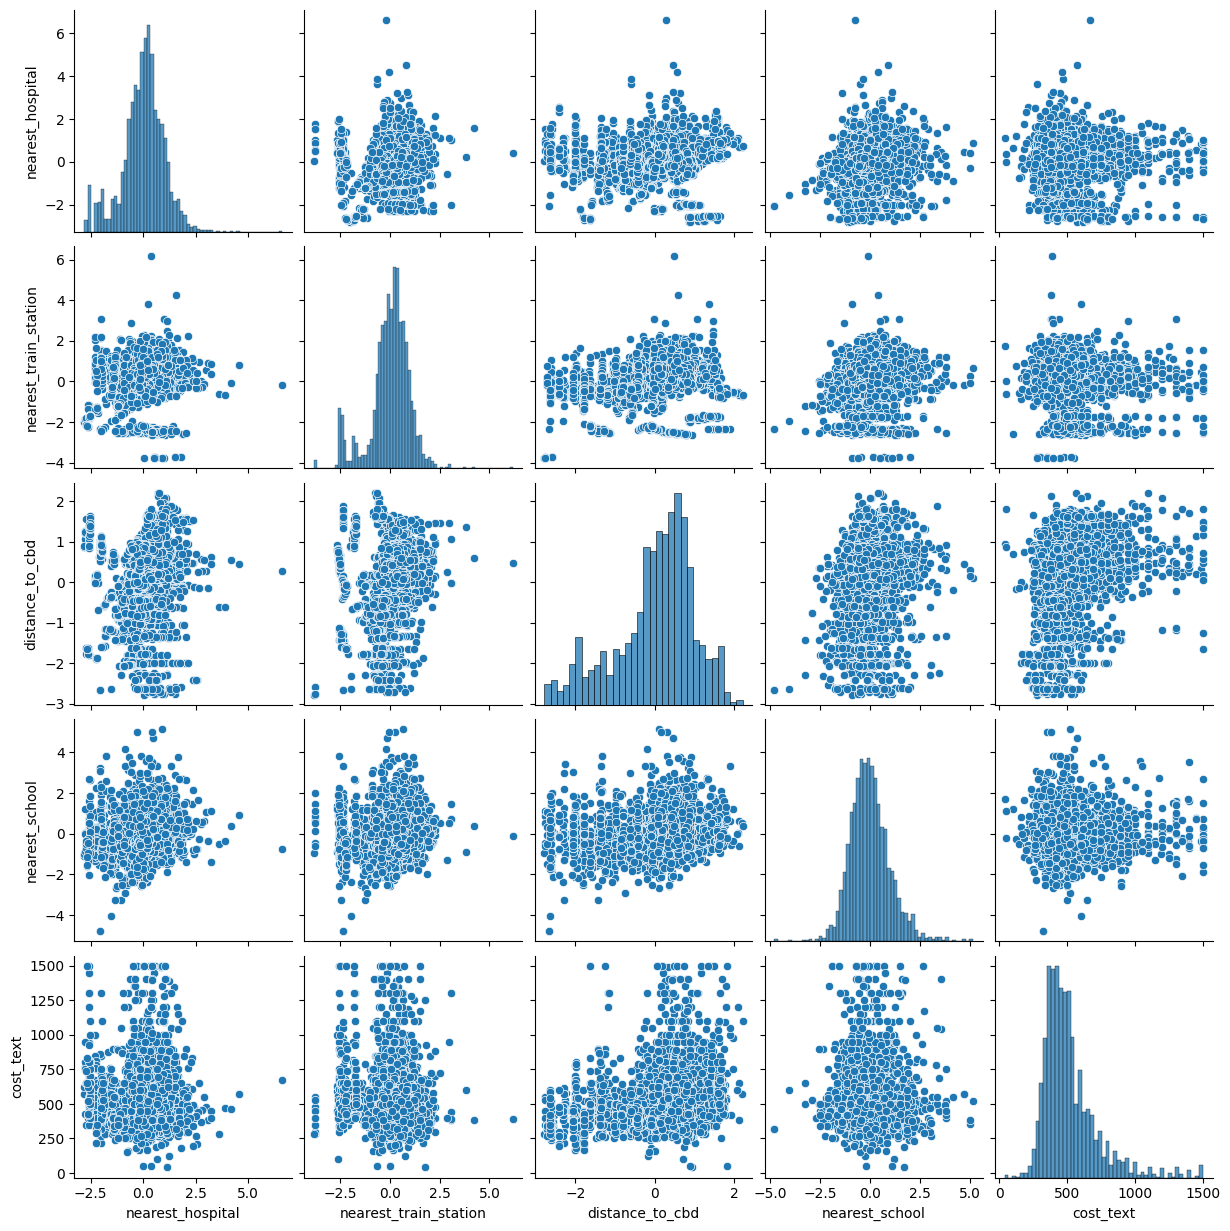

In [232]:
sns.pairplot(
        #standardize them first
        standardize_all_continuous_numeric_vars(
            
            #locate all internal + proximity features
            train_data_strat.loc[:,~train_data_strat.columns.str.contains('\d')].\
                apply(
                    lambda row: variable_transformation(row), axis='columns'
                )
            
        )[0]
)

<a href='#raw_internal_plot'>Based on this plot (distance to cbd vs cost text), it seems that it has the most evident inverse linear relationship</a>

In particular, transforming <code>distance_to_cbd</code> into <code>np.log(1 / (train_data_strat_copy[col]))</code> and transforming the response variable into log-scale yields:

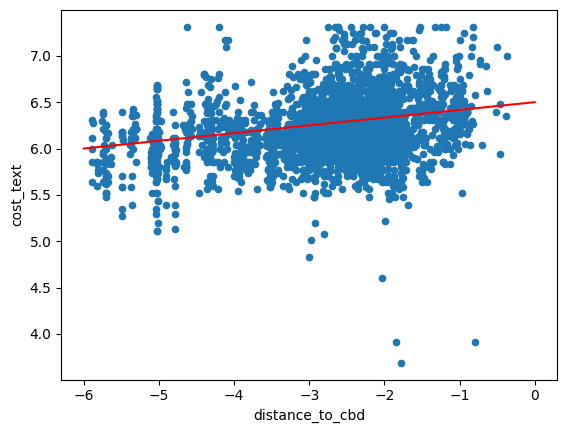

In [226]:
#note that the x-axis should be log(1/distance_to_cbd), or in layperson terms, the proximity to cbd
train_data_strat_copy = train_data_strat.copy()
col = 'distance_to_cbd'
train_data_strat_copy[col] = np.log(1 / (train_data_strat_copy[col] + 0.001))
#train_data_strat_copy['distance_to_cbd'] = 1 / (train_data_strat_copy['distance_to_cbd'] + 0.001)
train_data_strat_copy['cost_text'] = np.log(train_data_strat_copy['cost_text'])

train_data_strat_copy.plot.scatter(x=col,
                                   y='cost_text')
plt.plot([-6, 0], [6, 6.5],color="red")

## Justification for Feature Enginnering some of the Internal Variables and the response
1. First I take the inverse of distance to cbd, but then the values of distance to cbd are clumped around 0.
    
2. So I take the log to make it spread out. 
    
3. Also since there are so many instances with proximities (school, hospital, nearest train station) close to 0, I decided to take log of the response as well to avoid heteroscedasicity</font>

# 4.3 Try to do some feature engineerings as specified below: <a name='bookmark4.3' />

- Log cost_text
- log(1/distance to cbd + small_number)
- time lag 1 year increase for historical external features


<a href=#TOC>Back to ToC</a>


In [104]:
def variable_transformation_for_fitting(row):
    
    row['cost_text'] = np.log(row['cost_text'])
    
    e = 0.0001 
    
    row['distance_to_cbd'] = np.log( 1 / (row['distance_to_cbd'] + e) )
    
    
    return row

In [105]:
def feature_engineering_1(df,
                          with_external_vars=True,
                          TIME_LAG=1):
    
    df_output = df.copy()
    
    if with_external_vars == True:
        df_output = compute_time_lag_increase_historical_external_cols(df_output, 
                                                                       TIME_LAG=TIME_LAG)
    
    df_output = df_output.apply(
        lambda row: variable_transformation_for_fitting(row), axis='columns'
    )
    
    return df_output
    
    

# 4.4 Fitting Model given the feature engineerings [1) time lag for historical external vars 2) transformation for distance to cbd variable 3) log response variable] <a name='bookmark4.4' />

<a href=#TOC>Back to ToC</a>

Try to fit the 2nd model, given feature engineerings

In [106]:
#preprocess feature engineered training data (standardizing numerical columns and OH encode nominal variables)
train_data_strat_preproc_feature_eng_1 = preprocess_vars_for_train(feature_engineering_1(train_data_strat), 
                                                                   encode_ordinal=True)

#obtain the best hyperparameters + fit the model 
best_model_choice_in_train_feat_eng_with_MAE = best_penalty_method_elastic_net(train_data_strat_preproc_feature_eng_1,
                                      n_splits=10,
                                      scoring='mean_absolute_error',
                                      random_state=1)


How well does the second model fits our training data?

In [166]:
best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'].score(
    train_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values,
    train_data_strat_preproc_feature_eng_1['cost_text']
)

array(0.69025006)

How well does the second model predicts our test data?

In [108]:
test_data_strat_preproc_feature_eng_1 =\
    preproc_transform_test_data(feature_engineering_1(test_data_strat), feature_engineering_1(train_data_strat))

In [171]:
best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'].score(
    test_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values,
    test_data_strat_preproc_feature_eng_1['cost_text']
)

array(0.63755159)

In [411]:
#obtain the best lambda (penalty weight) for our second model
lambda_best_model_2 = best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'].lambda_best_[0]
lambda_best_model_2

0.13864249290757513

Do a K-fold cross validation

In [ ]:
k_fold_CV(
    feature_engineering_1(final_data), 
    7, 
    best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model'],
    shuffle_data=False,
    swap_train_test=False,
    retransform_log_y=True,
    lambda_best=lambda_best_model_2
)

In [313]:
# stupid idea: 100 CV to increase actual gap between train and test scores
hundred_fold_scores_2nd_model_full_data = k_fold_CV(
    feature_engineering_1(final_data), 
    100, 
    best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model'],
    shuffle_data=False,
    swap_train_test=False,
    retransform_log_y=True,
    lambda_best=lambda_best_model_2
    
)

display(np.mean(hundred_fold_scores_2nd_model_full_data[0]), 
       np.mean(hundred_fold_scores_2nd_model_full_data[1]))

Scores for test folds:  [ -63.74218839  -43.88041526  -53.36005242  -44.41284764 -114.00911417
  -93.10270641  -67.25221158  -69.27663801  -92.77003193 -104.49966392
  -76.63212592  -69.69827456 -101.13752296 -109.90252467  -74.43567035
  -61.1547475   -58.37307115  -70.51673115  -55.84817356  -65.15338333
  -50.4500177   -57.90842608  -56.24384298  -69.94398671  -54.4807396
  -37.21354022  -94.10311143  -93.3877043   -91.52444868  -68.1143129
  -67.68807174 -121.58895617  -93.91946757 -115.99282642  -89.98142559
 -104.24528135 -114.08971038 -108.80511927  -86.43276261  -43.81547111
  -84.82346336  -65.46548672 -141.24259343  -69.19797487  -93.44409858
 -141.47820716  -79.28480606  -86.3710612  -105.1011662  -132.42360511
 -162.42024751  -57.80159683 -121.62743353  -54.01078206  -55.88392043
  -73.68653224  -47.79275393 -116.91231299 -125.32264294  -70.12086606
  -82.62948368  -68.022659    -92.74096629  -78.93427981  -95.2452375
  -84.90076671  -65.99963654  -76.24626332  -57.15781631

-82.08202139102568

-75.84959256366946

# 4.5 Learning Curve for Second Model <a name='bookmark4.5' />

<a href=#TOC>Back to ToC</a>

Scores for test folds:  [-160.16566436 -169.83168452 -117.50307378 -138.72603896 -137.46856262
 -124.21126043 -270.20503824 -114.96733519 -108.18876884 -115.6717442
 -130.46021294 -121.97909712 -111.07201727 -120.52700259 -105.24976603
 -186.74959234 -101.50300819 -122.6476149  -311.48016968 -143.52768542
 -112.82288788 -140.04767642 -128.56556619 -106.89770014 -127.59430117
 -223.04744803  -95.82953318 -362.59253669 -123.30940357 -107.30179843
  -99.85686723 -126.74958226 -103.1938821  -160.28444551 -148.28863991]


Scores for training folds:  [ -49.64575521  -56.01401141  -65.81979016  -61.85554935  -74.45703232
  -56.94673719  -57.81959806  -52.09492907  -49.23005428  -75.28665467
  -73.9457984   -77.31959186  -85.54451479  -60.02068254  -89.79883989
  -65.21316415  -83.37360054  -97.22551455  -64.51239467  -56.47697075
  -81.42655612  -74.38722452  -69.0372913   -55.91509195  -61.81524129
  -43.12409344  -69.88178603 -113.23428474  -60.0166959   -74.7354101
  -62.98489477  -91.8262

Scores for test folds:  [-156.16464791 -115.39676033 -136.1031525  -121.04283903 -502.70481591
 -108.15375404 -115.49816533 -122.16024565 -119.35414706 -102.17364909
  -97.33690169 -157.67389822 -101.03345345 -112.68457279 -121.00582063
 -116.4884958  -152.53888666 -107.85227922 -124.56478857 -142.51176017
 -120.57057821 -108.38969009 -110.20205342 -120.74493369 -104.09079612
 -114.13770956]


Scores for training folds:  [ -45.26406658  -60.32768211  -65.14606185  -75.18329311  -56.4683998
  -55.68899567  -54.44833465  -66.45143099  -80.17417106  -86.70896206
  -77.45211096  -72.90877582  -95.59597129  -76.35134451  -66.37339516
  -71.6493012   -76.93230326  -55.69476694  -56.55173301  -62.02407885
 -104.53490519  -68.23446384  -68.90753019  -98.596925    -65.84829258
  -61.7100801 ]
train_size for above: 218(3.85%)


Scores for test folds:  [-153.93500951 -115.02227084 -154.84000546 -125.65133658 -290.02726313
 -106.20962028 -113.05009511 -113.00477085 -115.75880624  -98.51228857
  -9

Scores for test folds:  [-117.78478874 -123.39701036 -126.06469847 -105.29933252  -97.92228834
  -94.4421993   -98.35888979 -117.30412855 -102.49185012  -97.84792387
 -104.42114562 -104.83732906 -108.04213326]


Scores for training folds:  [-57.73783523 -71.47989095 -56.88206614 -62.46547528 -85.94130298
 -76.18353208 -88.36060506 -72.18403426 -65.92219722 -61.9169898
 -88.82769175 -84.21400228 -67.34123283]
train_size for above: 437(7.69%)


Scores for test folds:  [-118.06027371 -124.12578097 -113.13409672  -98.78492091  -95.49888349
  -95.48334872 -114.88689134 -104.05180351 -118.48798148  -99.01542026
 -104.47810283 -107.58529983]


Scores for training folds:  [-59.62824092 -71.65834761 -56.04036327 -74.89914137 -74.46006944
 -94.55917567 -76.51552774 -72.58897977 -58.24215627 -83.46718019
 -85.77374361 -66.65493051]
train_size for above: 474(8.33%)


Scores for test folds:  [-119.5077641  -163.85713491 -101.8236419  -113.65712322  -93.36312496
  -98.45785631 -135.9114003  -124.492

Scores for test folds:  [ -65.66419811  -78.79791711  -81.52390841  -66.91384392  -79.9134574
  -97.48892309  -91.18453071 -107.81177117 -110.25711394  -96.4295687
  -91.42150942  -65.36276312  -85.3687119  -119.08827581  -79.12955945
  -95.30518693  -80.10276129]


Scores for training folds:  [-76.61457839 -76.19338649 -75.93817767 -76.83168371 -76.50540417
 -75.29153877 -75.79100989 -75.18869211 -74.07574288 -76.06342074
 -75.45693745 -76.76078614 -76.43309506 -74.87689703 -75.76417992
 -75.0509868  -76.18219102]
train_size for above: 5355(94.12%)


Scores for test folds:  [ -63.01031099  -81.04403802  -85.0973481   -68.78165344  -75.55322029
  -98.49717672 -101.05831642  -95.49454284 -122.06773671  -77.31811558
  -93.1411512   -87.11441083  -71.41599097  -78.71886772  -96.37072923
  -81.1449093   -94.76806818  -80.06530925]


Scores for training folds:  [-76.65295871 -76.07536122 -75.88308478 -76.81864031 -76.64525036
 -75.37602387 -75.33306385 -75.37136496 -74.25675654 -75.87533093

Scores for test folds:  [ -52.0318682   -75.914848    -84.91707963  -98.0692859   -63.67842741
  -73.10317566  -62.08290294  -77.15999593  -83.55807162 -104.00215092
 -119.77968529  -70.31947605 -103.96462569  -99.77408498 -119.52833707
  -69.73207266 -122.12529449  -84.91130306  -89.28538238  -64.12800748
  -76.23761441  -70.1318098  -146.22651384  -79.58388616  -82.92344806
  -85.96173637 -100.94667675  -69.55690341  -81.44951875]


Scores for training folds:  [-76.59885313 -75.96474599 -76.0268597  -75.56382292 -76.34860865
 -76.35915679 -76.35287913 -76.4364     -75.95605005 -75.30679243
 -74.9952368  -76.51554153 -75.05379532 -75.51230049 -74.67848402
 -76.0707722  -75.64995895 -75.80138343 -75.70885509 -76.47200691
 -76.20703183 -76.30897675 -74.56253293 -75.97178071 -75.77183461
 -75.62080874 -75.25963586 -76.08439786 -76.16380544]
train_size for above: 5493(96.55%)


Scores for test folds:  [ -53.80000081  -75.07075778  -84.66683673  -94.40497518  -65.90008067
  -64.14195055  -

/tmp/ipykernel_77/3184143871.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_scores = np.array(test_scores)
/tmp/ipykernel_77/3184143871.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_scores = np.array(train_scores)


[array([-68.94466418, -69.27175306, -69.05288159, -69.76897365,
        -70.23022875, -69.73994898, -69.87177122, -70.06044859,
        -70.01172741, -70.20105292, -70.42293161, -70.46790702,
        -70.86907298, -70.64026619, -70.94842618, -71.39534271,
        -71.49149476, -71.39406474, -72.07615373, -72.09458127,
        -72.04274112, -72.38044994, -72.26591199, -72.87398803,
        -72.94838754, -73.55254412, -73.21947823, -74.11981563,
        -73.95927638, -74.6858232 , -75.20601775, -76.11891276,
        -76.46602981, -78.35700375, -75.54469651, -75.71897773,
        -75.73520024, -75.7723523 , -75.77443868, -75.79838822,
        -75.74599733, -75.81794993, -75.81076999, -75.81401208,
        -75.79971952, -75.81806084, -75.81882245, -75.8212456 ,
        -75.8246299 , -75.80590102, -75.82208194, -75.82775825,
        -75.82882583, -75.83280773, -75.83188635, -75.83254273,
        -75.83040486, -75.83206899, -75.81941994, -75.83576166,
        -75.83873477, -75.83390069, -75.

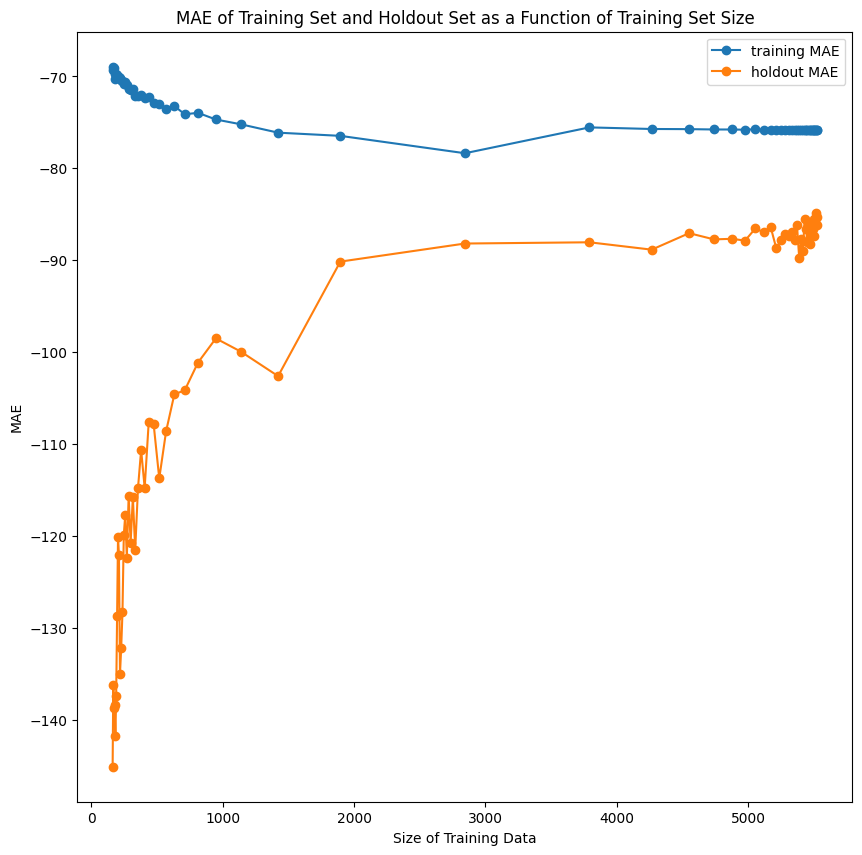

In [379]:
plot_learning_curve(best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model'], 
                    feature_engineering_1(final_data), 
                    max_k=35, 
                    output=False,
                    retransform_log_y=True,
                    lambda_best=lambda_best_model_2)

In [167]:
best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'].lambda_best_

array([0.13864249])

# 4.6 Residuals for Training data in Second Model <a name='bookmark4.6' />

<a href=#TOC>Back to ToC</a>

In [423]:
help(residual_plot)

Help on function residual_plot in module __main__:

residual_plot(model_fitted, X, y, lambda_best=None, retransform_log_to_exp=False)
    Residual plot of a regression model
    'model'. 
    
    model_fitted, as the name suggests, should 
    be a model object THAT HAS BEEN FITTED to 
    X using .fit().
    
    X is the preprocessed train data,
    response MUST BE excluded. X has to be a 
    2-D array representation of a DF. 
    
    y is the response corresponding to data
    in X. 
    
    If the model passed is not the fitted model on  
    training data, then model_fitted can be just a 
    regular ElasticNet() object with alpha specfied,
    BUT lambda_best has to be specified.



count    2844.000000
mean        0.000001
std         0.195155
min        -0.893000
25%        -0.097000
50%         0.014000
75%         0.108000
max         2.057000
Name: cost_text, dtype: float64

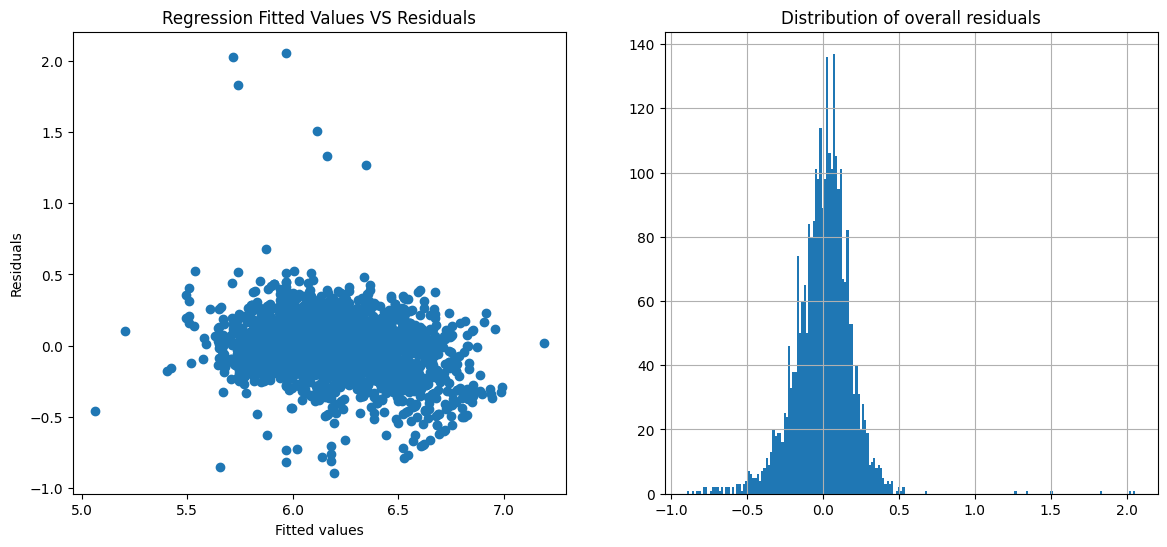

In [397]:
residuals_second_model = residual_plot(best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'], 
              train_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values, 
              train_data_strat_preproc_feature_eng_1['cost_text'])

In [407]:
#inspect the instances in the training data that have high residuals (for second model)
train_data_strat.loc[
    residuals_second_model['residuals'].sort_values(ascending=False).head(6).index,
    :
]

cost_text     suburb  bedrooms  bathrooms  parking_spaces  \
2799       50.0   st kilda         1          1               1   
3296       40.0    prahran         0          1               1   
4490       50.0  southbank         0          0               1   
1779      100.0        kew         2          1               1   
5301      125.0   box hill         2          2               1   
4678      160.0    burwood         5          2               5   

      nearest_hospital  nearest_train_station  distance_to_cbd  \
2799            2.8352                 1.8737           6.3334   
3296            0.8303                 0.3029           5.9146   
4490            1.9218                 3.7137           2.2215   
1779            1.4036                29.1150           7.6162   
5301            0.7483                 0.8801          20.2076   
4678            6.1769                 4.7567          16.5033   

      nearest_school  2000_median_rent  ...  2012_unemployment_rate  \
2799          0.3659             196.5  ...                     4.5   
3296          0.2440             240.0  ...                     3.7   
4490          0.8933             335.0  ...                     2.3   
1779          0.3404             250.0  ...                     2.9   
5301          0.9269             190.0  ...                     7.0   
4678          0.4503             210.0  ...                     6.9   

      2013_unemployment_rate  2014_unemployment_rate  2015_unemployment_rate  \
2799                     6.3                     7.1                     5.7   
3296                     5.1                     5.9                     5.3   
4490                     2.4                     2.7                     2.1   
1779                     3.0                     3.9                     4.3   
5301                     8.2                     9.6                     9.6   
4678                     8.5                     9.0                     9.8   

      2016_unemployment_rate  2017_unemployment_rate  2018_unemployment_rate  \
2799                     5.1                     5.8                     5.1   
3296                     3.8                     4.2                     3.3   
4490                     1.8                     2.1                     1.8   
1779                     4.0                     3.8                     3.3   
5301                     9.6                     9.7                     7.7   
4678                     9.9                    10.3                     8.1   

      2019_unemployment_rate  2020_unemployment_rate  2021_unemployment_rate  
2799                     5.8                     6.8                     5.8  
3296                     3.6                     5.3                     3.9  
4490                     1.7                     3.2                     3.5  
1779                     3.1                     4.8                     4.6  
5301                     7.2                     7.2                     9.0  
4678                     8.1                     7.7                     9.4  

[6 rows x 102 columns]

Not in table of content, but we can inspect coefficients

In [433]:
model_2_coeffs = pd.DataFrame(
    
    index=['Intercept'] + list(train_data_strat_preproc_feature_eng_1.drop(columns='cost_text').columns), 
    
    data=[best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'].intercept_] +\
                list(best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'].coef_), 
    columns=['Coefficient (MAE)']
)['Coefficient (MAE)']

# 4.7 What can we say about this model (second model)<a name='bookmark4.7' />

<a href=#TOC>Back to ToC</a>

## 1. From the Learning Curve
- It seems that our feature engineering techniques work in decreasing model bias (the training and testing curves lie on top of those in model 1, signifying higher scores achieved on average)

## 2. From the residual plots
- It seems that putting the rental price on a log-scale, and turn the log-scaled rental price as a response works in reducing heteroscedacisity (though, there's still some points that have high (log-scaled) residuals)

## What's Next? 
- However, despite the increase in model performance by converting the external variables into annual increases of them, do they actually have a proper semantic meaning in explaining the 2022 rental price? 
- How about we try to remove them and only using the internal features (with <code>distance_to_cbd = log(1/distance_to_cbd)</code>) instead? Will the performance downgrade much, or other outcomes?

- Also, a naive idea: since <code>ElasticNet()</code> also implicitly performs variable selection, we can try to refit model 2, but remove parameters that have sufficiently small coefficients. Looking at the parameters with smallest coefficients below:


In [447]:
abs(model_2_coeffs).sort_values().head(30)

population__inc_from_2012_to_2013            0.000042
population__inc_from_2015_to_2016            0.000175
population__inc_from_2011_to_2012            0.000227
immigration_inc_from_2020_to_2021            0.000313
population__inc_from_2001_to_2002            0.000373
population__inc_from_2005_to_2006            0.000375
population__inc_from_2017_to_2018            0.000408
annual_income_inc_from_2015_to_2016          0.000417
immigration_inc_from_2019_to_2020            0.000441
unemployment_rate_inc_from_2012_to_2013      0.000635
median_rent_inc_from_2001_to_2002            0.000670
median_rent_inc_from_2014_to_2015            0.000690
median_rent_inc_from_2013_to_2014            0.000914
population__inc_from_2016_to_2017            0.000925
population__inc_from_2006_to_2007            0.001057
population__inc_from_2004_to_2005            0.001164
suburb_benalla                               0.001180
population__inc_from_2014_to_2015            0.001213
nearest_school              

If have time, we can try to refit the second model, except we remove the variables for which coefficients above are less than 1e-3.

# 5. Third model: fit the same model above as model 2, but without the historical external variables <a name='bookmark5' />

<a href=#TOC>Back to ToC</a>

Feature engineering: 
- <code>dist_to_CBD = log(1/dist_to_cbd)</code>
- <code>cost_text = log(cost_text)</code>
- Remove all historical external variables

In [175]:
#feature engineer according to the specifications above, and remove all historical external variables
train_data_strat_feat_eng_but_no_externals = feature_engineering_1(train_data_strat,with_external_vars=False)

#remove all historical external variables
train_data_strat_feat_eng_but_no_externals = train_data_strat_feat_eng_but_no_externals.loc[:,
                    ~train_data_strat_feat_eng_but_no_externals.columns.str.contains('\d')]

In [177]:
#preprocess (standardize numerical variables + OH nominal variables) 
train_data_strat_preproc_feature_eng_without_external_vars = preprocess_vars_for_train(
                            train_data_strat_feat_eng_but_no_externals)

#and train the model
best_model_choice_in_train_feat_eng_no_externals_with_MAE =\
        best_penalty_method_elastic_net(train_data_strat_preproc_feature_eng_without_external_vars,
                                      n_splits=10,
                                      scoring='mean_absolute_error',
                                      random_state=1)


In [332]:
#make sure that the best model (not the fitted one), which is an ElasticNet() object with 
#hyperparameters specified, not the fitted model so that it can be passed to another training 
#data (e.g. when doing K-fold CV or plotting learning curve). 
best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model']

ElasticNet(alpha=0.0, n_splits=0, random_state=1, scoring='mean_absolute_error')

In [333]:
#what is the best lambda? 
lambda_best_model_3 = best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model_fitted'].lambda_best_

In [334]:
lambda_best_model_3

array([0.10487796])

In [181]:
#feature engineer final data before plotting learning curve and/or K-fold with it.
final_data_no_external_vars = feature_engineering_1(final_data, with_external_vars=False)
final_data_no_external_vars = final_data_no_external_vars.loc[:,~final_data_no_external_vars.columns.str.contains('\d')]

In [ ]:
# k_fold_CV(final_data_no_external_vars, 
#           7, 
#           best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model'], 
#           shuffle_data=False, 
#           swap_train_test=False, 
#           score='MAE',
#           display_entropy_suburbs=True,
#           lambda_best=lambda_best_model_3,
#           retransform_log_y=True
#          )

In [ ]:
# hundred_fold_cv_no_external_vars = k_fold_CV(final_data_no_external_vars, 
#           100, 
#           best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model'], 
#           shuffle_data=False, 
#           swap_train_test=False, 
#           score='MAE',
#           display_entropy_suburbs=True)
# print(hundred_fold_cv_no_external_vars[0].mean(), hundred_fold_cv_no_external_vars[1].mean())

# 5.1 Learning Curve for 3rd model <a name='bookmark5.1' />

<a href=#TOC>Back to ToC</a>

Scores for test folds:  [-129.16870253 -103.63958233 -115.16704248 -127.2856833  -101.35921875
 -112.16048288 -107.06356887 -105.72201208 -123.0982584   -98.81074438
 -148.02181986 -111.87554133 -116.30021187 -151.40311576 -106.40703366
 -180.86697166 -102.08535768 -106.02708423 -225.42152271  -97.99661837
 -102.91780638 -130.43419673 -136.45359624 -117.72976137 -125.36115993
 -160.9614022  -101.70974457 -253.85775615 -133.45275751 -114.9935859
 -105.39379684 -141.49380914 -104.1550832  -111.74059691 -103.97250778]


Scores for training folds:  [ -68.47760177  -61.1323274   -64.73122091  -73.29312901  -77.61531693
  -60.60889805  -58.1424359   -57.46334483  -49.20047649  -85.39986714
  -75.0042088   -77.94192251  -87.57112225  -70.17025759  -87.60192958
  -63.59952051  -88.7723656   -97.40834532  -65.07654914  -68.37674721
  -83.47655591  -73.90902782  -71.30316217  -55.73615524  -64.71549901
  -42.77545071  -87.78994826 -113.20020142  -65.10803341  -77.89391103
  -62.88699313 -104.272

Scores for test folds:  [-135.36752502 -105.72556288 -127.64356481 -112.63288947 -109.85022806
 -116.83236526 -116.08637332  -99.30989799 -111.22174067 -107.78425028
 -111.46530207 -151.67000568 -100.88357475 -122.08540118  -96.26493014
  -98.17717815 -111.25933952 -112.55036751 -112.62726112 -103.87108736
 -174.08253356 -112.17965539 -106.94922858 -110.41131862 -110.30889816
 -121.78417998]


Scores for training folds:  [ -66.13671364  -70.91818069  -73.27545424  -78.76414591  -57.53712876
  -60.21243756  -69.5082447   -76.24836691  -80.39886084  -93.6420675
  -87.84133591  -73.20426826  -98.44559565  -81.85205429  -76.36290974
  -75.91088001  -78.74051038  -57.75295     -58.41714416  -75.41008895
 -103.54453427  -73.02178883  -73.63916419 -120.70866296  -65.71932587
  -74.4304366 ]
train_size for above: 218(3.85%)


Scores for test folds:  [-134.1047704  -110.33455039 -128.34237883 -115.03209307 -107.20799531
 -103.4615507  -111.9919943  -122.82449538 -108.0416316  -117.54116413
 -10

Scores for test folds:  [-106.09667378 -106.69177217 -109.22624738 -100.46840632 -101.1974586
 -109.13858619 -100.69026214  -93.05152889 -104.09976697 -100.78946464
 -110.93237681  -96.65412288 -100.89806228]


Scores for training folds:  [ -79.04737273  -79.77311026  -65.41076278  -76.9631407   -99.83739248
  -92.62613245  -93.1791386   -85.65988627  -71.96609934  -74.38496421
  -96.18463912 -104.20584296  -76.75167954]
train_size for above: 437(7.69%)


Scores for test folds:  [-107.11364272 -108.16145286 -102.16066259  -95.06226775  -98.42686726
 -109.89843335  -95.62606249  -99.39222306  -99.67670077 -104.38105217
  -97.44292737  -99.66473415]


Scores for training folds:  [ -78.93037716  -80.55821747  -64.95018744  -90.45678083  -90.54266723
 -103.32660106  -91.772578    -77.13594074  -72.8597771   -98.09614524
 -102.3185      -76.11699215]
train_size for above: 474(8.33%)


Scores for test folds:  [-106.71634488 -107.24113272 -105.35607319  -99.25544669 -105.90305769
  -95.266725

Scores for test folds:  [ -89.51525778  -84.5756022   -87.73875265  -78.59201871  -99.09474542
  -92.92338983 -106.27673633 -111.3672064  -131.56159911  -97.73994672
  -96.38674673  -68.98184998 -110.36412031 -116.75785292  -86.13111586
 -115.66769077  -89.20237181]


Scores for training folds:  [-76.6077423  -76.29154824 -76.00653188 -76.89784863 -76.53480628
 -75.40773657 -75.78760235 -75.22814332 -74.1899075  -76.20584423
 -75.56113584 -76.86686669 -76.51521725 -75.14761108 -75.86131505
 -75.14026398 -76.23836789]
train_size for above: 5355(94.12%)


Scores for test folds:  [ -88.24925024  -87.15065013  -90.51079034  -79.79057562  -97.28294843
  -95.11181791 -110.12692348 -117.33943499 -125.03063988  -98.55080155
  -96.78623642  -95.20244663  -76.89615557 -104.19495062 -102.18244747
  -85.97691216 -105.7666941   -88.06616305]


Scores for training folds:  [-76.64366015 -76.16852302 -75.97072775 -76.87360575 -76.65441531
 -75.50741209 -75.37759959 -75.37342838 -74.34343575 -76.045485

Scores for test folds:  [ -70.15247144  -86.42325715  -94.51568763  -99.2823134   -75.44938872
  -75.72087157  -66.57390083 -107.2980701   -82.24306605  -97.0688119
 -130.26228786  -82.23294449 -126.03304438 -107.26652179 -132.80786348
  -76.16451835 -121.01552084  -82.65514527 -102.53989532  -61.76846194
  -79.60903776  -97.74758086 -146.58746321  -90.31880653  -93.08394078
 -103.19122579 -114.52118114  -79.12275447  -92.37652336]


Scores for training folds:  [-76.6268554  -76.00401208 -76.11414385 -75.66406855 -76.3895544
 -76.44449732 -76.40608652 -76.44772758 -76.05578403 -75.41295213
 -75.02429161 -76.54531737 -75.03162289 -75.58807473 -74.7665943
 -76.20469089 -75.73275614 -75.9329582  -75.7673172  -76.57053066
 -76.30671041 -76.35803147 -74.8185164  -76.03876903 -75.86275032
 -75.69059032 -75.34615934 -76.1780967  -76.20758306]
train_size for above: 5493(96.55%)


Scores for test folds:  [ -73.85366816  -85.77639454  -94.66332958  -95.30009764  -74.42267733
  -63.26530917  -81.

/tmp/ipykernel_77/3184143871.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_scores = np.array(test_scores)
/tmp/ipykernel_77/3184143871.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_scores = np.array(train_scores)


[array([-72.84383115, -73.98117885, -73.6035729 , -75.03960656,
        -75.54378646, -75.09718566, -75.15085578, -76.05854313,
        -76.12481592, -76.98627888, -76.77628092, -78.44579757,
        -77.69004987, -78.35275698, -78.67245984, -80.15721957,
        -79.6675    , -80.62105705, -81.52305398, -82.28446005,
        -82.2951313 , -83.31520488, -84.3069355 , -85.58873037,
        -83.69194461, -86.16089609, -85.41619462, -88.07421698,
        -88.17004008, -88.50828942, -90.32000382, -91.04924962,
        -91.66278925, -92.48719116, -75.73397882, -75.85858941,
        -75.85942582, -75.88171977, -75.88024942, -75.89715379,
        -75.84294873, -75.90827015, -75.90338969, -75.90675791,
        -75.89338223, -75.90606499, -75.90715676, -75.90585825,
        -75.9110876 , -75.88797779, -75.90341189, -75.90644056,
        -75.91006627, -75.91191467, -75.91347703, -75.91478835,
        -75.90933625, -75.91117782, -75.89680044, -75.91608366,
        -75.91507045, -75.91237402, -75.

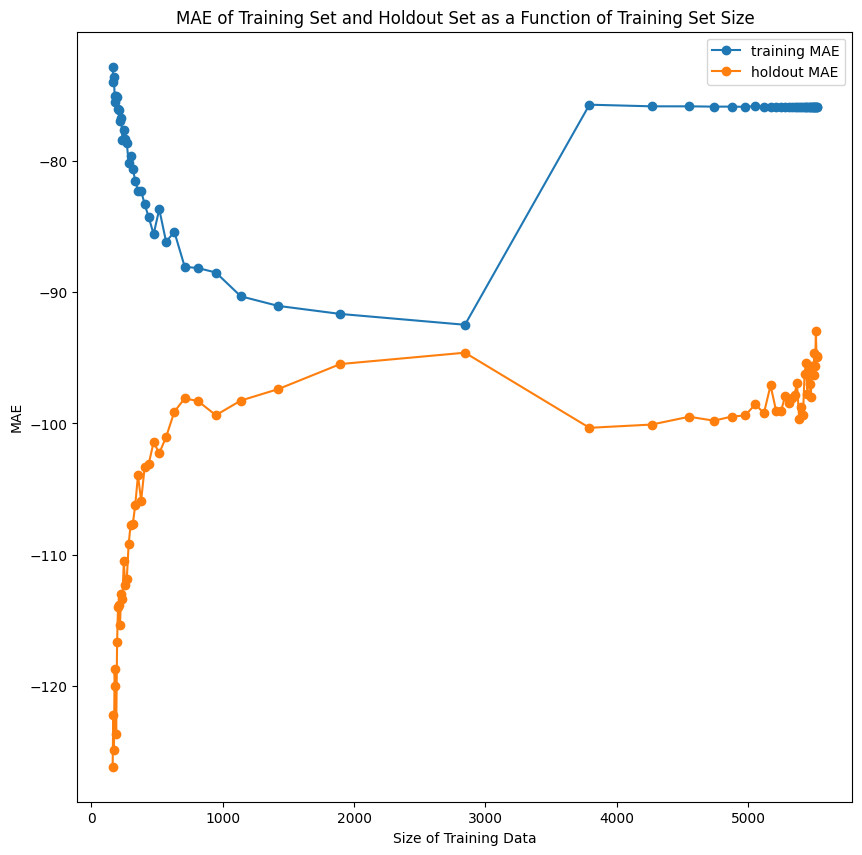

In [383]:
plot_learning_curve(best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model'], 
                    final_data_no_external_vars, 
                    max_k=35, 
                    output=False, 
                    scoring='MAE',
                    display_entropy_suburbs=False,
                    retransform_log_y=True,
                    lambda_best=lambda_best_model_3
                    )

# 5.2 Training Residuals for 3rd model <a name='bookmark5.2' />

<a href=#TOC>Back to ToC</a>

count    2844.000000
mean       -0.000002
std         0.195378
min        -0.905000
25%        -0.094000
50%         0.015000
75%         0.108250
max         2.037000
Name: cost_text, dtype: float64

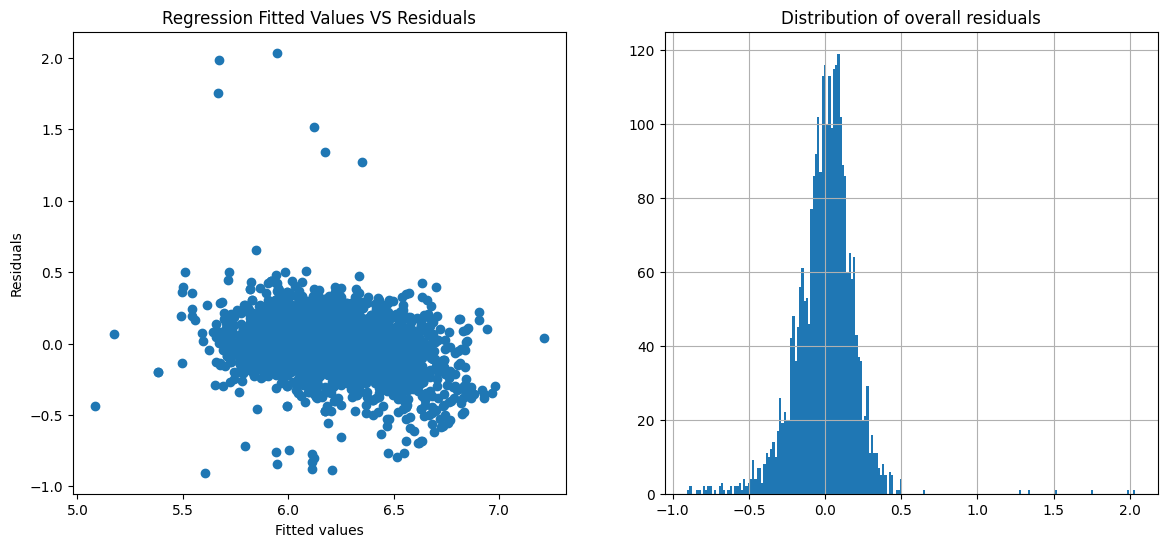

In [384]:
residuals_third_model = residual_plot(best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model_fitted'], 
              train_data_strat_preproc_feature_eng_without_external_vars.drop(columns='cost_text').values, 
              train_data_strat_preproc_feature_eng_without_external_vars['cost_text'])

In [420]:
#inspect the instances in the training data that have high residuals
train_data_strat.loc[
    residuals_third_model['residuals'].sort_values(ascending=False).head(6).index,
    :
]

cost_text     suburb  bedrooms  bathrooms  parking_spaces  \
2799       50.0   st kilda         1          1               1   
3296       40.0    prahran         0          1               1   
4490       50.0  southbank         0          0               1   
1779      100.0        kew         2          1               1   
5301      125.0   box hill         2          2               1   
4678      160.0    burwood         5          2               5   

      nearest_hospital  nearest_train_station  distance_to_cbd  \
2799            2.8352                 1.8737           6.3334   
3296            0.8303                 0.3029           5.9146   
4490            1.9218                 3.7137           2.2215   
1779            1.4036                29.1150           7.6162   
5301            0.7483                 0.8801          20.2076   
4678            6.1769                 4.7567          16.5033   

      nearest_school  2000_median_rent  ...  2012_unemployment_rate  \
2799          0.3659             196.5  ...                     4.5   
3296          0.2440             240.0  ...                     3.7   
4490          0.8933             335.0  ...                     2.3   
1779          0.3404             250.0  ...                     2.9   
5301          0.9269             190.0  ...                     7.0   
4678          0.4503             210.0  ...                     6.9   

      2013_unemployment_rate  2014_unemployment_rate  2015_unemployment_rate  \
2799                     6.3                     7.1                     5.7   
3296                     5.1                     5.9                     5.3   
4490                     2.4                     2.7                     2.1   
1779                     3.0                     3.9                     4.3   
5301                     8.2                     9.6                     9.6   
4678                     8.5                     9.0                     9.8   

      2016_unemployment_rate  2017_unemployment_rate  2018_unemployment_rate  \
2799                     5.1                     5.8                     5.1   
3296                     3.8                     4.2                     3.3   
4490                     1.8                     2.1                     1.8   
1779                     4.0                     3.8                     3.3   
5301                     9.6                     9.7                     7.7   
4678                     9.9                    10.3                     8.1   

      2019_unemployment_rate  2020_unemployment_rate  2021_unemployment_rate  
2799                     5.8                     6.8                     5.8  
3296                     3.6                     5.3                     3.9  
4490                     1.7                     3.2                     3.5  
1779                     3.1                     4.8                     4.6  
5301                     7.2                     7.2                     9.0  
4678                     8.1                     7.7                     9.4  

[6 rows x 102 columns]


# 5.3 What can we say about this model (third model)<a name='bookmark5.3' />
## 1. From the Learning Curve
The performance of the testing folds in the cross-validations greatly decreases compared to the second model (where it involves feature engineering some of internal features and computing annual increases for each external variable). 
    - In fact we have evidence of underfitting because in this csase the performance of the testing folds in the cross-validations don't even exceed -90, while the testing curve of the learning curve from the 2nd model shows that it even only takes less than half of the entire dataset to achieve a score of -90.

This might be because of the fact that ElasticNet also performs variable selection through the coefficient penalization. 
- This might mean that at least one of the external variables have some role in explaining the response, and I probably shouldn't remove all of them. 

## 2. From the residual plots
- There is no striking evidence of heteroscedasicity, except a few points that have quite high residuals (i.e. our predictions underestimate the actual y values)

## What's Next? 
Perhaps, another approach is to use all the external variables, *but only the most recent ones* (e.g. <code>2021_median_rent, 2021_annual_income, population_2021, population_density_2021, etc</code>), and consider plausible transformations to those features


<a href=#TOC>Back to ToC</a>


# 6. Feature Inspection + Engineering (preparing for fourth model) <a name='bookmark6' />
- In particular, how about we use the internal features, with the following feature engineering steps:
    - <code>dist_to_CBD = log(1/dist_to_cbd)</code>
    - <code>cost_text = log(cost_text)</code>
- And all external features in 2021 (e.g. <code>2021_median_rent, 2021_annual_income, population_2021, population_density_2021,...</code>


<a href=#TOC>Back to ToC</a>

In [273]:
#extract the response and all 2021 external features from the training data. 
train_data_strat_cost_text_and_2021_externals = train_data_strat.loc[:, train_data_strat.columns.str.contains('2021') | 
                        train_data_strat.columns.str.contains('cost_text')]

In [360]:
#Since the values of each external variable is only unique up to each suburb, 
#maybe we can plot the distribution for each 2021 external columns and see if there's any evident cluster

# train_data_strat.loc[:, train_data_strat.columns.str.contains('2021')].hist(
#     bins=20,
#     figsize=(15,8))

Check for any colinearity (and overall relationship) between the 2021 features. 

<AxesSubplot:>

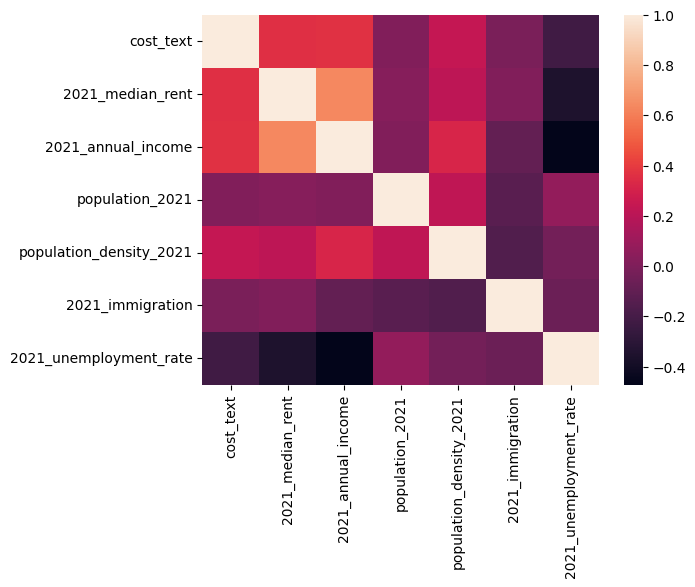

In [317]:
sns.heatmap(train_data_strat.loc[:, train_data_strat.columns.str.contains('2021') | 
                        train_data_strat.columns.str.contains('cost_text')].corr())

It seems that <code>2021_annual_income</code> and <code>2021_median_rent</code> are quite correlated. Hence it may be best to  transform both features into a rent-to-income ratio variable (i.e. <code>2021_median_rent / 2021_annual_income</code>)

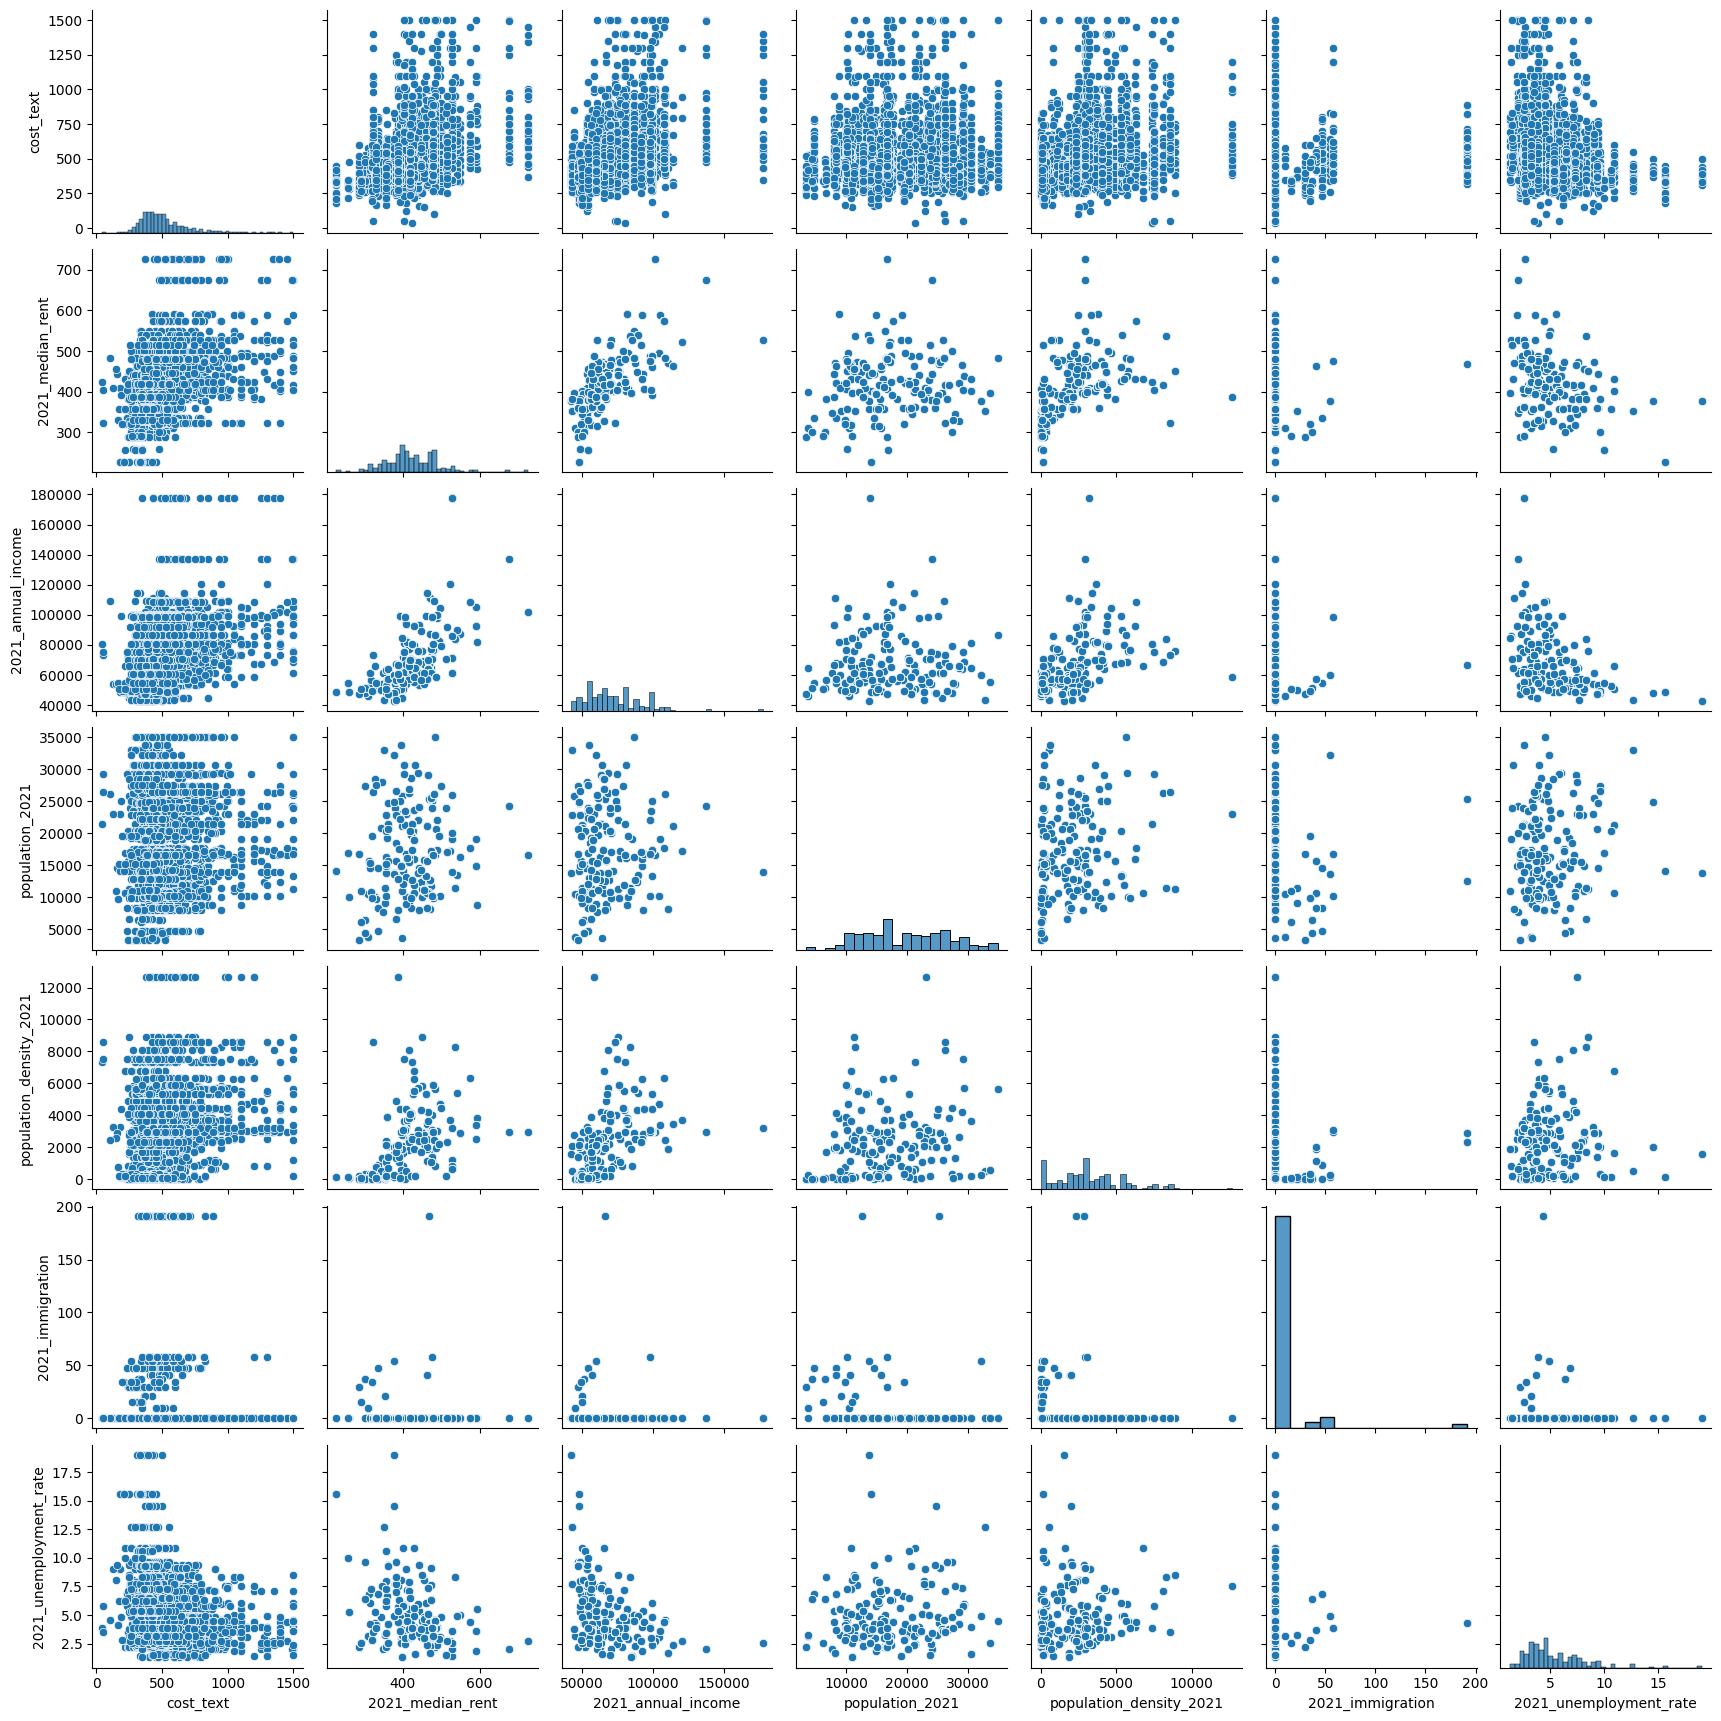

In [358]:
sns.pairplot(train_data_strat_cost_text_and_2021_externals)

It seems that <code>2021_unemployment_rate</code> has a somewhat inverse relationship to <code>cost_text</code>. I might do a transformation for this. 

In [327]:
def var_transform(row):
    
    #same reasoning for distance_to_cbd 
    row['2021_unemployment_rate'] = np.log(1/(row['2021_unemployment_rate']))
    
    row['cost_text'] = np.log(row['cost_text'])
    
    #median rent and annual income seems correlated. How about we take the 
    #quotient of it (i.e. rent-to-income ratio)
    #interpretation: 
    
    row['2021_median_rent_per_income'] =\
        row['2021_median_rent'] / row['2021_annual_income']
    
    curr_cols = row.index
    curr_cols_no_median_rent_and_annual_income = list(set(curr_cols) - set(['2021_median_rent',
                                                                      '2021_annual_income']))
    return row[curr_cols_no_median_rent_and_annual_income]

    return row

<AxesSubplot:>

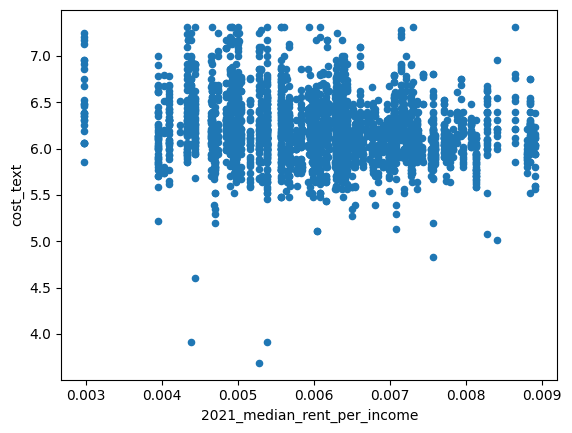

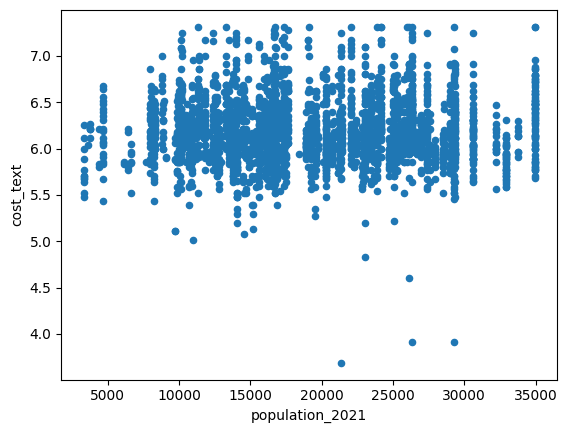

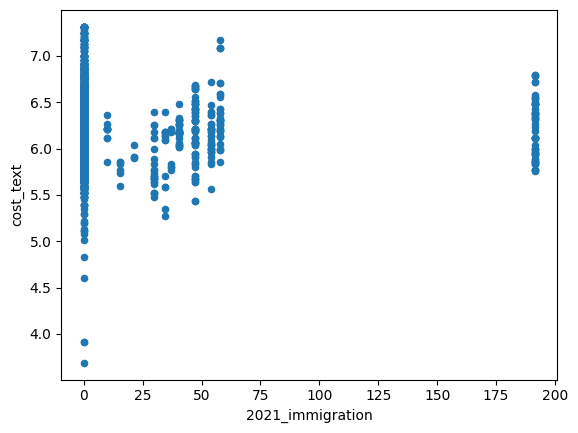

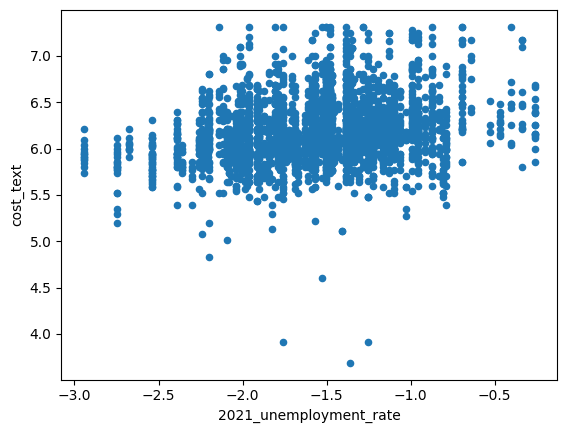

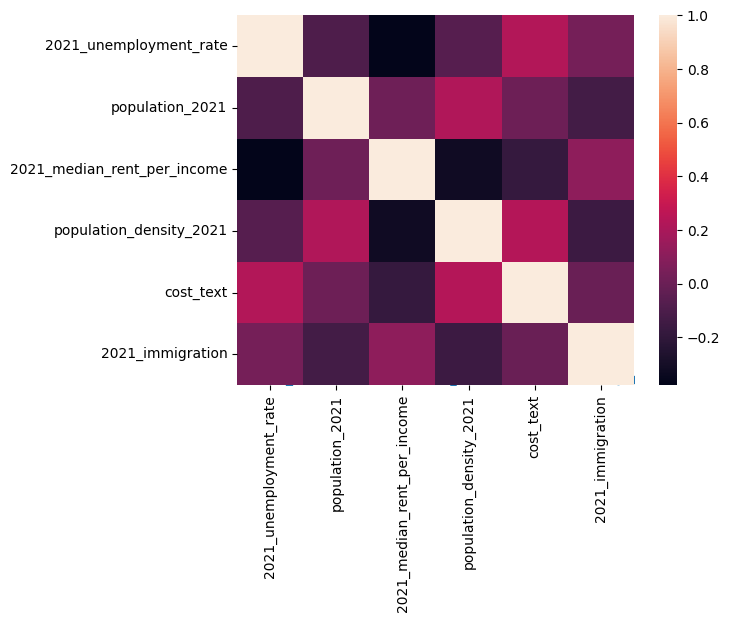

In [330]:
train_data_strat_2021_features_transformed = train_data_strat_cost_text_and_2021_externals.copy().apply(
            lambda row: var_transform(row),axis=1)


cols_transformed = ['2021_median_rent_per_income', 'population_2021', 
            '2021_immigration', '2021_unemployment_rate', 'population_density_2021']

usual_2021_external_cols = ['2021_median_rent','2021_annual_income', 'population_2021', 
            '2021_immigration', '2021_unemployment_rate', 'population_density_2021']

for col in cols_transformed:
    
    train_data_strat_2021_features_transformed.\
                    plot.scatter(x=col,y='cost_text')
    

sns.heatmap(train_data_strat_cost_text_and_2021_externals.copy().apply(
            lambda row: var_transform(row),axis=1).corr())

Recap for feature engineering: we use the internal features, with the following feature engineering steps:
    - <code>dist_to_CBD = log(1/dist_to_cbd)</code>
    - <code>cost_text = log(cost_text)</code>
    
- And all external features in 2021 (e.g. <code>2021_median_rent, 2021_annual_income, population_2021, population_density_2021,...</code>, but 
    - <code>row['2021_unemployment_rate'] = np.log(1/(row['2021_unemployment_rate']))</code>
    
    - <code>row['2021_median_rent_per_income'] = row['2021_median_rent'] / row['2021_annual_income']</code>

## 6.1 Fit fourth model to training data<a name='bookmark6.1' />


<a href=#TOC>Back to ToC</a>

In [349]:
#feature engineer internal variables, but not computing x-year increase for each external variable
train_data_strat_feat_eng_but_no_externals = feature_engineering_1(train_data_strat,with_external_vars=False)

#remove all historical external variables for now
train_data_strat_feat_eng_but_no_externals = train_data_strat_feat_eng_but_no_externals.loc[:,
                    ~train_data_strat_feat_eng_but_no_externals.columns.str.contains('\d')]

#concatenate the training data with some internal vars feature engineered, with training
#data only containing the 2021 external features (with some feature engineering)
train_data_strat_feat_eng_with_2021_ext_feat_eng = pd.concat([
    
           train_data_strat_feat_eng_but_no_externals.copy().drop(columns='cost_text'),
    
           train_data_strat_cost_text_and_2021_externals.copy().apply(
            lambda row: var_transform(row),axis=1)
          
          ],
    axis=1)


#encode nominal and ordinal variables, and standardize numeircal columns 
train_data_strat_feat_eng_with_2021_ext_feat_eng_preproc =\
    preprocess_vars_for_train(train_data_strat_feat_eng_with_2021_ext_feat_eng)

#train the model
best_model_choice_in_train_feat_eng_2021_externals_with_MAE =\
        best_penalty_method_elastic_net(train_data_strat_feat_eng_with_2021_ext_feat_eng_preproc,
                                      n_splits=10,
                                      scoring='mean_absolute_error',
                                      random_state=1)

## 6.2 Learning Curve for Fourth Model<a name='bookmark6.2' />


<a href=#TOC>Back to ToC</a>

In [365]:
def feat_eng_internal_vars_and_2021_external_vars(data):

    #feature engineer internal variables, but not computing x-year increase for each external variable
    data_feat_eng_but_no_externals = feature_engineering_1(data.copy(), with_external_vars=False)

    #remove all historical external variables for now
    data_feat_eng_but_no_externals = data_feat_eng_but_no_externals.loc[:,
                        ~data_feat_eng_but_no_externals.columns.str.contains('\d')]
    
    
    #extract response variable and 2021 external variables only 
    data_cost_text_and_2021_externals = data.loc[:, data.columns.str.contains('2021') | 
                        data.columns.str.contains('cost_text')]
    
    
    #concatenate the final data with some internal vars feature engineered, with final
    #data only containing the 2021 external features (with some feature engineering applied)
    data_strat_feat_eng_with_2021_ext_feat_eng = pd.concat([

               data_feat_eng_but_no_externals.copy().drop(columns='cost_text'),

               data_cost_text_and_2021_externals.copy().apply(
                lambda row: var_transform(row),axis=1)

              ],
        axis=1)
    
    return data_strat_feat_eng_with_2021_ext_feat_eng

In [641]:
feat_eng_internal_vars_and_2021_external_vars(final_data)

suburb  bedrooms  bathrooms  parking_spaces  nearest_hospital  \
0     hughesdale         3          2               2            3.6709   
1     hughesdale         2          1               1            5.1099   
2     hughesdale         3          1               2            3.1582   
3     hughesdale         2          1               2            5.2768   
4     hughesdale         2          1               1            4.5390   
...          ...       ...        ...             ...               ...   
5685   doncaster         2          2               1            2.3739   
5686   doncaster         3          2               2            2.8003   
5687   doncaster         4          2               2            2.3061   
5688   doncaster         2          2               1            2.2397   
5689   doncaster         3          2               2            2.3070   

      nearest_train_station  distance_to_cbd  nearest_school  \
0                    1.3443        -2.943286          0.3622   
1                    0.6205        -2.865737          1.2980   
2                    2.2726        -2.969178          0.4716   
3                    1.0049        -2.840901          0.8671   
4                    1.1504        -2.902284          0.8428   
...                     ...              ...             ...   
5685                22.1588        -2.883179          0.7789   
5686                22.5852        -2.879322          0.3681   
5687                21.7854        -2.897044          0.5335   
5688                22.0246        -2.884667          0.6186   
5689                22.0919        -2.841152          0.7121   

      2021_unemployment_rate  population_2021  2021_median_rent_per_income  \
0                  -1.308333           8313.0                     0.006198   
1                  -1.308333           8313.0                     0.006198   
2                  -1.308333           8313.0                     0.006198   
3                  -1.308333           8313.0                     0.006198   
4                  -1.308333           8313.0                     0.006198   
...                      ...              ...                          ...   
5685               -2.208274          25520.0                     0.007702   
5686               -2.208274          25520.0                     0.007702   
5687               -2.208274          25520.0                     0.007702   
5688               -2.208274          25520.0                     0.007702   
5689               -2.208274          25520.0                     0.007702   

      population_density_2021  cost_text  2021_immigration  
0                 4136.644108   6.522093               0.0  
1                 4136.644108   6.163315               0.0  
2                 4136.644108   6.309918               0.0  
3                 4136.644108   6.214608               0.0  
4                 4136.644108   5.991465               0.0  
...                       ...        ...               ...  
5685              2908.659874   6.109248               0.0  
5686              2908.659874   6.413459               0.0  
5687              2908.659874   6.579251               0.0  
5688              2908.659874   6.063785               0.0  
5689              2908.659874   6.593045               0.0  

[5690 rows x 14 columns]

Scores for test folds:  [-113.8308588   -98.22023087  -94.3598156  -130.79521025 -107.57250228
 -123.28436899 -101.17152448 -104.13825869 -102.52777434 -123.38616785
 -114.73202154 -106.20625774 -120.91546512 -224.46516918 -108.67292275
 -108.37294054  -96.01785624  -96.05924677 -105.42263096 -120.02926279
 -105.31490029 -109.89645407  -96.98204854 -317.64884797 -116.57457097
  -97.48673152  -91.1019277  -112.73140033 -104.7130833  -100.9716372 ]


Scores for training folds:  [ -51.00911947  -62.77800393  -67.47141877  -78.05749773  -62.68170973
  -57.4512428   -55.96050738  -53.0908923   -72.52613319  -79.22086598
  -83.17671609  -62.79258267  -82.97343278  -68.79689592 -105.60822635
  -78.36584516  -57.76822419  -79.92252434  -73.8791736   -68.43027897
  -52.2541642   -56.11500178  -69.16464665 -107.42240264  -64.87122424
  -75.38206745  -81.41060336  -86.5211724   -66.86934324  -61.59543987]
train_size for above: 189(3.33%)


Scores for test folds:  [-116.2288537   -97.9986676   -95

Scores for test folds:  [-108.41551237 -101.56327542 -122.28323455 -121.97412372 -103.58758846
  -93.31918858 -104.67487563  -91.89430573 -107.29448584 -102.52416421
  -94.32550519 -101.67410345 -104.87036103 -106.18993032  -94.90468085
 -100.60747149  -88.30079971 -104.14012592 -109.42722032]


Scores for training folds:  [-56.01493449 -72.17564137 -74.73180292 -58.84953969 -52.86955545
 -86.15064821 -86.58825737 -77.38239763 -85.82976685 -95.69958175
 -66.64598429 -74.88751745 -65.88948534 -56.32692221 -90.44357797
 -81.54467408 -79.21405534 -81.18946383 -70.74497787]
train_size for above: 299(5.26%)


Scores for test folds:  [-108.70431514 -100.61640736 -109.3654389  -106.74899643  -97.42456417
 -104.86859994  -98.56450527  -98.37077971 -116.05184261 -100.1053251
  -89.42306218 -108.49986324 -104.57041251  -97.25282638 -104.77129028
  -89.94527848 -105.81808397 -111.13062981]


Scores for training folds:  [-57.01398942 -71.32394366 -74.25192262 -59.96914031 -63.72349722
 -80.8280048

Scores for test folds:  [ -78.41853822  -83.8862656   -89.61716836 -104.05625005 -108.04483605
  -92.72883655  -83.83716202  -91.31700478  -91.6409147 ]


Scores for training folds:  [-76.83844196 -76.73414852 -76.10046159 -74.58924397 -74.09304386
 -75.32618975 -77.00572077 -74.78333718 -75.3499036 ]
train_size for above: 5057(88.89%)


Scores for test folds:  [ -78.74052759  -81.92121098  -82.16115335 -103.44411621 -111.11866992
  -98.03215313  -81.51847786  -99.43191528  -89.81547482  -91.03953731]


Scores for training folds:  [-76.81398542 -76.39572577 -76.92093648 -74.7804043  -73.83811786
 -75.62804717 -76.34629607 -75.11275931 -75.69529432 -75.61011823]
train_size for above: 5121(90.0%)


Scores for test folds:  [ -74.72110261  -84.42103825  -81.03246584  -94.16183186 -102.31773454
 -107.589301    -94.59915704  -73.24393543  -98.34767085  -88.71358356
  -90.01865856]


Scores for training folds:  [-76.72804795 -76.1434267  -77.2709796  -74.73556114 -75.07084108
 -74.47368751 -7

Scores for test folds:  [ -68.65729963  -77.6399074   -85.70016792  -85.75595617  -72.96700358
  -73.19080223  -90.18265251  -89.36348987  -92.22439606 -104.31689589
  -96.52357346 -114.23784618 -128.37894776  -61.25485164  -99.56852568
  -92.77608873  -73.36876581  -71.93039962  -83.55867948 -119.03769033
  -86.99222516  -82.75220028 -131.54780493  -74.74625937  -84.6508853 ]


Scores for training folds:  [-76.60198398 -75.81030498 -75.85244751 -75.64893371 -76.3595342
 -76.25584268 -76.30827694 -75.61531347 -75.21141398 -75.59010418
 -75.47050338 -74.90939056 -74.46246508 -76.38765369 -75.44176411
 -75.55056092 -76.04274576 -76.16406052 -76.46233611 -74.40532173
 -75.97056375 -75.72017856 -74.72543994 -75.95788555 -76.02801697]
train_size for above: 5462(96.0%)


Scores for test folds:  [ -68.984115    -80.50114686  -85.92344142  -94.85618747  -63.04572238
  -84.11446749  -80.70610723  -88.33074589  -93.95294915 -114.49949578
 -106.32925227 -105.61416084 -120.55800543 -111.20467503  

/tmp/ipykernel_77/3184143871.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_scores = np.array(test_scores)
/tmp/ipykernel_77/3184143871.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_scores = np.array(train_scores)


[array([-70.78557857, -71.07730108, -71.00975567, -71.23186187,
        -71.80751531, -71.82595783, -72.44886931, -72.65239802,
        -72.95456734, -73.03859624, -73.89609807, -74.37783074,
        -74.40644239, -75.20796098, -75.82986489, -75.28147929,
        -76.35585433, -76.85847271, -77.25116998, -77.71486449,
        -78.06459403, -78.66877192, -79.8205927 , -80.75083087,
        -80.54067431, -81.82842143, -82.99429006, -83.55242635,
        -85.13047048, -75.52621292, -75.66107329, -75.65567788,
        -75.68626473, -75.68565678, -75.70155827, -75.64672124,
        -75.71416849, -75.70757274, -75.71389533, -75.69974289,
        -75.71262553, -75.71425454, -75.71351886, -75.71833617,
        -75.69573353, -75.71295541, -75.71450624, -75.71820956,
        -75.7189543 , -75.72122778, -75.72340368, -75.71812169,
        -75.72009503, -75.70548076, -75.72390819, -75.72473763,
        -75.72119621]),
 array([-118.45340292, -110.20264524, -110.64462657, -109.30306619,
        -110

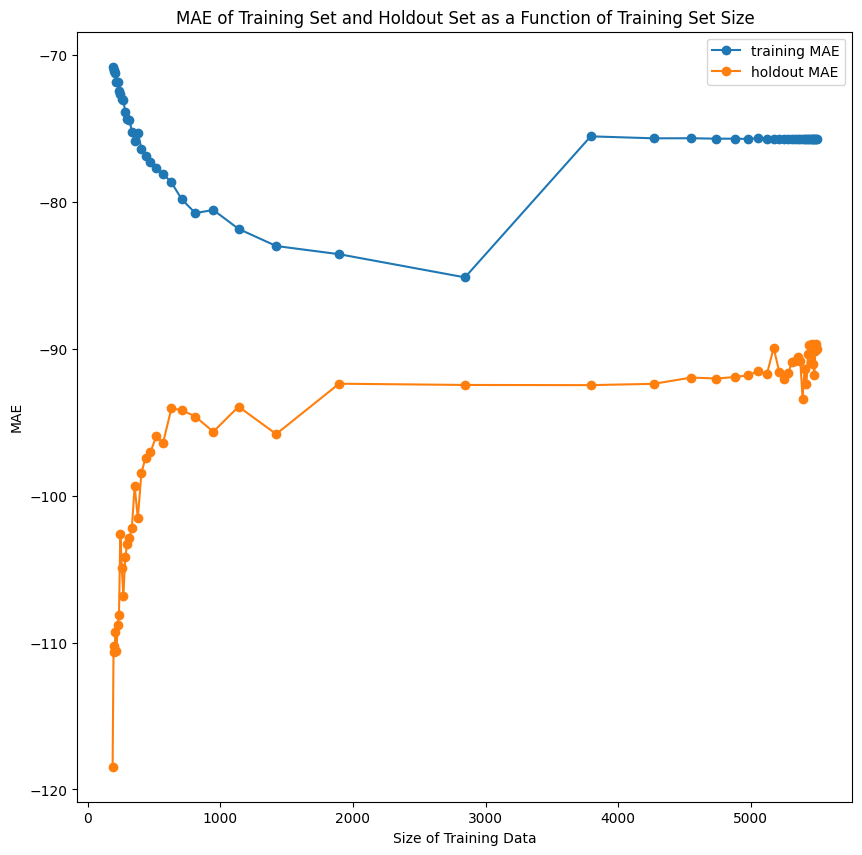

In [646]:
lambda_best_2021_externals = best_model_choice_in_train_feat_eng_2021_externals_with_MAE['potentially_best_model_fitted'].\
                                            lambda_best_[0]

plot_learning_curve(best_model_choice_in_train_feat_eng_2021_externals_with_MAE['potentially_best_model'], 
                    feat_eng_internal_vars_and_2021_external_vars(final_data), 
                    max_k=30, 
                    output=True, 
                    scoring='MAE', 
                    display_entropy_suburbs=False,
                    retransform_log_y=True,
                    lambda_best=lambda_best_2021_externals
                   )

## 6.3 Residual Plot in Training Data for Fourth Model<a name='bookmark6.3' />


<a href=#TOC>Back to ToC</a>

count    2844.000000
mean        0.000005
std         0.194831
min        -0.892000
25%        -0.096000
50%         0.015000
75%         0.108000
max         2.053000
Name: cost_text, dtype: float64

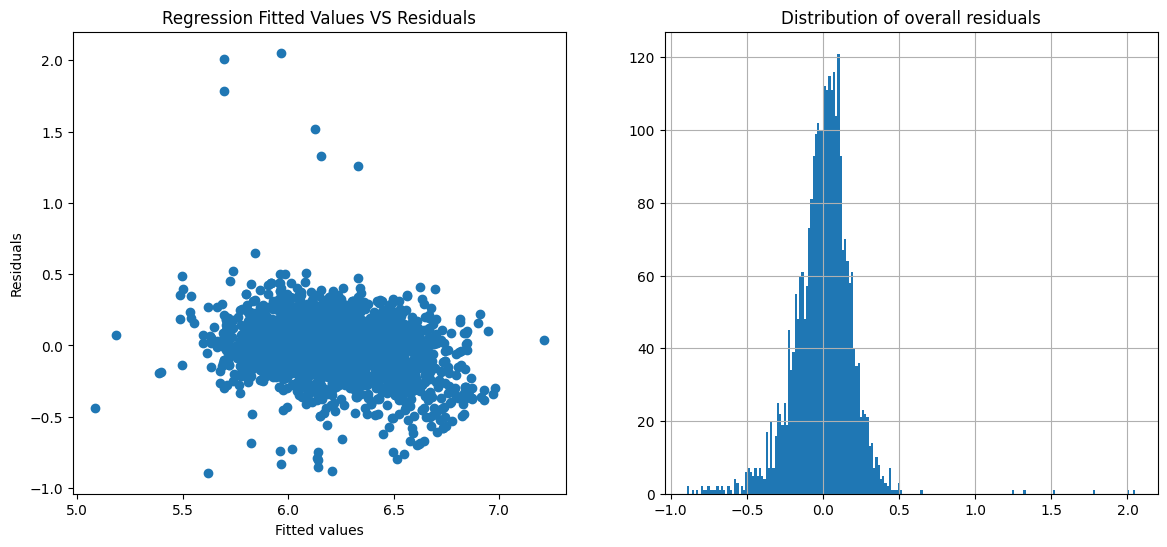

In [418]:
residual_plot_fourth_model = residual_plot(
    model_fitted=best_model_choice_in_train_feat_eng_2021_externals_with_MAE['potentially_best_model_fitted'],
    X = train_data_strat_feat_eng_with_2021_ext_feat_eng_preproc.drop(columns='cost_text'),
    y = train_data_strat_feat_eng_with_2021_ext_feat_eng_preproc['cost_text']
)

In [419]:
#inspect the instances in the training data that have high residuals
train_data_strat.loc[
    residual_plot_fourth_model['residuals'].sort_values(ascending=False).head(6).index,
    :
]

cost_text     suburb  bedrooms  bathrooms  parking_spaces  \
2799       50.0   st kilda         1          1               1   
3296       40.0    prahran         0          1               1   
4490       50.0  southbank         0          0               1   
1779      100.0        kew         2          1               1   
5301      125.0   box hill         2          2               1   
4678      160.0    burwood         5          2               5   

      nearest_hospital  nearest_train_station  distance_to_cbd  \
2799            2.8352                 1.8737           6.3334   
3296            0.8303                 0.3029           5.9146   
4490            1.9218                 3.7137           2.2215   
1779            1.4036                29.1150           7.6162   
5301            0.7483                 0.8801          20.2076   
4678            6.1769                 4.7567          16.5033   

      nearest_school  2000_median_rent  ...  2012_unemployment_rate  \
2799          0.3659             196.5  ...                     4.5   
3296          0.2440             240.0  ...                     3.7   
4490          0.8933             335.0  ...                     2.3   
1779          0.3404             250.0  ...                     2.9   
5301          0.9269             190.0  ...                     7.0   
4678          0.4503             210.0  ...                     6.9   

      2013_unemployment_rate  2014_unemployment_rate  2015_unemployment_rate  \
2799                     6.3                     7.1                     5.7   
3296                     5.1                     5.9                     5.3   
4490                     2.4                     2.7                     2.1   
1779                     3.0                     3.9                     4.3   
5301                     8.2                     9.6                     9.6   
4678                     8.5                     9.0                     9.8   

      2016_unemployment_rate  2017_unemployment_rate  2018_unemployment_rate  \
2799                     5.1                     5.8                     5.1   
3296                     3.8                     4.2                     3.3   
4490                     1.8                     2.1                     1.8   
1779                     4.0                     3.8                     3.3   
5301                     9.6                     9.7                     7.7   
4678                     9.9                    10.3                     8.1   

      2019_unemployment_rate  2020_unemployment_rate  2021_unemployment_rate  
2799                     5.8                     6.8                     5.8  
3296                     3.6                     5.3                     3.9  
4490                     1.7                     3.2                     3.5  
1779                     3.1                     4.8                     4.6  
5301                     7.2                     7.2                     9.0  
4678                     8.1                     7.7                     9.4  

[6 rows x 102 columns]

# 6.4 What can we say about this model (fourth model)<a name='bookmark6.4' />
It seems that only retaining 2021 features will not yield as much performance 

<a href=#TOC>Back to ToC</a>


# 7. Final Model: For now, I build the model as per specifications in model 2 using the entire dataset. <a name='bookmark7' />
- It has the best performance (at least, based on the learning curves), although having 80 or 90 dollars as the average deviation of the predictions of rental prices seem detremimental, ultimately my goal is to explain the 2022 rental prices based on the internal and external features. 
    - In other words, although our model bias is quite high, ultimately the residuals throughout the fitted values are equally spread around 0 (based on residual plot on model 2, and the residual plot for the model trained on entire data below). 
        - Hence, the coefficients are still useful in explaining the *trend* of the 2022 rental prices given the increase or decrease of a variable. 
        
<a href=#TOC>Back to ToC</a>

In [496]:
#feature engineer and preprocess the entire dataset
final_data_feature_eng_basedon_model_2_preproc = preprocess_vars_for_train(feature_engineering_1(final_data.copy()), 
                                                                           encode_ordinal=True).copy()
#fit the model on entire dataset
best_model_basedon_model2_for_full_data =\
            best_penalty_method_elastic_net(final_data_feature_eng_basedon_model_2_preproc,
                                      n_splits=10,
                                      scoring='mean_absolute_error',
                                      random_state=1)

count    5690.000000
mean       -0.000005
std         0.198103
min        -1.188000
25%        -0.099000
50%         0.010000
75%         0.108000
max         2.150000
Name: cost_text, dtype: float64

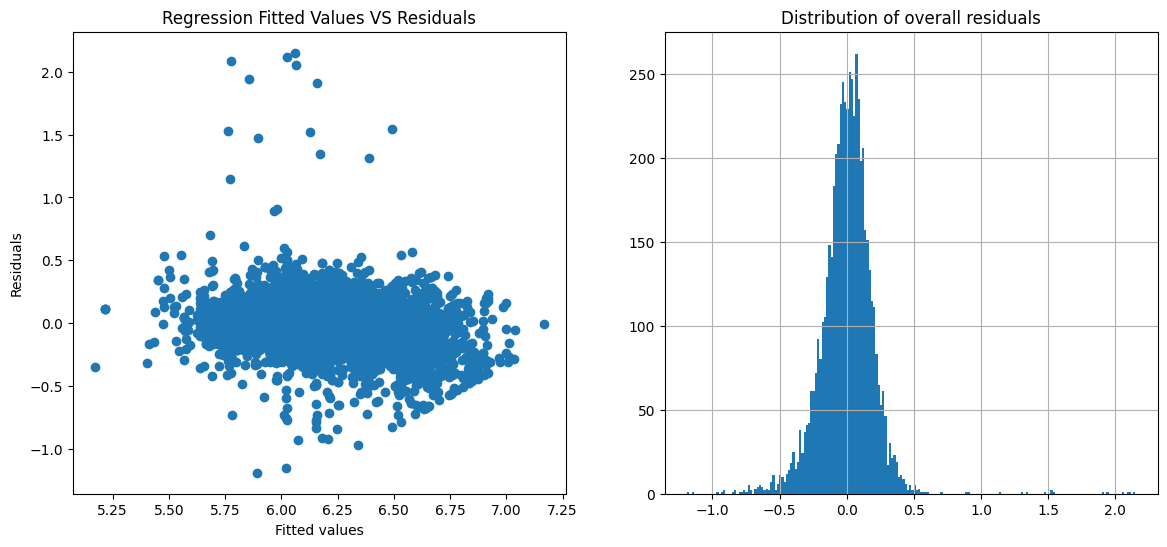

In [508]:
#obtain residuals 
residual_final_model = residual_plot(best_model_basedon_model2_for_full_data['potentially_best_model_fitted'], 
              X=final_data_feature_eng_basedon_model_2_preproc.drop(columns='cost_text'), 
              y=final_data_feature_eng_basedon_model_2_preproc['cost_text'], 
              lambda_best=None, retransform_log_to_exp=False)

In [573]:
#obtain MAE on final data 
final_data_pred_y_logged = best_model_basedon_model2_for_full_data['potentially_best_model_fitted'].\
                            predict(final_data_feature_eng_basedon_model_2_preproc.drop(columns='cost_text'))

final_data_actual_y_logged = final_data_feature_eng_basedon_model_2_preproc['cost_text']

final_data_pred_y_logged = np.exp(final_data_pred_y_logged)

final_data_actual_y_logged = np.exp(final_data_actual_y_logged)

MAE_final_data = (abs(final_data_actual_y_logged - final_data_pred_y_logged)).mean()
MAE_final_data


74.8698962448754

# Visualise the Coefficients in Some Way to Answer the Research Question number 1

In [605]:
final_model_coeffs = pd.DataFrame(
    
    index=['Intercept'] + list(final_data_feature_eng_basedon_model_2_preproc.drop(columns='cost_text').columns), 
    
    data=[best_model_basedon_model2_for_full_data['potentially_best_model_fitted'].intercept_] +\
                list(best_model_basedon_model2_for_full_data['potentially_best_model_fitted'].coef_), 
    columns=['Coefficient (MAE)']
).reset_index().rename(columns={'index':'variables', 'Coefficient (MAE)':'coefficient'})

final_model_coeffs = final_model_coeffs.sort_values(by='coefficient')

In [592]:
def scale_coeffs_by_log(row):
    
    if row['coefficient'] < 0:
        row['coefficient'] = -1 * np.log(row['coefficient'])
    else:
        row['coefficient'] = np.log(row['coefficient'])
    return row
        

In [595]:
# final_model_coeffs_log_scale = final_model_coeffs.copy()[
#     final_model_coeffs['variables'].isin(['nearest_hospital', 'nearest_train_station',
#        'distance_to_cbd', 'nearest_school'])
# ].apply(lambda row: scale_coeffs_by_log(row), axis='columns')

## Internal Features: Features relating to proximities

[Text(0, 0, '-0.000671931'),
 Text(0, 0, '0.00223135'),
 Text(0, 0, '0.00268641'),
 Text(0, 0, '0.0169392')]

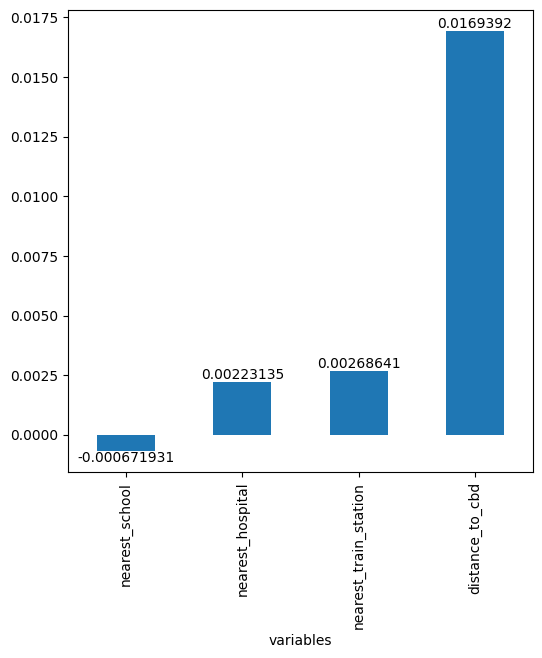

In [606]:
ax = final_model_coeffs.copy()[
     final_model_coeffs['variables'].isin(['nearest_hospital', 'nearest_train_station',
        'distance_to_cbd', 'nearest_school'])
].plot.bar(x='variables', 
           y='coefficient',
           legend=False,
           figsize=(6,6))

ax.bar_label(ax.containers[0])

## Regression Coefficients for Suburbs Visualised

In [619]:
final_model_coeffs_suburbs = final_model_coeffs.copy()[final_model_coeffs['variables'].str.contains('suburb_')]
final_model_coeffs_suburbs['variables'] = final_model_coeffs_suburbs['variables'].str.strip('suburb_')
final_model_coeffs_suburbs = final_model_coeffs_suburbs.rename(
    columns={'variables':'suburb'})

In [622]:
geopandas_plotting(final_model_coeffs_suburbs, 
                   sf=vic_shapefile_no_duplicates, 
                   legend_name='ElasticNet Regression Coefficients', 
                   col_to_be_plot='coefficient',
                   save=False,
                   saved_map_name='',
                   map_format='html')

## As for the interpretation  for the  historical external variables..

In [652]:
final_model_coeffs_annual_income = final_model_coeffs[
    final_model_coeffs['variables'].str.contains('\d{4}') &
    final_model_coeffs['variables'].str.contains('annual_income')
]

final_model_coeffs_annual_income

variables  coefficient
35  annual_income_inc_from_2020_to_2021    -0.004178
34  annual_income_inc_from_2019_to_2020    -0.004149
33  annual_income_inc_from_2018_to_2019    -0.004123
30  annual_income_inc_from_2015_to_2016    -0.001334
32  annual_income_inc_from_2017_to_2018     0.003001
31  annual_income_inc_from_2016_to_2017     0.005725
26  annual_income_inc_from_2011_to_2012     0.008256
28  annual_income_inc_from_2013_to_2014     0.012178
29  annual_income_inc_from_2014_to_2015     0.013697
27  annual_income_inc_from_2012_to_2013     0.022085

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'annual_income_inc_from_2020_to_2021'),
  Text(1, 0, 'annual_income_inc_from_2019_to_2020'),
  Text(2, 0, 'annual_income_inc_from_2018_to_2019'),
  Text(3, 0, 'annual_income_inc_from_2015_to_2016'),
  Text(4, 0, 'annual_income_inc_from_2017_to_2018'),
  Text(5, 0, 'annual_income_inc_from_2016_to_2017'),
  Text(6, 0, 'annual_income_inc_from_2011_to_2012'),
  Text(7, 0, 'annual_income_inc_from_2013_to_2014'),
  Text(8, 0, 'annual_income_inc_from_2014_to_2015'),
  Text(9, 0, 'annual_income_inc_from_2012_to_2013')])

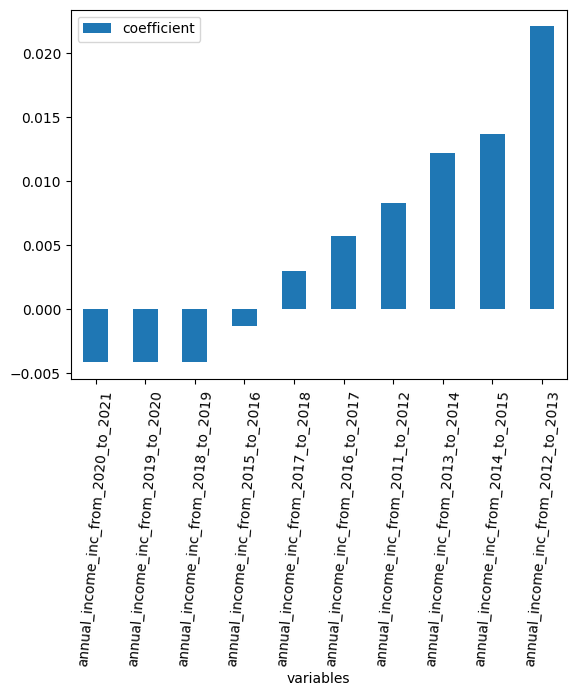

In [658]:
final_model_coeffs_annual_income.plot.bar(x='variables',y='coefficient')
plt.xticks(rotation=85)

Maybe can say something like for suburbs whose annual income increases in 2020 up to 2021, ultimately it is associated with a decrease in rental price in 2022??

## More plots await..

# Try OLS on <code>cost_text ~ all internal + proximity variables without historical external variables</code> (NOT YET FINISHED, but fitting on training data with all variables and plotting the learning curve show that the model greatly underfits compared to ElasticNet)

In [662]:
# preprocess_vars_for_train(feature_engineering_1(train_data_strat), encode_ordinal=True)

In [660]:
train_data_preproc = preprocess_vars_for_train(train_data_strat, encode_ordinal=True)

train_data_preproc.loc[:,train_data_preproc.dtypes == 'uint8'] =\
        train_data_preproc.loc[:,train_data_preproc.dtypes == 'uint8'].astype('float64')


first_ols_model_all_vars = ols(
        formula = make_formula_object(
            
            train_data_preproc, 
            variables='all', 
            response='cost_text'
        ), 
    
    data = train_data_preproc
).fit()

In [661]:
first_ols_model_all_vars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cost_text   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     30.84
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        01:05:21   Log-Likelihood:                -17552.
No. Observations:                2844   AIC:                         3.547e+04
Df Residuals:                    2659   BIC:                         3.658e+04
Df Model:                         184                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       428.3580     15.569     27.513      0.000     397.829     458.887
nearest_hospital                -27.9171     20.592     -1.356      0.175     -68.296      12.461
nearest_train_station             1.3485     24.821      0.054      0.957     -47.323      50.020
distance_to_cbd                 -39.3302    120.437     -0.327      0.744    -275.489     196.829
nearest_school                   -0.1579      3.261     -0.048      0.961      -6.552       6.236
Q("2000_median_rent")           110.4006    208.331      0.530      0.596    -298.107     518.909
Q("2001_median_rent")          -170.3585    243.900     -0.698      0.485    -648.611     307.894
Q("2002_median_rent")            78.4836    142.307      0.552      0.581    -200.560     357.527
Q("2003_median_rent")           -45.6833    113.610     -0.402      0.688    -268.457     177.090
Q("2004_median_rent")           -79.8935    146.213     -0.546      0.585    -366.596     206.809
Q("2005_median_rent")             4.1162    146.446      0.028      0.978    -283.044     291.277
Q("2006_median_rent")            -1.1175    155.588     -0.007      0.994    -306.203     303.968
Q("2007_median_rent")            58.2346    130.000      0.448      0.654    -196.676     313.145
Q("2008_median_rent")          -146.5570    269.888     -0.543      0.587    -675.769     382.655
Q("2009_median_rent")            92.9023    184.774      0.503      0.615    -269.414     455.218
Q("2010_median_rent")           -16.7157    125.933     -0.133      0.894    -263.653     230.221
Q("2011_median_rent")            30.9524    101.227      0.306      0.760    -167.540     229.444
Q("2012_median_rent")            23.5656     98.826      0.238      0.812    -170.218     217.349
Q("2013_median_rent")          -232.6891    335.344     -0.694      0.488    -890.251     424.872
Q("2014_median_rent")           195.7684    195.266      1.003      0.316    -187.119     578.656
Q("2015_median_rent")             8.7549    159.259      0.055      0.956    -303.530     321.039
Q("2016_median_rent")           -14.2539     79.111     -0.180      0.857    -169.378     140.871
Q("2017_median_rent")            24.2987    118.085      0.206      0.837    -207.248     255.846
Q("2018_median_rent")            30.9774    102.146      0.303      0.762    -169.316     231.270
Q("2019_median_rent")           -52.7732    285.839     -0.185      0.854    -613.263     507.717
Q("2020_median_rent")            98.0213    201.269      0.487      0.626    -296.639     492.682
Q("2021_median_rent")           -11.8238     67.692     -0.175      0.861    -144.557     120.910
Q("2011_annual_income")          75.5936     85.005      0.889      0.374     -91.089     242.276
Q("2012_annual_income")          31.0669     

In [666]:
test_data_preproc = preproc_transform_test_data(test_data_strat, 
                                                train_data_strat
                                               )

In [667]:
first_ols_model_all_vars.predict(test_data_preproc)

0       636.416088
1       384.730542
5       737.976271
8       722.704424
9       723.676276
           ...    
5673    712.748341
5674    581.454431
5684    472.219899
5687    712.440742
5689    622.861007
Length: 2846, dtype: float64

In [533]:
# first_ols_model_all_vars_forward_reg = forward_regression(train_data_preproc.drop(columns='cost_text'),
#                   train_data_preproc['cost_text'],
#                   0.05)

In [534]:
# first_ols_model_all_vars_backward_reg = backward_regression(train_data_preproc.drop(columns='cost_text'),
#                   train_data_preproc['cost_text'],
#                   0.05)

<font color='blue'>Function: K-fold CV for OLS</font>

In [545]:
def k_fold_CV_OLS(data, k, shuffle_data=False, 
                  swap_train_test=False, score='MAE', variables='all',
                  retransform_log=False):
    
    """Performs a K-fold cross validation
    model evaluation technique on 'data', and
    returns the scores (R2 or MAE)
    In particular, return value is:
    (testing_scores, training_scores)
    
    Each is a list. 

    
    """
    
    N = data.shape[0]
    N_per_fold = N // k
    
    scores_per_test_fold = []
    training_scores_per_iteration = []
    
    if shuffle_data == True:
        #add code for random permutation if needed.
        #but for now we dont really need it. 
        pass
    
    for fold in range(0,k):
        #obtain testing and training folds
        testing_fold = data.iloc[ (N//k) * fold: (N//k) * (fold+1) ]
        training_folds = data[~data.index.isin(testing_fold.index)]
        
        #preprocess training and testing folds
        
        if swap_train_test == False: #usual K-fold CV (one fold = testing)
            
            training_folds_preproc = preprocess_vars_for_train(training_folds, encode_ordinal=True)
            testing_folds_preproc = preproc_transform_test_data(testing_fold, training_folds)
            
            
        else:    
            
            testing_folds_preproc = preprocess_vars_for_train(training_folds, encode_ordinal=True)
            training_folds_preproc = preproc_transform_test_data(testing_fold, training_folds)
        
        
        #train the model on the current training folds
        model = ols(
            formula = make_formula_object(

                    training_folds_preproc, 
                    variables=variables, 
                    response='cost_text'
                ), 
    
            data = training_folds_preproc
        )
        
        model_fitted = model.fit()
        
            
        if score == 'MAE':
            
            #note: since MAE represents the DEVIATIONS between predicted
            #and actual value one way to inverse it is to multiply by -1
            
            #i. get testing prediction, and evaluate mean absolute error
            predict_test = model_fitted.predict(
                testing_folds_preproc
            )
            
            if retransform_log == False:
                score_per_test_fold = testing_folds_preproc['cost_text'] - predict_test
                score_per_test_fold = -1 * np.mean(abs(score_per_test_fold))
            else:
                score_per_test_fold = np.exp(testing_folds_preproc['cost_text']) - np.exp(predict_test)
                score_per_test_fold = -1 * np.mean(abs(score_per_test_fold))
            
            #ii. get training prediction (i.e. fitted values), and evaluate mean absolute error
            predict_train = model_fitted.predict(
                training_folds_preproc
            )
            
            if retransform_log == False:
                training_score_per_iteration = training_folds_preproc['cost_text'] - predict_train
                training_score_per_iteration = -1 * np.mean(abs(training_score_per_iteration))
                
            else:
                training_score_per_iteration = np.exp(training_folds_preproc['cost_text']) - np.exp(predict_train)
                training_score_per_iteration = -1 * np.mean(abs(training_score_per_iteration))

        scores_per_test_fold.append(score_per_test_fold)
        training_scores_per_iteration.append(training_score_per_iteration)
        
    scores_per_test_fold = np.array(scores_per_test_fold)
    training_scores_per_iteration = np.array(training_scores_per_iteration)
    
    print("Scores for test folds: ", scores_per_test_fold)    
    print("Scores for training folds: ", training_scores_per_iteration)
    
    return scores_per_test_fold, training_scores_per_iteration


In [546]:
# k_fold_CV_OLS(final_data, 
#               10, 
#               shuffle_data=False, 
#               swap_train_test=False, 
#               score='MAE', 
#               variables='all'
#              )

In [566]:
def plot_learning_curve_OLS(data, max_k=3, output=True, scoring='MAE', variables='all',
                           retransform_log=False):
    
    train_scores = []
    test_scores = []
    train_sizes = []
    
    N = data.shape[0]
    
    k_values = list(range(2, max_k+1))
    
    for k in k_values[::-1]: #k_values: max_k, decrease to 2
        
        k_fold_scores =\
            k_fold_CV_OLS(data,
            k, 
            shuffle_data=False,
            swap_train_test=True,
            score=scoring,
            variables=variables,
            retransform_log=retransform_log)
        
        k_fold_scores_train = k_fold_scores[1]
        k_fold_scores_test = k_fold_scores[0]
        
        #check for undefined scores
        for i in range(len(k_fold_scores_train)):
            if k_fold_scores_train[i] == np.inf:
                k_fold_scores_train[i] = 2000

            if k_fold_scores_test[i] == np.inf:
                k_fold_scores_test[i] = 2000
        
        train_scores.append( k_fold_scores_train )
        test_scores.append( k_fold_scores_test )
        
        train_sizes.append( 
            int( N * (1/k) )
        )
        
        print(f'train_size for above: {int( N * (1/k) )}({round(100*1/k,2)}%)')
        print('\n')
        
    for k in k_values[1:]: #k_values: 3, increase to max_k
        
        #the number of folds k in k-fold will
        #depend on the train sizes used for the
        #training folds
        
        k_fold_scores =\
            k_fold_CV_OLS(data,
            k, 
            shuffle_data=False,
            swap_train_test=False,
            score=scoring,
            variables=variables,
            retransform_log=retransform_log)
        
        k_fold_scores_train = k_fold_scores[1]
        k_fold_scores_test = k_fold_scores[0]
        
        #check for undefined scores
        for i in range(len(k_fold_scores_train)):
            if k_fold_scores_train[i] == np.inf:
                k_fold_scores_train[i] = 2000

            if k_fold_scores_test[i] == np.inf:
                k_fold_scores_test[i] = 2000
            
        
        train_scores.append( k_fold_scores_train ) 
        test_scores.append( k_fold_scores_test ) 
        
        train_sizes.append( 
            int( N * ((k-1)/k) )
        )
        
        print(f'train_size for above: {int( N * ((k-1)/k) )}({round(100*((k-1)/k),2)}%)')
        print('\n')
    
    test_scores = np.array(test_scores)
    train_scores = np.array(train_scores)
    
    
    if output:
        print("train set sizes, training set scores, testing set scores below:\n")
        print(train_sizes, train_scores[0:5], '\n\n', test_scores[0:5])
    
    
    #using np.vectorise preceding
    #np.mean: cant find a way to reshape np arrays so that it won't throw errors
    #otherwise numpys a bit pedantic to not simply able to take means of rows..
    
    
    plt.figure(figsize=(10,10))
    plt.title(f'{scoring} of Training Set and Holdout Set as a Function of Training Set Size')
    plt.plot(train_sizes, np.vectorize(np.mean)(train_scores),label='line with marker',marker='o')
    plt.plot(train_sizes, np.vectorize(np.mean)(test_scores),label='line with marker',marker='o')
    plt.xlabel('Size of Training Data')
    plt.ylabel(f'{scoring}')
    plt.legend([f'training {scoring}', f'holdout {scoring}'])
    
    return [np.vectorize(np.mean)(train_scores), np.vectorize(np.mean)(test_scores)]

In [560]:
np.inf

inf

In [561]:
(np.array([3])/0)[0] == np.inf

/tmp/ipykernel_77/3621129417.py:1: RuntimeWarning: divide by zero encountered in divide
  (np.array([3])/0)[0] == np.inf


True

In [669]:
final_data

cost_text      suburb  bedrooms  bathrooms  parking_spaces  \
0         680.0  hughesdale         3          2               2   
1         475.0  hughesdale         2          1               1   
2         550.0  hughesdale         3          1               2   
3         500.0  hughesdale         2          1               2   
4         400.0  hughesdale         2          1               1   
...         ...         ...       ...        ...             ...   
5685      450.0   doncaster         2          2               1   
5686      610.0   doncaster         3          2               2   
5687      720.0   doncaster         4          2               2   
5688      430.0   doncaster         2          2               1   
5689      730.0   doncaster         3          2               2   

      nearest_hospital  nearest_train_station  distance_to_cbd  \
0               3.6709                 1.3443          18.9780   
1               5.1099                 0.6205          17.5619   
2               3.1582                 2.2726          19.4758   
3               5.2768                 1.0049          17.1311   
4               4.5390                 1.1504          18.2156   
...                ...                    ...              ...   
5685            2.3739                22.1588          17.8709   
5686            2.8003                22.5852          17.8021   
5687            2.3061                21.7854          18.1204   
5688            2.2397                22.0246          17.8975   
5689            2.3070                22.0919          17.1354   

      nearest_school  2000_median_rent  ...  2012_unemployment_rate  \
0             0.3622             170.0  ...                     5.4   
1             1.2980             170.0  ...                     5.4   
2             0.4716             170.0  ...                     5.4   
3             0.8671             170.0  ...                     5.4   
4             0.8428             170.0  ...                     5.4   
...              ...               ...  ...                     ...   
5685          0.7789             230.0  ...                     6.2   
5686          0.3681             230.0  ...                     6.2   
5687          0.5335             230.0  ...                     6.2   
5688          0.6186             230.0  ...                     6.2   
5689          0.7121             230.0  ...                     6.2   

      2013_unemployment_rate  2014_unemployment_rate  2015_unemployment_rate  \
0                        6.2                     5.9                     4.7   
1                        6.2                     5.9                     4.7   
2                        6.2                     5.9                     4.7   
3                        6.2                     5.9                     4.7   
4                        6.2                     5.9                     4.7   
...                      ...                     ...                     ...   
5685                     8.6                     9.4                     8.5   
5686                     8.6                     9.4                     8.5   
5687                     8.6                     9.4                     8.5   
5688                     8.6                     9.4                     8.5   
5689                     8.6                     9.4                     8.5   

      2016_unemployment_rate  2017_unemployment_rate  2018_unemployment_rate  \
0                        4.7                     4.9                     4.4   
1                        4.7                     4.9                     4.4   
2                        4.7                     4.9                     4.4   
3                        4.7                     4.9                     4.4   
4                        4.7                     4.9                     4.4   
...                      ...                     ...                     ...   
5685                  

In [672]:
# plot_learning_curve_OLS(final_data, 
#                         max_k=11, 
#                         output=True, scoring='MAE', 
#                         variables='all',
#                         retransform_log=True)